Root Mean Square Flactuation (RMSF)

RMSF is a measure of the deviation of the position of a particle i with respect to a reference position **over time**.

**Difference between RMSD and RMSF**: The latter is averaged over time, giving a value for each particle i. For the RMSD the average is taken over the particles, giving time specific values. So **RMSD is time specific** and **RMSF is atom specific** [(ref)](http://www.drugdesign.gr/uploads/7/6/0/2/7602318/lecture_mdanalysis.pdf).

\begin{equation*}
RMSF_i = \left[ \frac{1}{T} \sum_{t_j=1}^T \mid r_i(t_j) - r_i^\text{ref} \mid ^ 2 \right] ^ \frac{1}{2}
\end{equation*}

$T$ is the total simulation time  
$r_i^\text{ref}$ is the reference position of particle $i$, eg. the **time-averaged** position of the same particle $i$  
$\mid r_i(t_j) - r_i^\text{ref} \mid$ is the Euclidean distance of particle $i$ on frame $j$ from $r_i^\text{ref}$

This time since our $x-axis$ are the residue ids, we will have a slightly different approach.
Our $y-axis$ will have the RMSF value of the residues specified by the $x-axis$.

In [1]:
import MDAnalysis
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.analysis import contacts
from MDAnalysis.analysis.align import AlignTraj 
import MDAnalysis.analysis.pca as pca
import MDAnalysis.analysis.distances as dist_analysis

from MDSimsEval.AnalysisActorClass import AnalysisActor
from MDSimsEval.utils import create_analysis_actor_dict
import mdtraj as md_traj

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import imgkit

import re
import os
import subprocess
import logging
import math
import random
import itertools
import pickle

from operator import itemgetter

from tqdm.notebook import tqdm
from IPython.display import display

In [2]:
analysis_actors_dict = create_analysis_actor_dict('../datasets/New_AI_MD/')

rmsf_cache = {}
windows = [[0, 2500], [0, 1250], [1250, 2500], [0, 500], [500, 1000], [1000, 1500], [1500, 2000], [2000, 2500]]
# # Agonists
# for which_ligand in tqdm(analysis_actors_dict['Agonists'], desc="Agonists Calculations"):
#     which_ligand.perform_analysis(metrics=["RMSF"])
    
# # Antagonists
# for which_ligand in tqdm(analysis_actors_dict['Antagonists'], desc="Antagonists Calculations"):
#     which_ligand.perform_analysis(metrics=["RMSF"])

Agonists | Lorcaserin:   4%|▎         | 1/27 [00:00<00:13,  1.97it/s]/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:259: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:260: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:261: RuntimeWarning: invalid value encountered in double_scalars
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:264: RuntimeWarning: invalid value encountered in greater
  if np.all(box > 0.0) and alpha < 180.0 and beta < 180.0 and gamma < 180.0:
Agonists | Donitriptan: 100%|██████████| 27/27 [00:08<00:00,  3.

In [7]:
with open(f"cache/same_20_20/selected_agonists.pkl", "rb") as input_file:
            agons = pickle.load(input_file)
with open(f"cache/same_20_20/selected_antagonists.pkl", "rb") as input_file:
            antagons = pickle.load(input_file)


train_analysis_actors_dict = {
    'Agonists': [agon for agon in analysis_actors_dict['Agonists'] if agon.drug_name in agons or agon.drug_name == 'Alpha-methyl-5-HT'],
    'Antagonists': [antagon for antagon in analysis_actors_dict['Antagonists'] if antagon.drug_name in antagons]
}

test_analysis_actors_dict = {
    'Agonists': [agon for agon in analysis_actors_dict['Agonists'] if agon.drug_name not in agons and agon.drug_name != 'Alpha-methyl-5-HT'],
    'Antagonists': [antagon for antagon in analysis_actors_dict['Antagonists'] if antagon.drug_name not in antagons]
}

## No Residue Selection

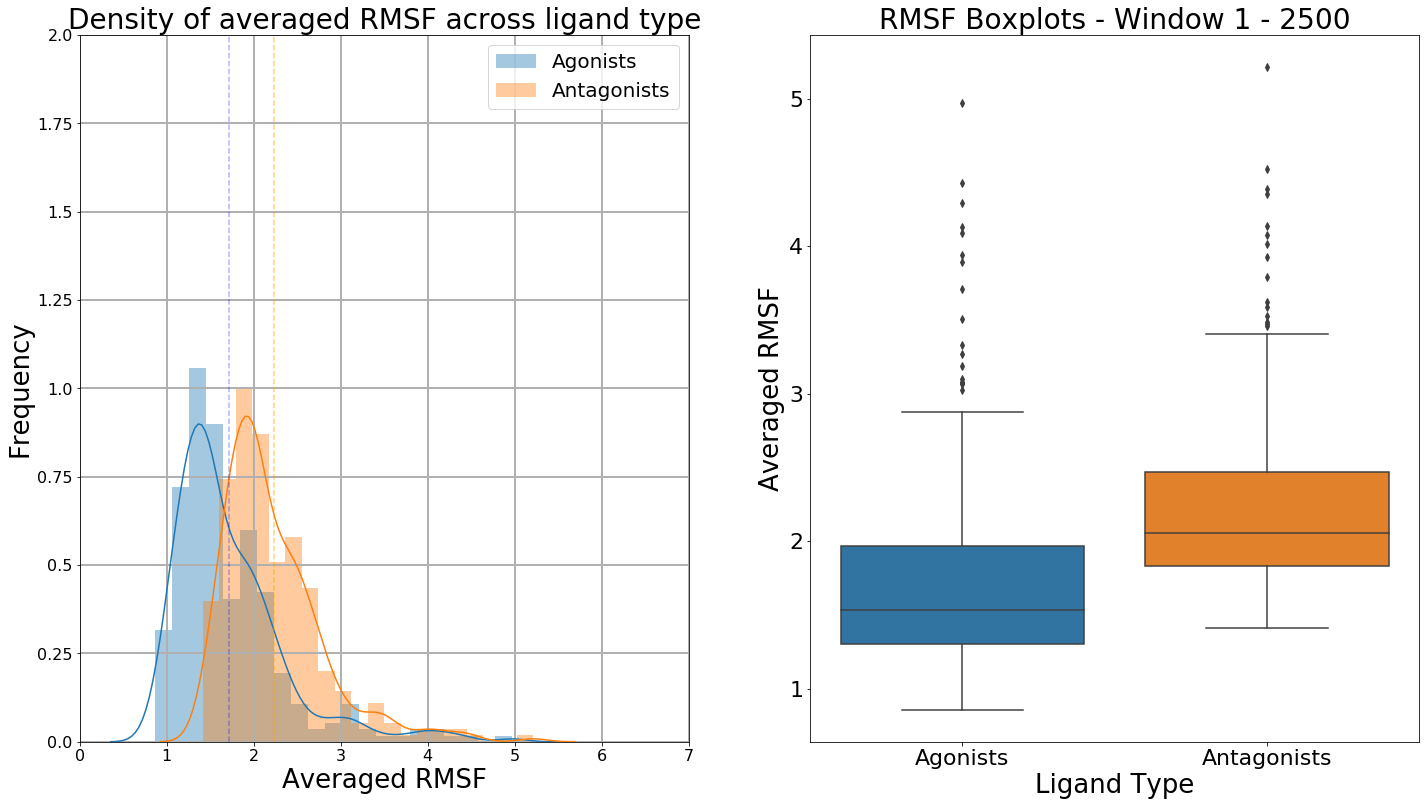

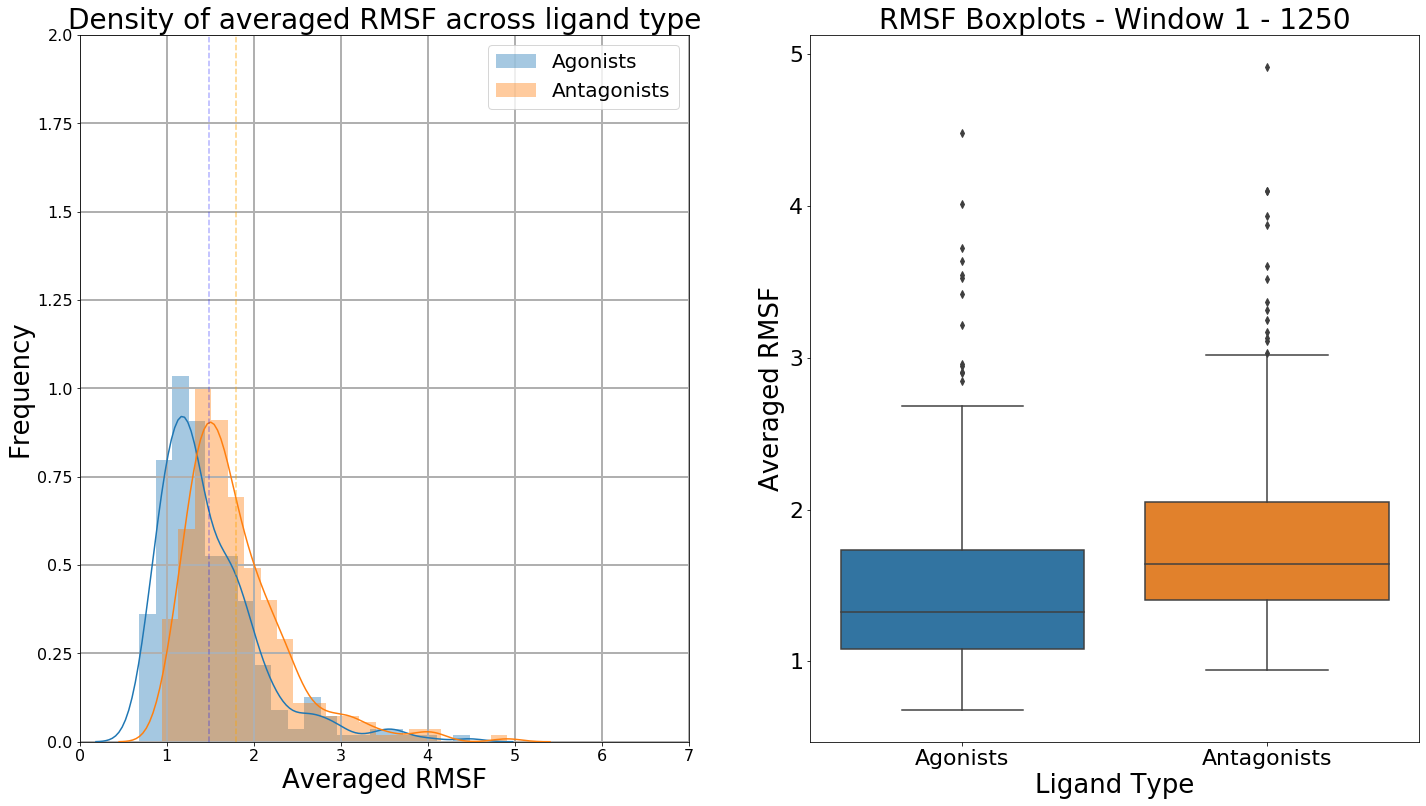

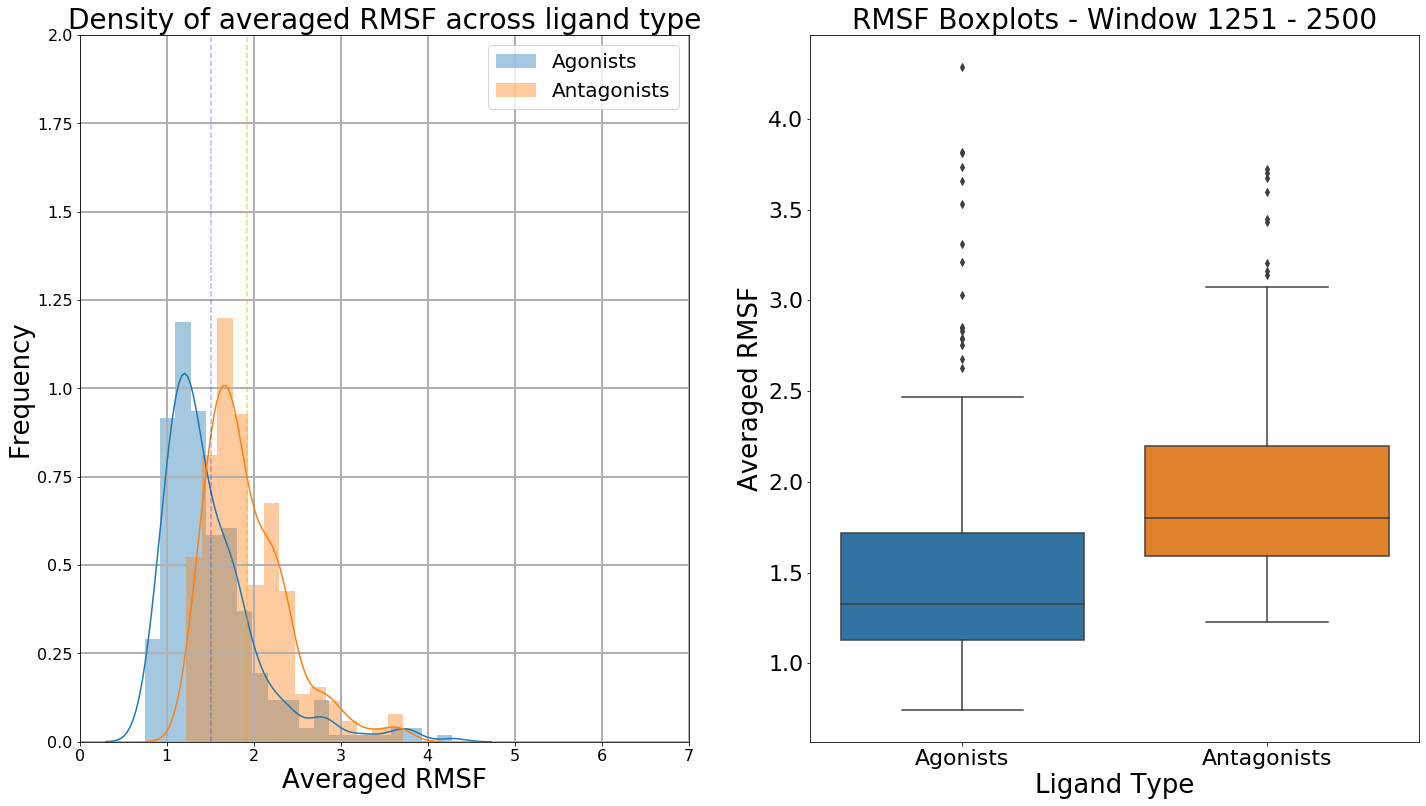

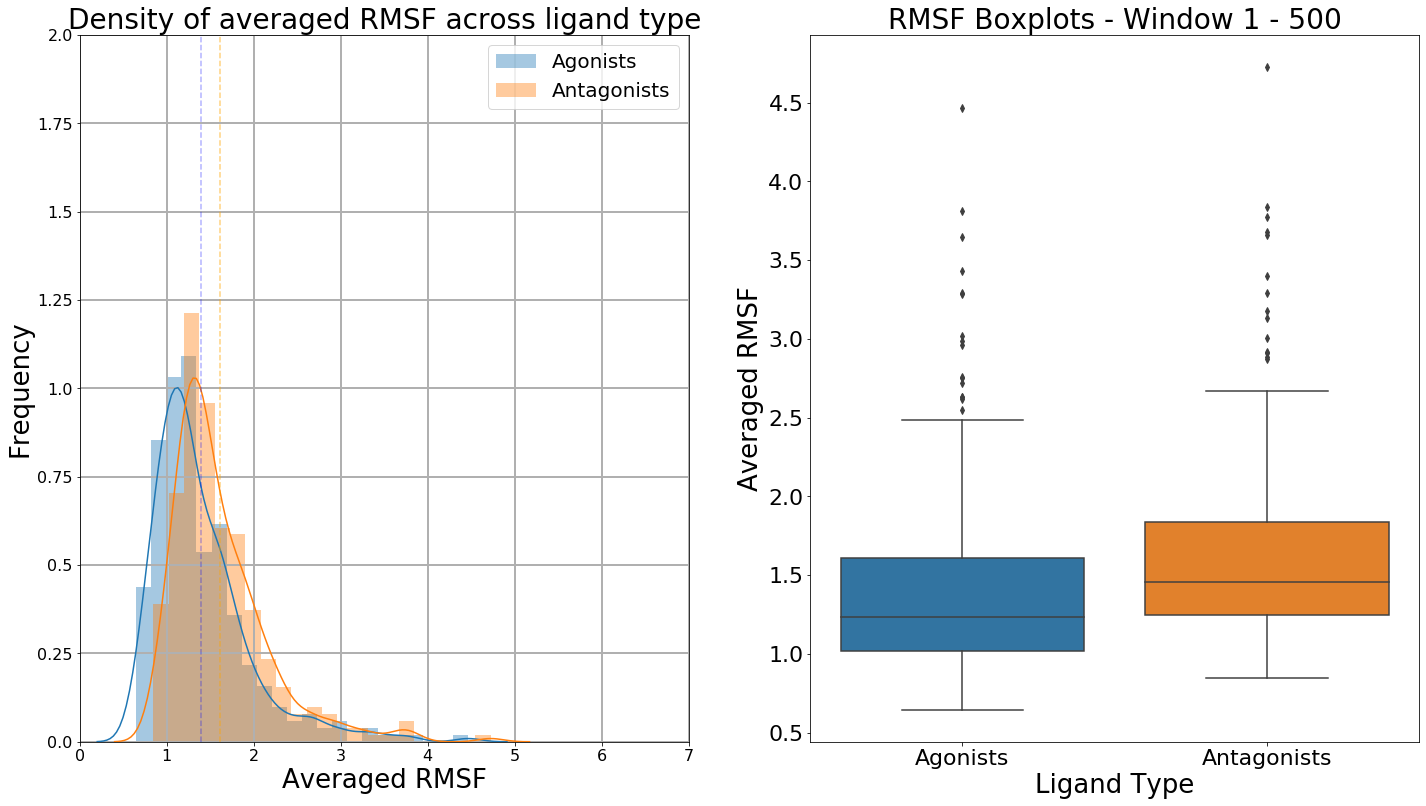

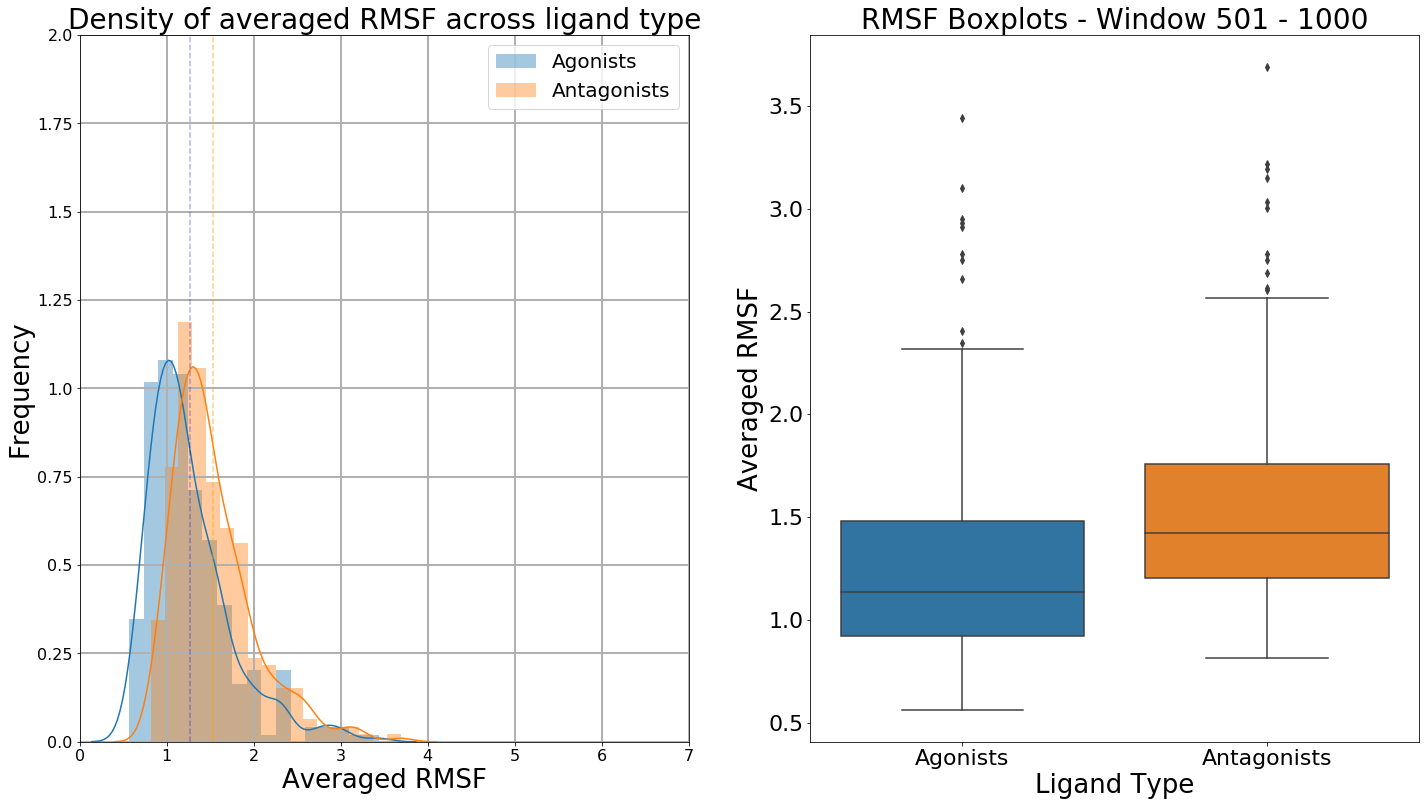

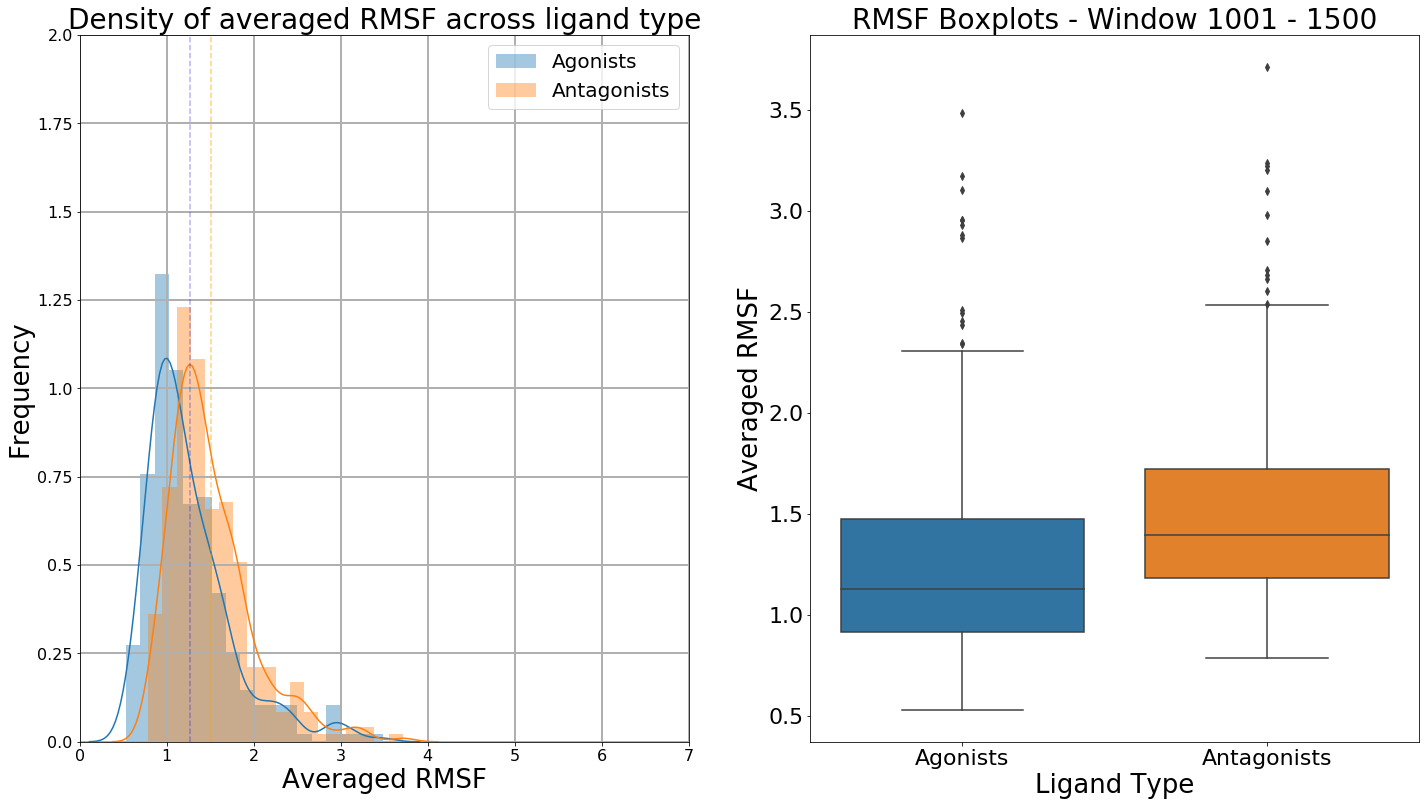

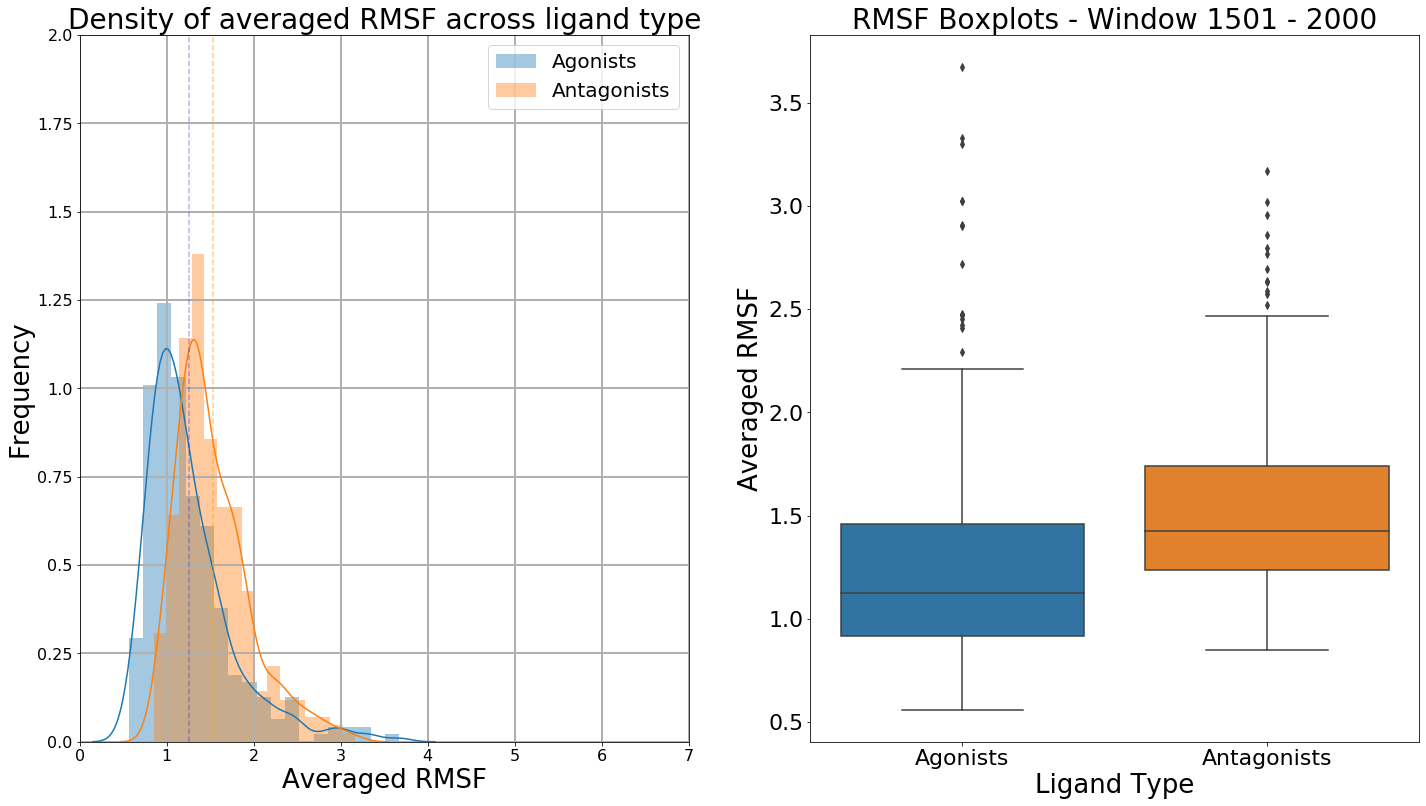

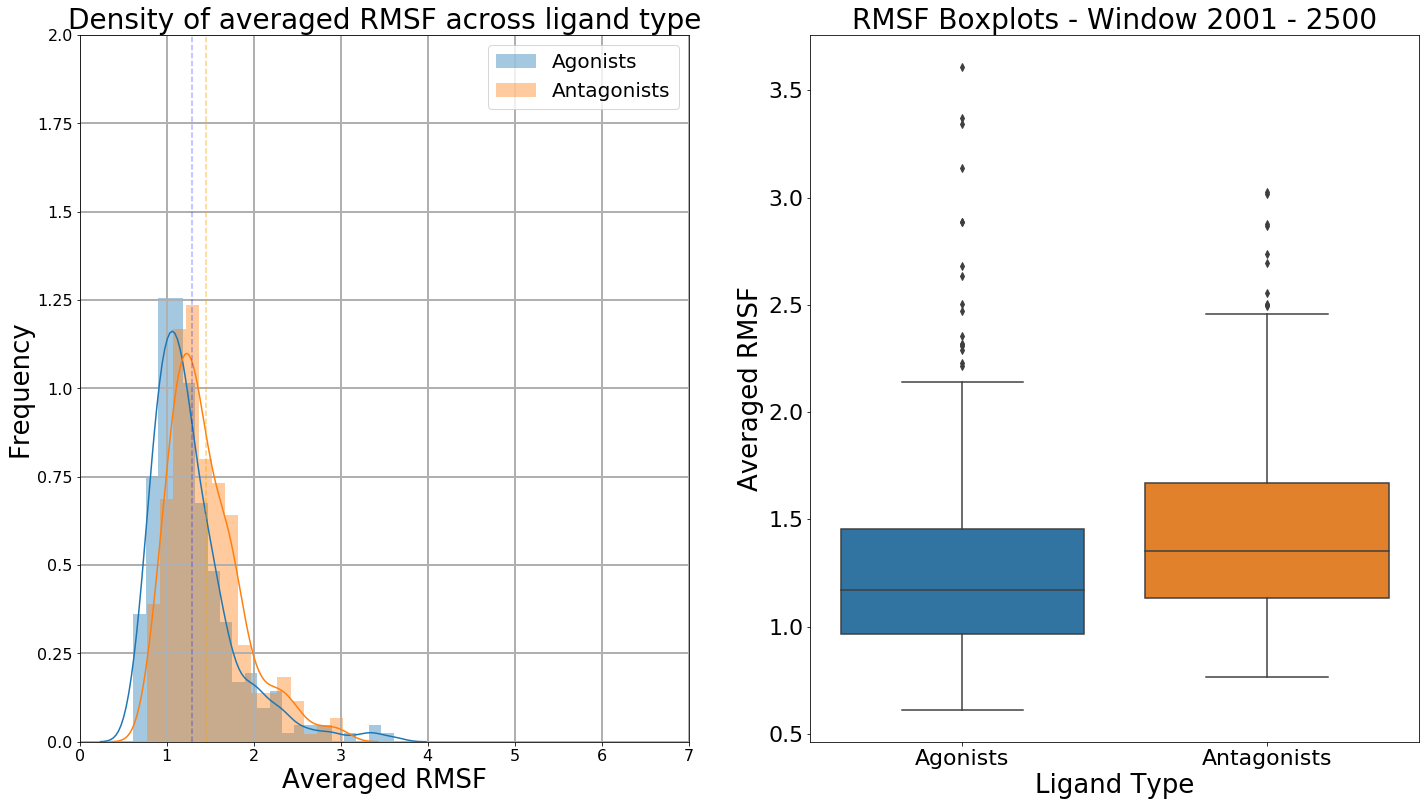

In [12]:
def calculate_average_cols_rmsf(analysis_actors_dict, start, stop, rmsf_cache=None):
    '''
    Calculates the mean of the mean residue RMSF for the agonists.
    Then does the same for the antagonists.
    
    Args:
        analysis_actors_dict: Dict(
                                "Agonists": List[AnalysisActor.class]
                                "Antagonists": List[AnalysisActor.class]
                              )
    
    Returns:
        Tuple(np.array[#frames], np.array[#frames])
    '''
    reset_rmsf_calculations(analysis_actors_dict, start, stop, rmsf_cache)
    
    # Agonists Iteration
    stacked_agonists = get_avg_rmsf_per_residue(analysis_actors_dict['Agonists'][0])
    for which_ligand in analysis_actors_dict['Agonists'][1:]:
        stacked_agonists = np.vstack((stacked_agonists, get_avg_rmsf_per_residue(which_ligand)))
    avg_agonists_cols = np.mean(stacked_agonists, axis=0)
    
    # Antagonists Iteration
    stacked_antagonists = get_avg_rmsf_per_residue(analysis_actors_dict['Antagonists'][0])
    for which_ligand in analysis_actors_dict['Antagonists'][1:]:
        stacked_antagonists = np.vstack((stacked_antagonists, get_avg_rmsf_per_residue(which_ligand)))
    avg_antagonists_cols = np.mean(stacked_antagonists, axis=0)

    return (avg_agonists_cols, avg_antagonists_cols)


def density_all_residues(start, stop, agon_rmsf_residue_avg, antagon_rmsf_residue_avg):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(24,13))

    # Decide if there is a significant difference in the mean of agonists and antagonists
    # using a t-test. We could also use a Kolmogorov-Smirnov test although I think in our case
    # will not make difference.
    __, pvalue = stats.ttest_ind(agon_rmsf_residue_avg, 
                                 antagon_rmsf_residue_avg, 
                                 equal_var=False)
    significant_difference = "Yes" if pvalue < 0.05 else "No"

    # Plot the density functions
    ax = sns.distplot(agon_rmsf_residue_avg, color="tab:blue", ax=axs[0], label="Agonists")
    ax = sns.distplot(antagon_rmsf_residue_avg, color="tab:orange", ax=axs[0], label="Antagonists")
    ax.grid(linewidth=2)
    ax.axvline(x = np.mean(agon_rmsf_residue_avg), color="blue", alpha=0.3, ls="--")    # Vline showing mean of agonists
    ax.axvline(x = np.mean(antagon_rmsf_residue_avg), color="orange", alpha=0.5, ls="--")    # Vline showing mean of antagonists

    ax.set(xlabel='Averaged RMSF', ylabel='Frequency')
    ax.set_title(f"Density of averaged RMSF across ligand type", fontsize=28)
    ax.xaxis.label.set_size(26)
    ax.yaxis.label.set_size(26)
    
    ax.set_xticklabels(np.arange(0, 8, 1), fontsize=16)
    ax.set_yticklabels(np.arange(0, 2.25, 0.25), fontsize=16)
    ax.set_ylim(0, 2)
    ax.set_xlim(0, 7)
    ax.legend(prop={'size': 20}, markerscale=2, loc=1)

    # Plot the boxplots
    boxplots_df = pd.DataFrame(np.array([agon_rmsf_residue_avg, 
                                         antagon_rmsf_residue_avg]).T, 
                                         columns=['Agonists', 'Antagonists'])
    ax = sns.boxplot(data=boxplots_df, ax=axs[1])
    ax.set(xlabel='Ligand Type', ylabel='Averaged RMSF')
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    ax.xaxis.label.set_size(26)
    ax.yaxis.label.set_size(26)
    
    ax.set_title(f"RMSF Boxplots - Window {start + 1} - {stop}", fontsize=28)
    
    plt.savefig(f"../figures/RMSF/final/density_all_residues/rmsf_density_boxplots_{start}_{stop}.png", bbox_inches='tight')
    plt.show()
    
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue
from MDSimsEval.rmsf_analysis import reset_rmsf_calculations

agon_rmsf_residue_avg, antagon_rmsf_residue_avg = calculate_average_cols_rmsf(train_analysis_actors_dict, 0, 2500, rmsf_cache)
density_all_residues(0, 2500, agon_rmsf_residue_avg, antagon_rmsf_residue_avg)

agon_rmsf_residue_avg, antagon_rmsf_residue_avg = calculate_average_cols_rmsf(train_analysis_actors_dict, 0, 1250, rmsf_cache)
density_all_residues(0, 1250, agon_rmsf_residue_avg, antagon_rmsf_residue_avg)
agon_rmsf_residue_avg, antagon_rmsf_residue_avg = calculate_average_cols_rmsf(train_analysis_actors_dict, 1250, 2500, rmsf_cache)
density_all_residues(1250, 2500, agon_rmsf_residue_avg, antagon_rmsf_residue_avg)

for start in np.arange(0, 2500, 500):
    agon_rmsf_residue_avg, antagon_rmsf_residue_avg = calculate_average_cols_rmsf(train_analysis_actors_dict, start, start + 500, rmsf_cache)
    density_all_residues(start, start + 500, agon_rmsf_residue_avg, antagon_rmsf_residue_avg)
    

### Baseline Model

In [14]:
from MDSimsEval.rmsf_analysis import reset_rmsf_calculations
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue


class BaselineClassifierAggregatedResidues:
    """
    This simple model fits on the training data by calculating the average RMSF value of the agonist and the 
    antagonist sets. The RMSF is calculated on the residues given and aggregated to one value. This means that for
    the agonists we calculate the average/median value for each residue and then we aggregate again ending with a
    scalar.
    
    Attributes:
        start (int): The starting frame of the window 
        stop (int): The last frame of the window
        method (func): Function that we will use for summarizing each residue, eg `np.mean`, `np.median`
        agonist_baseline (float): The aggregated RMSF value of the agonist class 
        antagonist_baseline (float): The aggregated RMSF value of the antagonist class
        selected_residues (List[boolean]): A list of size total_residues, where True on the indexes of the residue ids selected
        
    """
    def __init__(self, start, stop, rmsf_cache, method=np.mean):
        self.start = start
        self.stop = stop
        self.method = method
        self.rmsf_cache = rmsf_cache
        self.selected_residues = None
        self.agonist_baseline = None
        self.antagonist_baseline = None

    def fit(self, train_analysis_actors, residues):
        """
        The function that initializes the aggregated RMSF value for each class.

        Args:
            train_analysis_actors: ``{ "Agonists": List[AnalysisActor.class], "Antagonists": List[AnalysisActor.class] }``
            residues (List[int]): A list of residue ids that the model will use. For all the residues
                                  give ``np.arange(290)`` .

        """
        reset_rmsf_calculations(train_analysis_actors, start, stop, rmsf_cache)
        
        # Create a mask of the residues selected
        self.selected_residues = [which_res in residues for which_res in np.arange(290)]

        # Calculating baseline agonist RMSF value
        stacked_agonists = get_avg_rmsf_per_residue(train_analysis_actors['Agonists'][0])[self.selected_residues]
        for which_ligand in train_analysis_actors['Agonists'][1:]:
            stacked_agonists = np.vstack(
                (stacked_agonists, get_avg_rmsf_per_residue(which_ligand)[self.selected_residues]))
        self.agonist_baseline = self.method(stacked_agonists)

        # Calculating baseline antagonist RMSF value
        stacked_antagonists = get_avg_rmsf_per_residue(train_analysis_actors['Antagonists'][0])[
            self.selected_residues]
        for which_ligand in train_analysis_actors['Antagonists'][1:]:
            stacked_antagonists = np.vstack(
                (stacked_antagonists, get_avg_rmsf_per_residue(which_ligand)[self.selected_residues]))
        self.antagonist_baseline = self.method(stacked_antagonists)

    def predict(self, ligand):
        """
        Checks the distance of the unkwnown ligand fron the agonist and antagonist averages and returns 
        as a label the class that is closest.

        Args:
            ligand (AnalysisActorClass): The ligand we want to predict its class

        Returns:
            The class label, 1 for Agonist, 0 for Antagonist.

        """
        # We do a trick and create a Dict of ligands so as to use reset_rmsf_calculations
        reset_rmsf_calculations({'Agonists': [ligand], 'Antagonists': []}, self.start, self.stop, self.rmsf_cache)

        rmsf_value = np.mean(get_avg_rmsf_per_residue(ligand)[self.selected_residues])

        agon_distance = np.abs(self.agonist_baseline - rmsf_value)
        antagon_distance = np.abs(self.antagonist_baseline - rmsf_value)

        # Perform the majority voting
        if agon_distance < antagon_distance:
            return 1  # Case agonist
        else:
            return 0  # Case antagonist

### Majority Voting Baseline

In [10]:
from MDSimsEval.rmsf_analysis import reset_rmsf_calculations
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue

class MajorityBaselineClassifierRMSF:
    """
    Used for evaluating residue selections based on their RMSF.
    
    This is a simple baseline model able to quantify how good our residue selection is.
    Given a k - k training set of agonists - antagonists,for an unknown ligand
    we iterate through the residues. If the residue is closer to the median/average of the
    training agonists (of the RMSF values of the specific residue) then the residue votes that 
    the ligand is an agonist. Else it votes that the ligand is an antagonist.
    | 
    | At then end we see which class had the most votes.
    
    Attributes:
        start (int): The starting frame of the window 
        stop (int): The last frame of the window
        method (func): Function that we will use for summarizing each residue, eg `np.mean`, `np.median`
        agonist_residue_baseline (List[float]): A list of the aggregated RMSF value of the agonists of each residue  
        antagonist_residue_baseline (List[float]): A list of the aggregated RMSF value of the antagonists of each residue
        selected_residues (List[boolean]): A list of size total_residues, where True on the indexes of the residue ids selected
        
    """
    def __init__(self, start, stop, rmsf_cache, method=np.mean):
        self.start = start
        self.stop = stop
        self.method = method
        self.rmsf_cache = rmsf_cache
        self.selected_residues = None
        
        
    def fit(self, train_analysis_actors, residues):
        """
        The function that initializes the aggregated RMSF value for each residue for each class.
        
        Args:
            train_analysis_actors: ``{ "Agonists": List[AnalysisActor.class], "Antagonists": List[AnalysisActor.class] }``
            residues (List[int]): A list of residue ids that the model will use. Default is using all the residues.
            
        """
        reset_rmsf_calculations(train_analysis_actors, self.start, self.stop, self.rmsf_cache)
        
        # Create a mask of the residues selected
        self.selected_residues = [which_res in residues for which_res in np.arange(290)]

        # Calculating baseline agonist RMSF value
        stacked_agonists = get_avg_rmsf_per_residue(train_analysis_actors['Agonists'][0])[self.selected_residues]
        for which_ligand in train_analysis_actors['Agonists'][1:]:
            stacked_agonists = np.vstack((stacked_agonists, get_avg_rmsf_per_residue(which_ligand)[self.selected_residues]))
        self.agonist_residue_baseline = self.method(stacked_agonists, axis=0)

        # Calculating baseline antagonist RMSF value
        stacked_antagonists = get_avg_rmsf_per_residue(train_analysis_actors['Antagonists'][0])[self.selected_residues]
        for which_ligand in train_analysis_actors['Antagonists'][1:]:
            stacked_antagonists = np.vstack((stacked_antagonists, get_avg_rmsf_per_residue(which_ligand)[self.selected_residues]))
        self.antagonist_residue_baseline = self.method(stacked_antagonists, axis=0)
        
        
    def predict(self, ligand):
        """
        Performs the majority voting and returns the predicted class.
        
        Args:
            ligand (AnalysisActorClass): The ligand we wnat to predict its class
            
        Returns:
            The class label, 1 for Agonist, 0 for Antagonist.
            
        """
        # We do a trick and create a Dict of ligands so as to use reset_rmsf_calculations
        reset_rmsf_calculations({'Agonists':[ligand], 'Antagonists':[]}, self.start, self.stop, self.rmsf_cache)
        
        rmsf_values = get_avg_rmsf_per_residue(ligand)[self.selected_residues]
        
        agon_distances = np.abs(self.agonist_residue_baseline - rmsf_values)
        antagon_distances = np.abs(self.antagonist_residue_baseline - rmsf_values)
                
        # Perform the majority voting
        if np.sum(agon_distances < antagon_distances) > np.sum(self.selected_residues) / 2:
            return 1    # Case agonist
        else:
            return 0    # Case antagonist
        

In [9]:
def calcuate_accuracy(model, ligands_dict):
    acc = 0
    for which_agon in ligands_dict['Agonists']:
        label = model.predict(which_agon)
        if label == 1:
            acc += 1
    
    for which_antagon in ligands_dict['Antagonists']:
        label = model.predict(which_antagon)
        if label == 0:
            acc += 1
            
    return acc / (len(ligands_dict['Agonists']) + len(ligands_dict['Antagonists'])) * 100

In [3]:
from MDSimsEval.rmsf_baseline_models import bootstrap_dataset
from MDSimsEval.rmsf_baseline_models import BaselineClassifierAggregatedResidues

train_dicts, validation_dicts = bootstrap_dataset(analysis_actors_dict, 2, 20)

total_metrics = {}

for start, stop in windows:
    accs = []
    model = BaselineClassifierAggregatedResidues(start, stop, rmsf_cache, np.mean)
    for train_dict, validation_dict in tqdm(list(zip(train_dicts, validation_dicts)), desc=f'Window {start} - {stop}'):
        model.fit(train_dict, np.arange(290))
        
        accs.append([calculate_accuracy(model, train_dict), calculate_accuracy(model, validation_dict)])
    
    accs = np.array(accs)
    mean_accs = np.mean(accs, axis=0)
    sem_accs = stats.sem(accs, axis=0)
    
    total_metrics[f'{start} - {stop}'] = [mean_accs[0], mean_accs[1], sem_accs[0], sem_accs[1]]
    
display(pd.DataFrame.from_dict(metrics, orient='index', columns=['Mean Train Accuracy', 'Mean Test Accuracy', 'Stde Train Accuracy', 'Stde Test Accuracy']).round(decimals=2))

/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:259: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:260: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:261: RuntimeWarning: invalid value encountered in double_scalars
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:264: RuntimeWarning: invalid value encountered in greater
  if np.all(box > 0.0) and alpha < 180.0 and beta < 180.0 and gamma < 180.0:


NameError: name 'calcuate_accuracy' is not defined

In [36]:
def bootstrap_dataset(analysis_actors_dict, samples, sample_size):
    """
    Creates a given number of bootstrapped samples of the Agonist - Antagonist dataset.
    | Also the remaining ligands are returned as a validation set.
    | Eg if sample_size = 20 and on each class we have 27 ligands, then we create 
    a dict of 20 - 20 unique ligands and the remaining 7 ligands are returned as a validation set.
    
    Args:
        analysis_actors_dict: ``{ "Agonists": List[AnalysisActor.class], "Antagonists": List[AnalysisActor.class] }``
        samples (int): Number of bootstrapped samples generated
        sample_size (int): How many ligands of each class the training set will have
        
    Returns: 
        A tuple of a list of train ligands dictionaries and in the format of  ``{ "Agonists": List[AnalysisActor.class], "Antagonists": List[AnalysisActor.class] }``,
        the same for the test ligands
        
    """
    train_agonists_samples = [random.sample(analysis_actors_dict['Agonists'], k=sample_size) 
                              for i in np.arange(samples)]
    test_agonists_samples = [complement_residues(analysis_actors_dict['Agonists'], selected_ligands) 
                             for selected_ligands in train_agonists_samples]
    
    train_antagonists_samples = [random.sample(analysis_actors_dict['Antagonists'], k=sample_size) 
                              for i in np.arange(samples)]
    test_antagonists_samples = [complement_residues(analysis_actors_dict['Antagonists'], selected_ligands) 
                             for selected_ligands in train_antagonists_samples]
    
    # Merge the agonists and the antagonists to a dictionary which is the expected input
    # of classify_on_baseline method above
    train_actor_dicts = [{'Agonists':agonist_sample, 'Antagonists':antagonist_sample}
                         for agonist_sample, antagonist_sample in zip(train_agonists_samples, train_antagonists_samples)]
    
    test_actor_dicts = [{'Agonists':agonist_sample, 'Antagonists':antagonist_sample}
                         for agonist_sample, antagonist_sample in zip(test_agonists_samples, test_antagonists_samples)]

    return train_actor_dicts, test_actor_dicts

In [38]:
def calcuate_accuracy(model, ligands_dict):
    acc = 0
    for which_agon in ligands_dict['Agonists']:
        label = model.predict(which_agon)
        if label == 1:
            acc += 1
    
    for which_antagon in ligands_dict['Antagonists']:
        label = model.predict(which_antagon)
        if label == 0:
            acc += 1
            
    return acc / (len(ligands_dict['Agonists']) + len(ligands_dict['Antagonists'])) * 100

In [54]:
train_dicts, validation_dicts = bootstrap_dataset(analysis_actors_dict, 100, 20)

total_metrics = {}

for start, stop in windows:
    accs = []
    model = MajorityBaselineClassifierRMSF(start, stop, rmsf_cache, np.mean)
    for train_dict, validation_dict in tqdm(list(zip(train_dicts, validation_dicts)), desc=f'Window {start} - {stop}'):
        model.fit(train_dict)
        
        accs.append([calcuate_accuracy(model, train_dict), calcuate_accuracy(model, validation_dict)])
    
    accs = np.array(accs)
    mean_accs = np.mean(accs, axis=0)
    sem_accs = stats.sem(accs, axis=0)
    
    total_metrics[f'{start} - {stop}'] = [mean_accs[0], mean_accs[1], sem_accs[0], sem_accs[1]]

In [5]:
with open('cache/baseline_model_results/majority_acc_all_res_mean.pkl', 'rb') as handle:
    metrics = pickle.load(handle)

display(pd.DataFrame.from_dict(metrics, orient='index', columns=['Mean Train Accuracy', 'Mean Test Accuracy', 'Stde Train Accuracy', 'Stde Test Accuracy']).round(decimals=2))

Mean Train Accuracy  Mean Test Accuracy  Stde Train Accuracy  \
0 - 2500                   68.00               67.50                 0.41   
0 - 1250                   66.30               67.71                 0.38   
1250 - 2500                66.70               66.57                 0.38   
0 - 500                    66.30               67.71                 0.38   
500 - 1000                 66.30               67.71                 0.38   
1000 - 1500                66.30               67.71                 0.38   
1500 - 2000                68.20               69.43                 0.39   
2000 - 2500                62.75               64.07                 0.40   

             Stde Test Accuracy  
0 - 2500                   1.10  
0 - 1250                   1.09  
1250 - 2500                1.09  
0 - 500                    1.09  
500 - 1000                 1.09  
1000 - 1500                1.09  
1500 - 2000                1.11  
2000 - 2500                1.05

## Top-k Selection

### Density plots and Boxplots

In [17]:
from MDSimsEval.rmsf_analysis import find_top_k
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue

def plot_top_k_residues(analysis_actors_dict, start, stop, top, rmsf_cache=None):
    residue_ids = find_top_k(analysis_actors_dict, start, stop, top, rmsf_cache).ResidueId
    
    stacked_agons_rmsf = np.array([get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Agonists']])
    stacked_antagons_rmsf = np.array([get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Antagonists']])
    
    top_stacked_agons_rmsf = stacked_agons_rmsf[:, np.array(residue_ids).astype('int')]
    top_stacked_antagons_rmsf = stacked_antagons_rmsf[:, np.array(residue_ids).astype('int')]
    
    avg_top_stacked_agons_rmsf = np.mean(top_stacked_agons_rmsf, axis=0)
    avg_top_stacked_antagons_rmsf = np.mean(top_stacked_antagons_rmsf, axis=0)
    
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(24,13))

    # Decide if there is a significant difference in the mean of agonists and antagonists
    # using a t-test. We could also use a Kolmogorov-Smirnov test although I think in our case
    # will not make difference.
    __, pvalue = stats.ttest_ind(avg_top_stacked_agons_rmsf, 
                                 avg_top_stacked_antagons_rmsf, 
                                 equal_var=False)
    significant_difference = "Yes" if pvalue < 0.05 else "No"

    print(significant_difference)
    
    # Plot the density functions
    ax = sns.distplot(avg_top_stacked_agons_rmsf, color="tab:blue", ax=axs[0], label="Agonists")
    ax = sns.distplot(avg_top_stacked_antagons_rmsf, color="tab:orange", ax=axs[0], label="Antagonists")
    ax.grid(linewidth=2)
    ax.axvline(x = np.mean(avg_top_stacked_agons_rmsf), color="blue", alpha=0.3, ls="--")    # Vline showing mean of agonists
    ax.axvline(x = np.mean(avg_top_stacked_antagons_rmsf), color="orange", alpha=0.5, ls="--")    # Vline showing mean of antagonists

    ax.set(xlabel='Averaged RMSF', ylabel='Frequency')
    ax.set_title(f"Density of averaged RMSF across ligand type", fontsize=28)
    ax.xaxis.label.set_size(26)
    ax.yaxis.label.set_size(26)
    
    ax.set_xticklabels(np.arange(0, 8, 1), fontsize=16)
    ax.set_yticklabels(np.arange(0, 2.25, 0.25), fontsize=16)
    ax.set_ylim(0, 2)
    ax.set_xlim(0, 7)
    ax.legend(prop={'size': 20}, markerscale=2, loc=1)

    # Plot the boxplots
    boxplots_df = pd.DataFrame(np.array([avg_top_stacked_agons_rmsf, 
                                         avg_top_stacked_antagons_rmsf]).T, 
                                         columns=['Agonists', 'Antagonists'])
    ax = sns.boxplot(data=boxplots_df, ax=axs[1])
    ax.set(xlabel='Ligand Type', ylabel='Averaged RMSF')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.xaxis.label.set_size(26)
    ax.yaxis.label.set_size(26)
    
    ax.set_title(f'Averaged RMSF Boxplots - Window {start + 1} - {stop}', fontsize=28)
    
    plt.savefig(f"../figures/RMSF/final/density_top/rmsf_density_boxplots_top_{top}_{start}_{stop}.png", bbox_inches='tight')
    plt.close()
    
for start in np.arange(0, 2500, 500):
    plot_top_k_residues(train_analysis_actors_dict, start, start + 500, 50, rmsf_cache)

for start in np.arange(0, 2500, 1250):
    plot_top_k_residues(train_analysis_actors_dict, start, start + 1250, 50, rmsf_cache)
    
plot_top_k_residues(analysis_actors_dict, 0, 2500, 50, rmsf_cache)

Yes
Yes
Yes
Yes
No
Yes
Yes
Yes


### Barplots

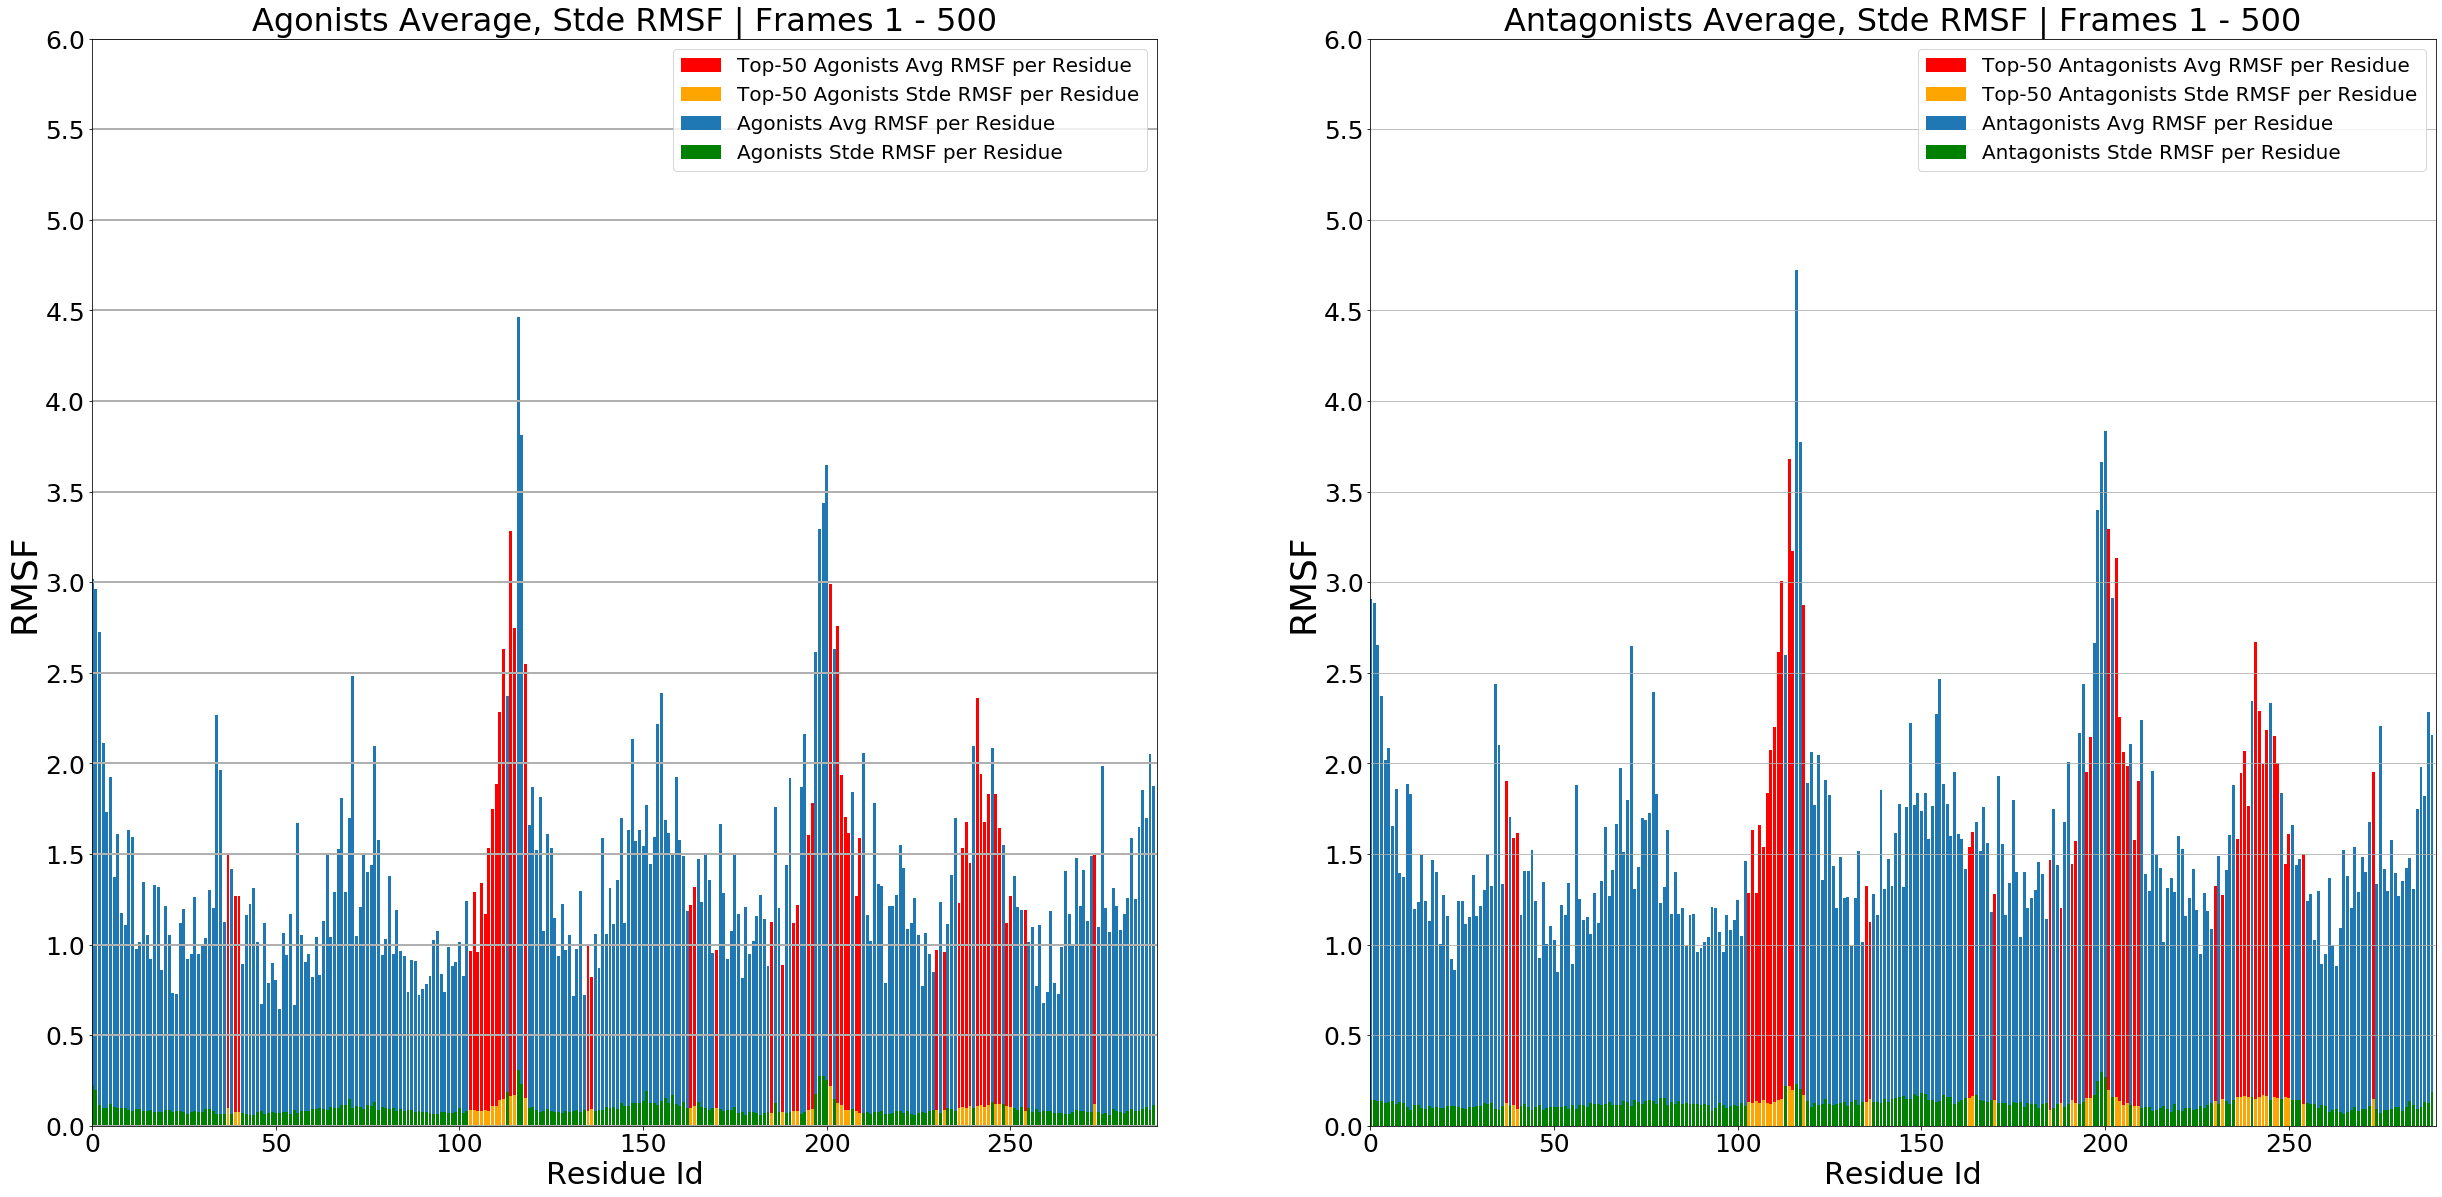

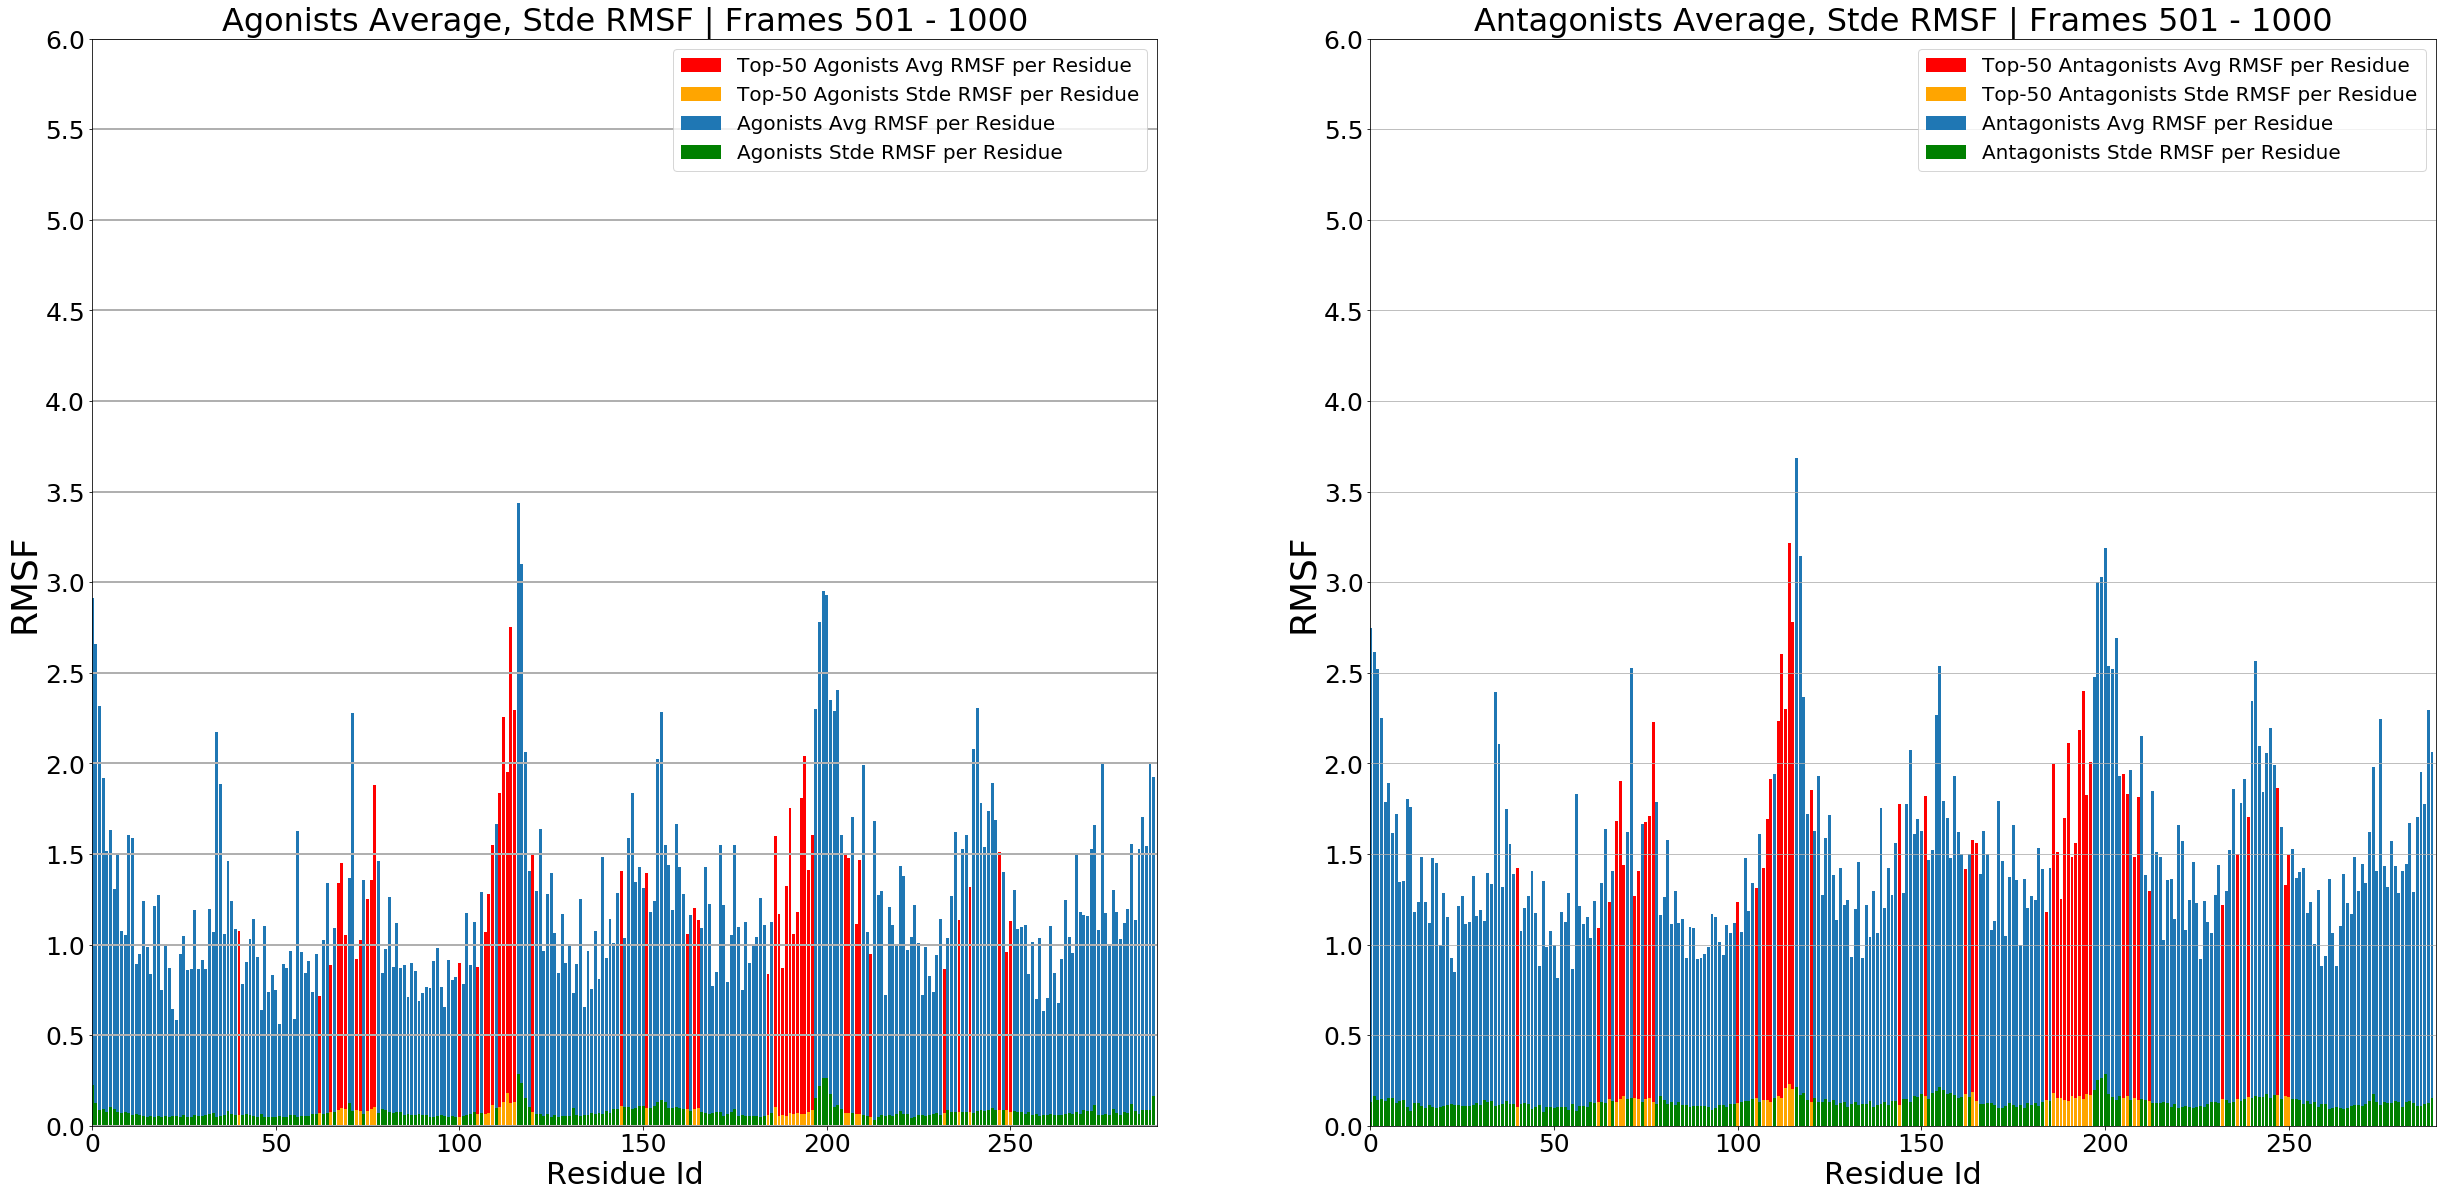

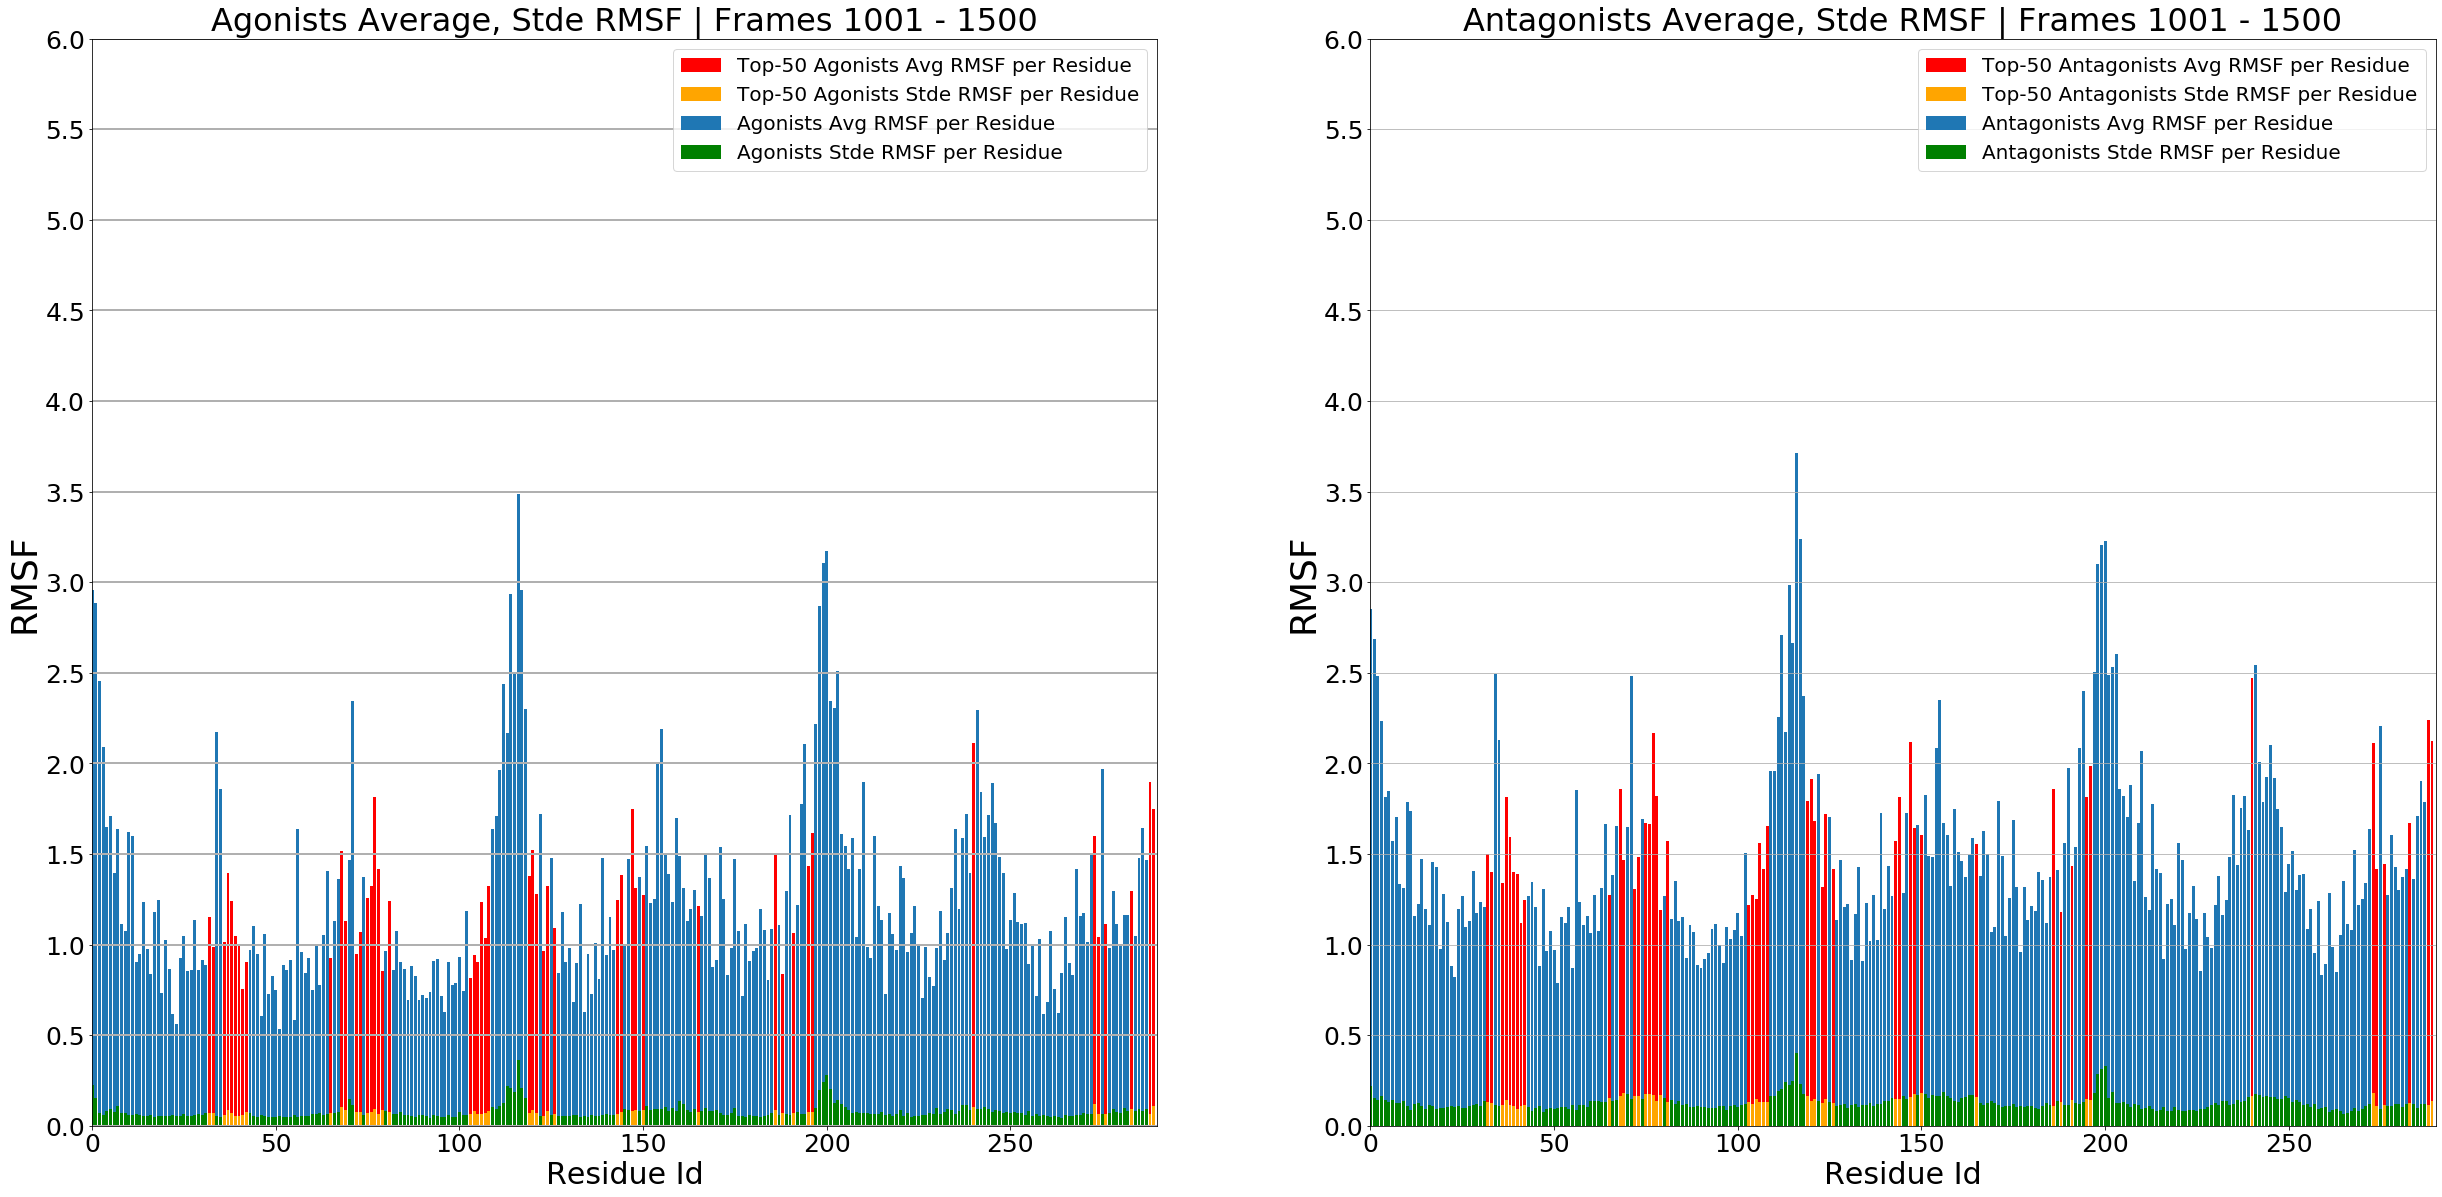

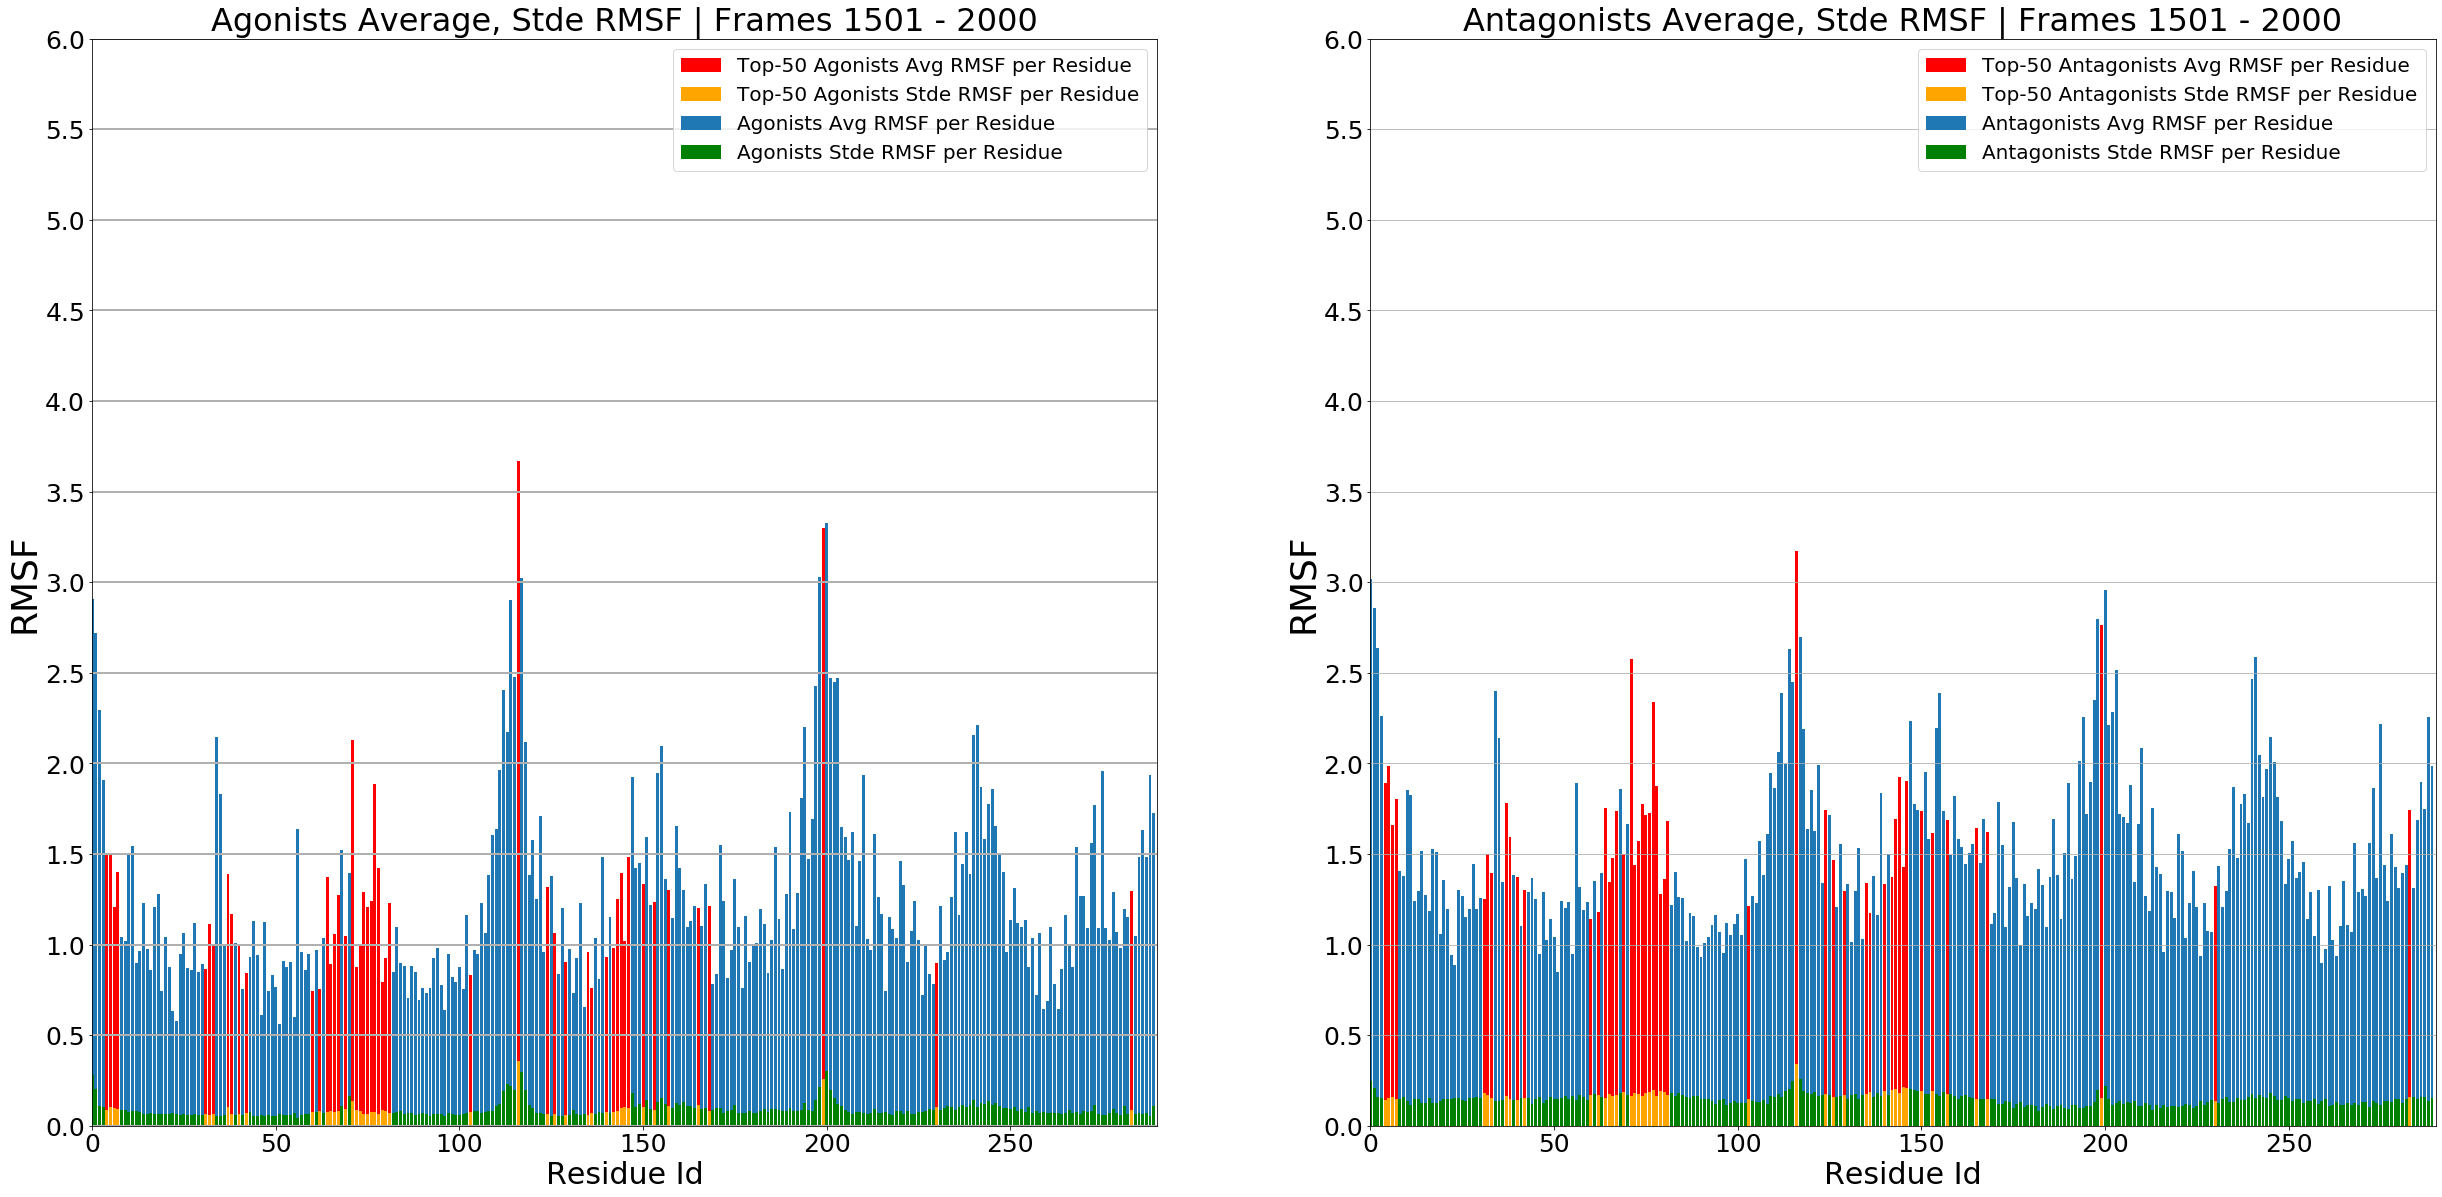

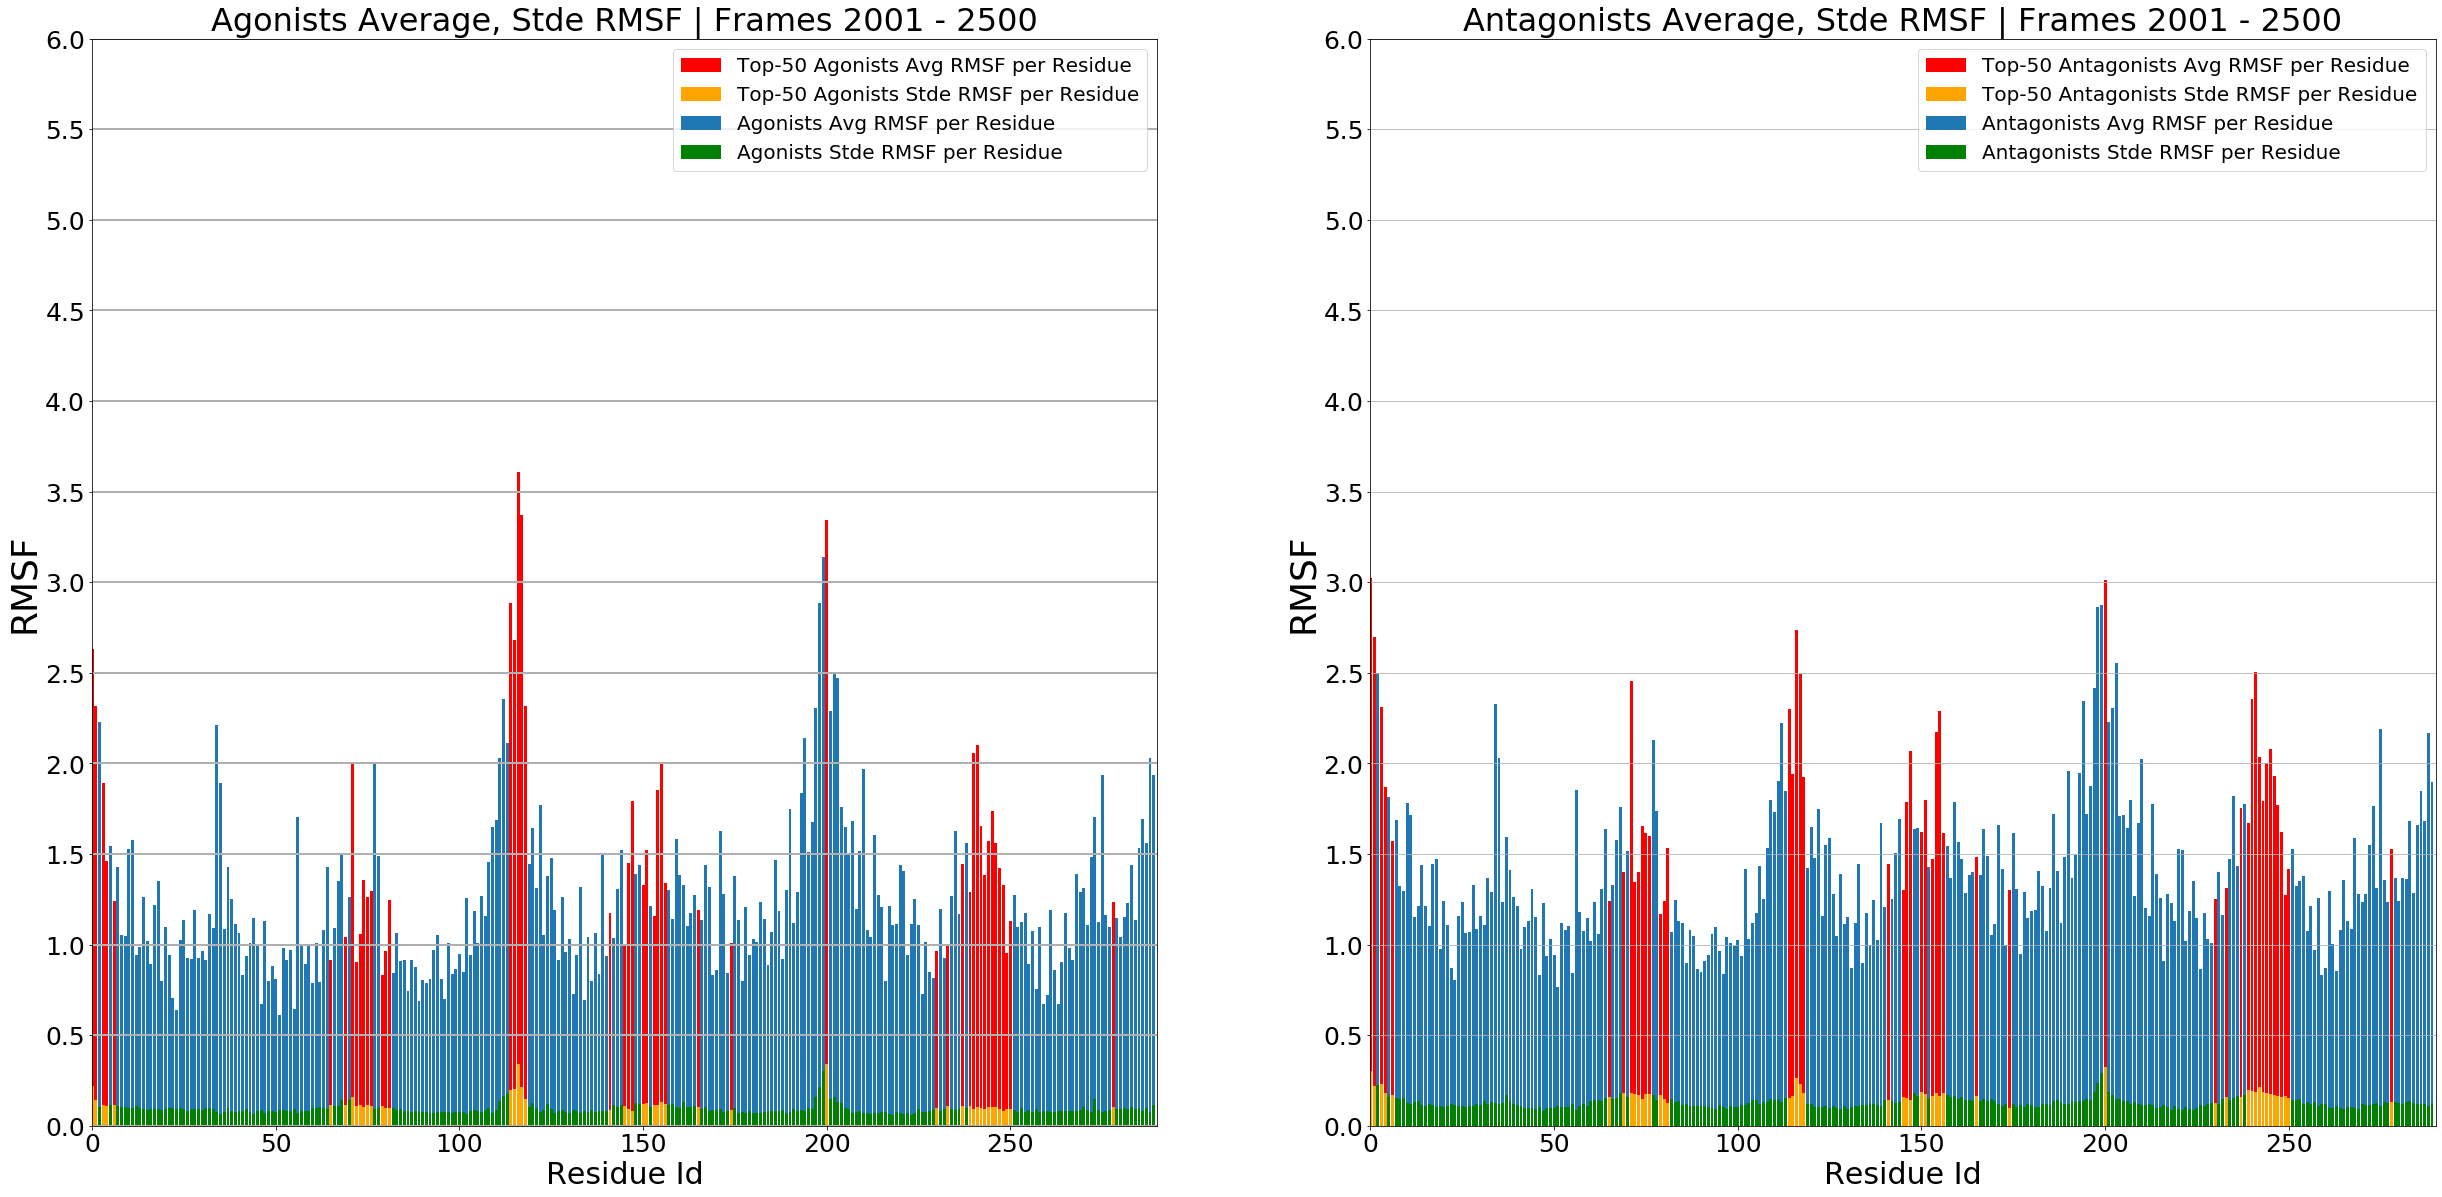

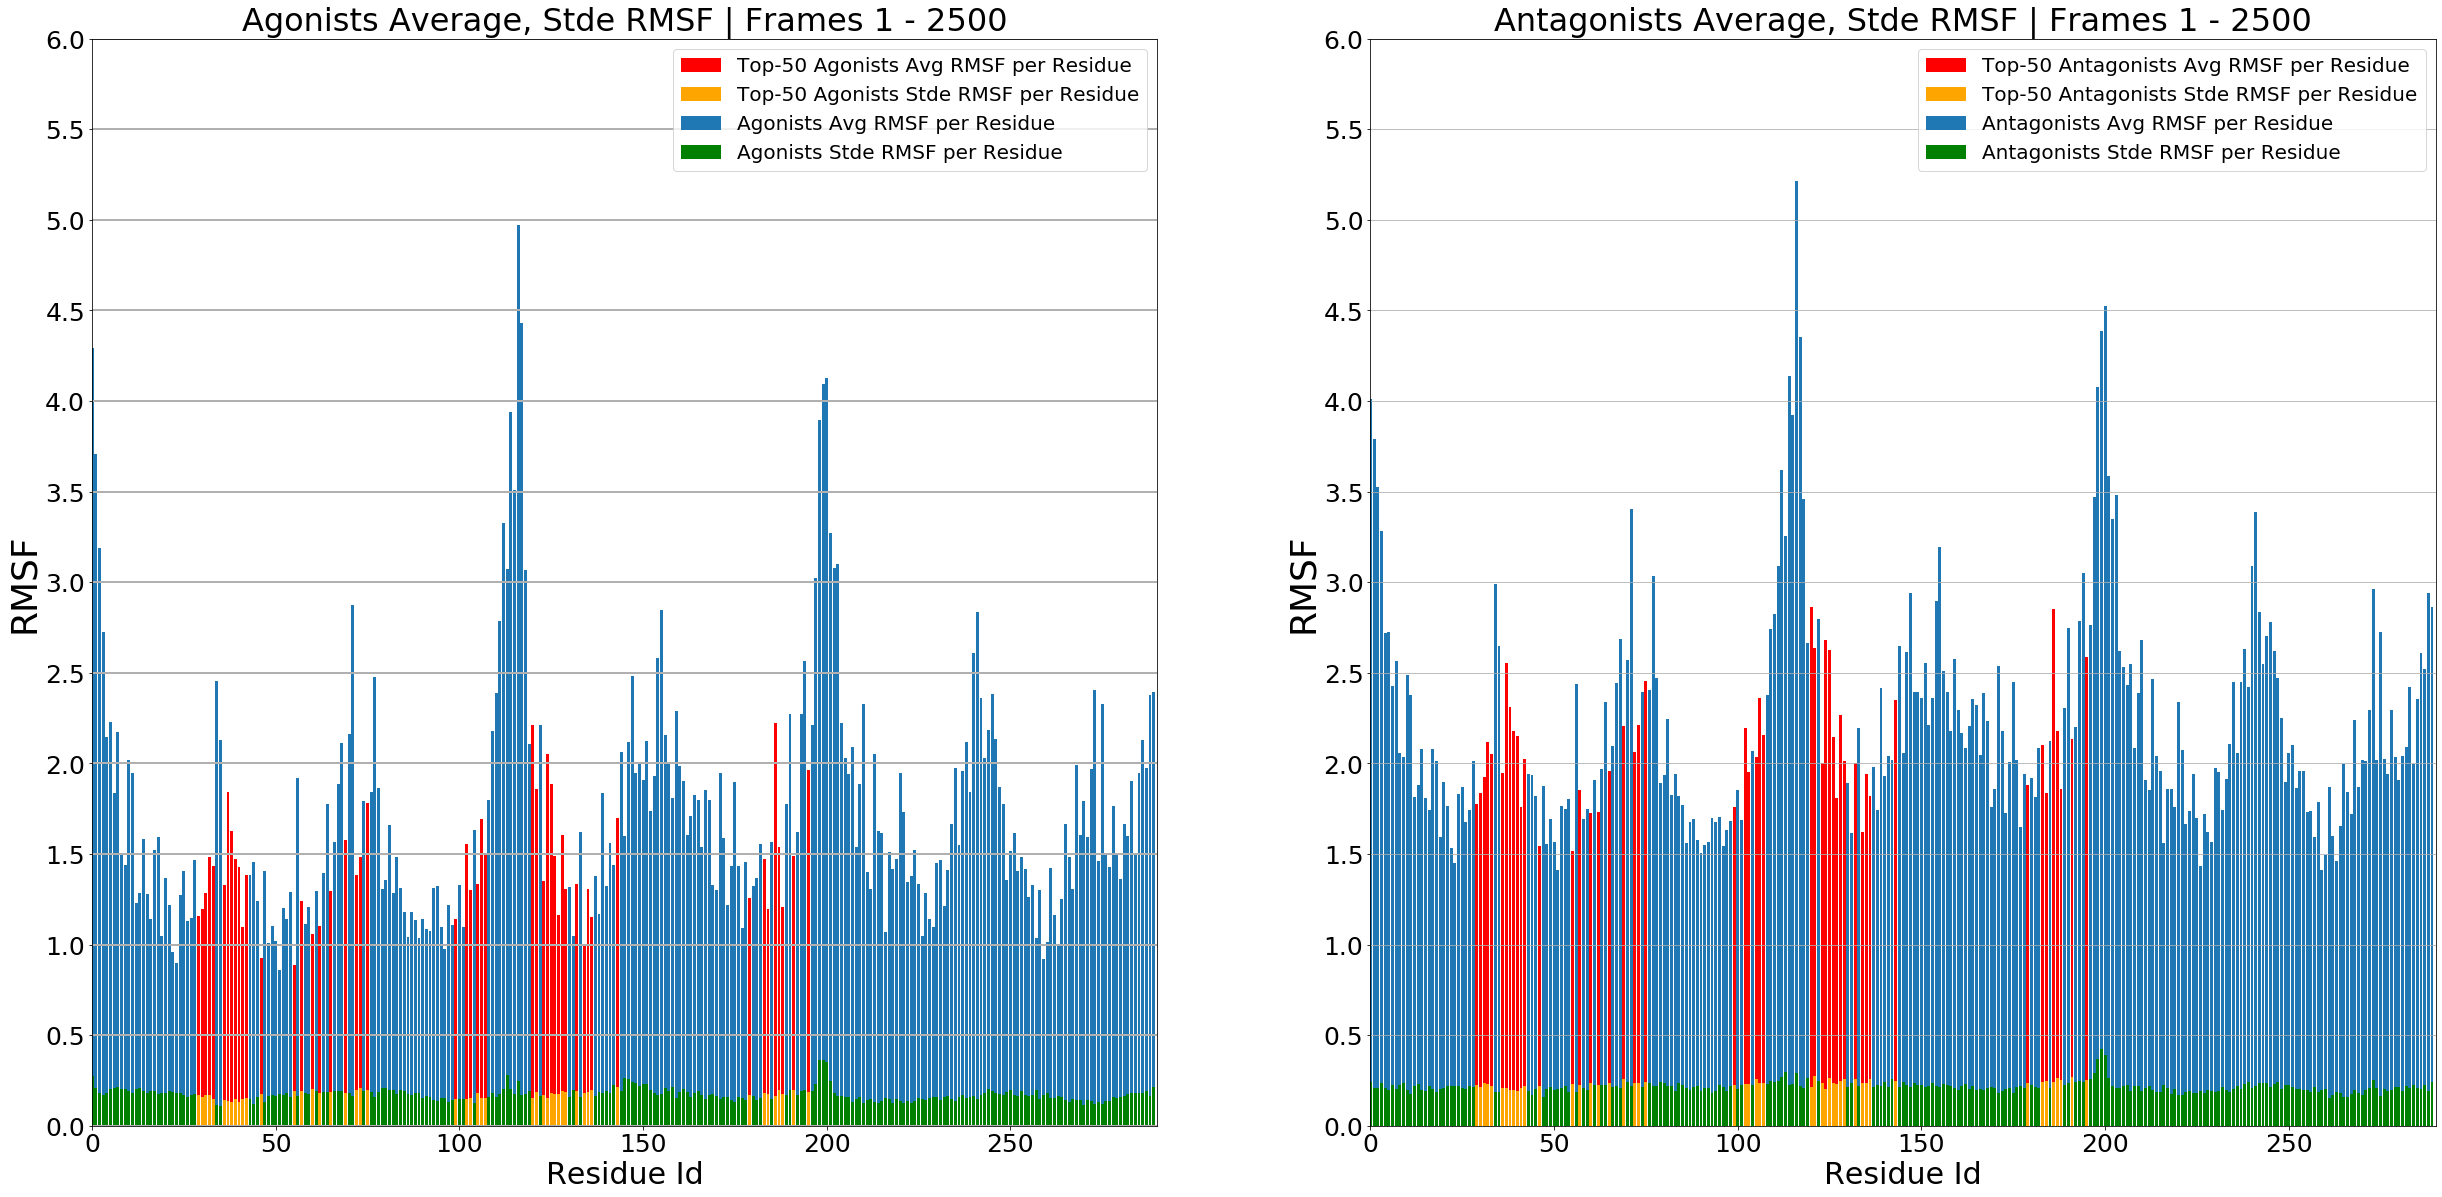

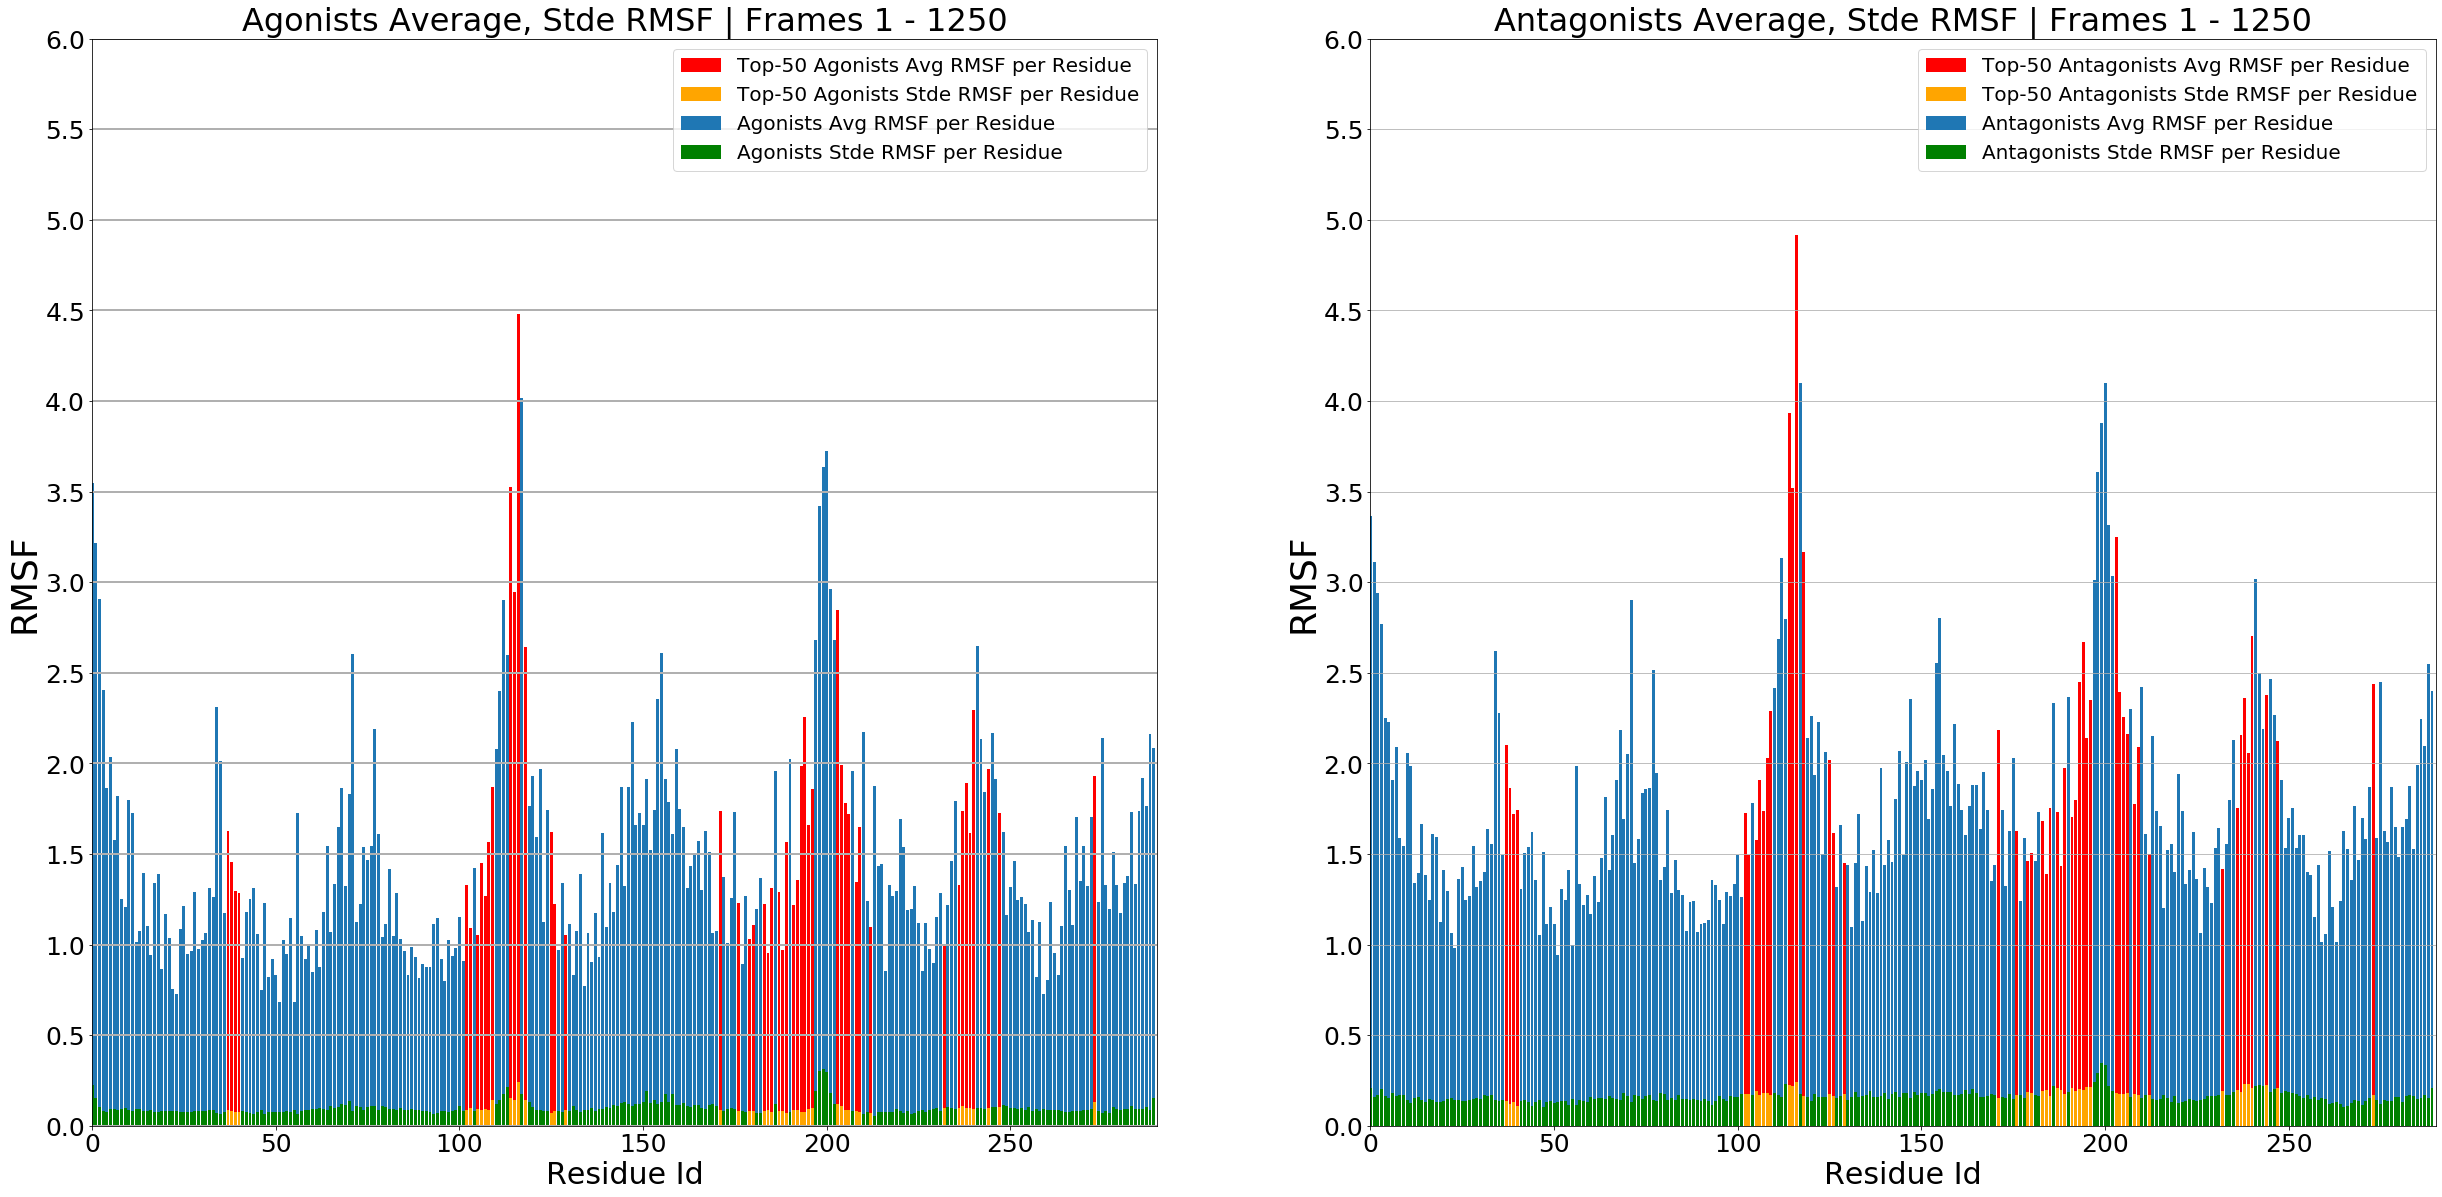

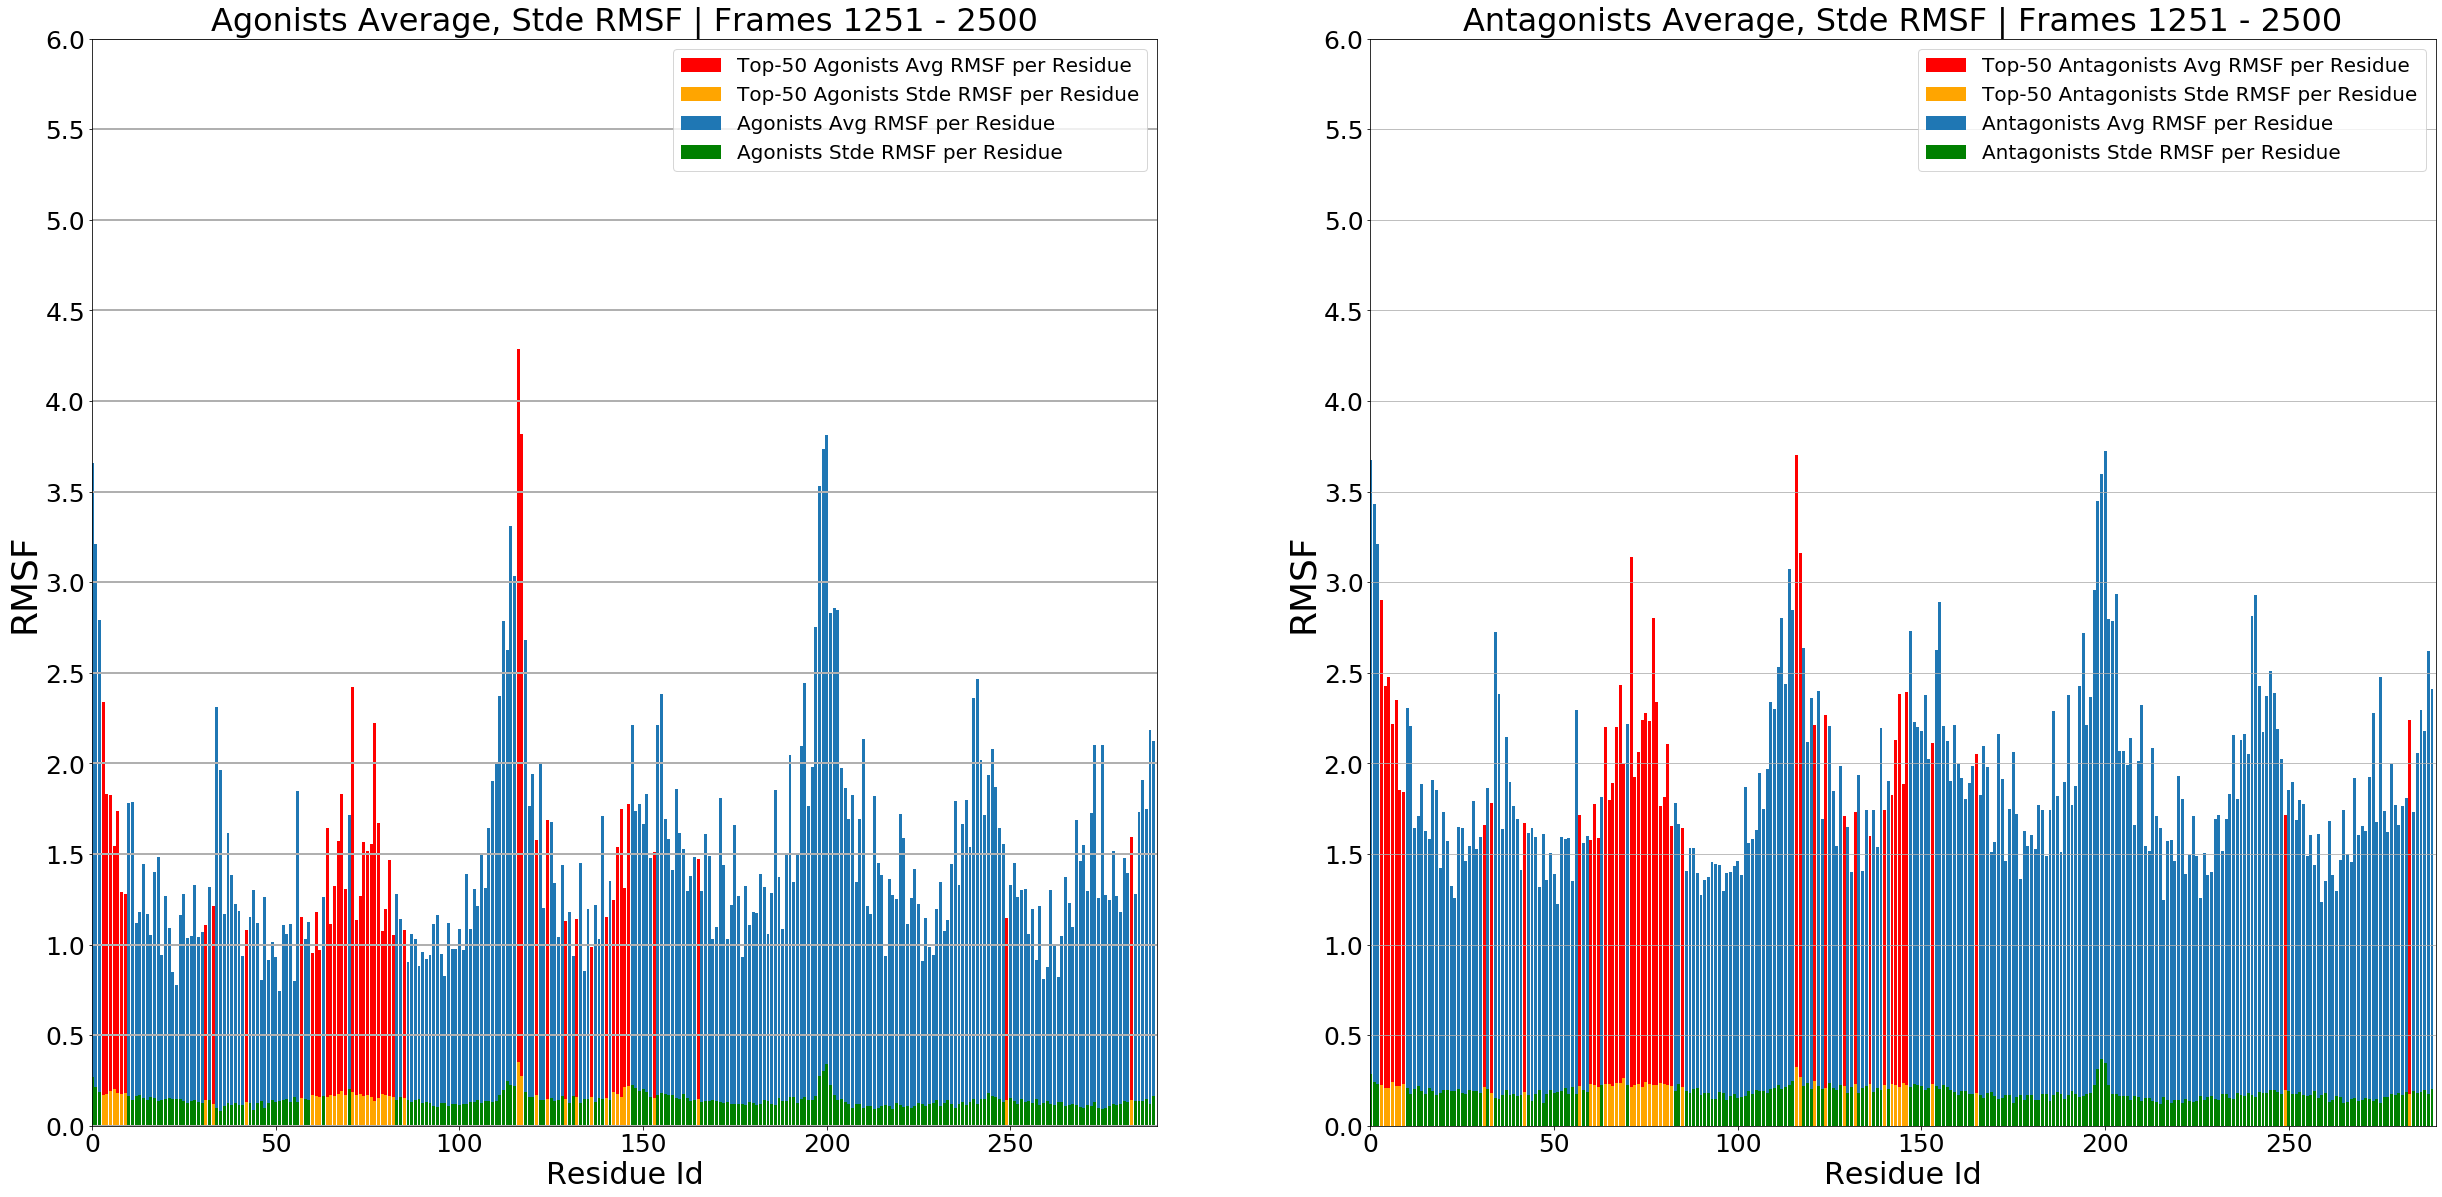

In [21]:
from MDSimsEval.rmsf_analysis import find_top_k
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue
from MDSimsEval.rmsf_analysis import reset_rmsf_calculations
from MDSimsEval.rmsf_analysis import return_top_k


def temp_create_barplots_avg_stde(analysis_actors_dict, dir_path, top=50, start=0, stop=2500, rmsf_cache=None):
    """
    The method will create two plots (one for the agonists and one for the antagonists). The plot will have the
    avg rmsf per residue and the standard error of the mean. The color of the bars of the top-k
    |agon_rmsf_avg - antagon_rmsf_avg| RMSF residues are plotted in a different color easily distinguished.

    Args:
        analysis_actors_dict: Dict(
                                "Agonists": List[AnalysisActor.class]
                                "Antagonists": List[AnalysisActor.class]
                              )
        dir_path (str): The path of the directory the plot will be saved
        top(int): The top-k residues that will be plotted with a different color
        start(int): The starting frame of the calculations
        stop(int): The stopping frame of the calculations
    """
 
    reset_rmsf_calculations(analysis_actors_dict, start, stop, rmsf_cache)

    # Calculate avg RMSF per residue
    residue_rmsfs_agon = np.array(
        [get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Agonists']])
    residue_rmsfs_antagon = np.array(
        [get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Antagonists']])

    # Average per residue
    residue_rmsfs_agon_avg = np.mean(residue_rmsfs_agon, axis=0)
    residue_rmsfs_antagon_avg = np.mean(residue_rmsfs_antagon, axis=0)

    # Standard error of the mean per residue
    residue_rmsfs_agon_sem = stats.sem(residue_rmsfs_agon)
    residue_rmsfs_antagon_sem = stats.sem(residue_rmsfs_antagon)

    # Get the indexes of the top-k absolute difference of agonists - antagonists RMSF
    top_k_indexes = return_top_k(np.abs(residue_rmsfs_agon_avg - residue_rmsfs_antagon_avg), analysis_actors_dict, k=top)
    max_diff = max(top_k_indexes.RMSF)
    min_diff = min(top_k_indexes.RMSF)

    # Get the top-k indexes plotted with different colors
    # Mask is a list of booleans where True means the residue is included in the top-k
    mask_top_k = np.array([(ind in list(top_k_indexes.ResidueId)) for ind in range(len(residue_rmsfs_agon_avg))])

    fig = plt.figure(figsize=(42, 20))
#     plt.suptitle(f"Range of Top-{top} abs(difference): {min_diff} <= diff <= {max_diff}",
#                  fontsize=35, y=0.95)
    
    # Plotting the agonists
    ax = fig.add_subplot(121)

    plt.bar(np.arange(len(residue_rmsfs_agon_avg))[mask_top_k], residue_rmsfs_agon_avg[mask_top_k],
            label=f"Top-{top} Agonists Avg RMSF per Residue", color="red")
    plt.bar(np.arange(len(residue_rmsfs_agon_avg))[mask_top_k], residue_rmsfs_agon_sem[mask_top_k],
            label=f"Top-{top} Agonists Stde RMSF per Residue", color="orange")
    plt.bar(np.arange(len(residue_rmsfs_agon_avg))[~mask_top_k], residue_rmsfs_agon_avg[~mask_top_k],
            label="Agonists Avg RMSF per Residue")
    plt.bar(np.arange(len(residue_rmsfs_agon_avg))[~mask_top_k], residue_rmsfs_agon_sem[~mask_top_k],
            label="Agonists Stde RMSF per Residue", color="green")
    

    plt.xlabel("Residue Id", fontsize=30)
    plt.xticks(np.arange(0, len(residue_rmsfs_agon_avg), 50), fontsize=25)
    plt.yticks(np.arange(0, 6.5, 0.5), fontsize=25)
    ax.set_ylim(0, 6)
    ax.set_xlim(0, 290)
    ax.yaxis.grid(linewidth=2)
    plt.ylabel("RMSF", fontsize=36)
    plt.title(f"Agonists Average, Stde RMSF | Frames {start + 1} - {stop}", fontsize=32)
    plt.legend(prop={'size': 20}, markerscale=3, loc=1)

    # Plotting the antagonists
    ax = fig.add_subplot(122)

    plt.bar(np.arange(len(residue_rmsfs_antagon_avg))[mask_top_k], residue_rmsfs_antagon_avg[mask_top_k],
            label=f"Top-{top} Antagonists Avg RMSF per Residue", color="red")
    plt.bar(np.arange(len(residue_rmsfs_antagon_avg))[mask_top_k], residue_rmsfs_antagon_sem[mask_top_k],
            label=f"Top-{top} Antagonists Stde RMSF per Residue", color="orange")
    plt.bar(np.arange(len(residue_rmsfs_antagon_avg))[~mask_top_k], residue_rmsfs_antagon_avg[~mask_top_k],
            label="Antagonists Avg RMSF per Residue")
    plt.bar(np.arange(len(residue_rmsfs_antagon_avg))[~mask_top_k], residue_rmsfs_antagon_sem[~mask_top_k],
            label="Antagonists Stde RMSF per Residue", color="green")
    

    plt.xlabel("Residue Id", fontsize=30)
    plt.xticks(np.arange(0, len(residue_rmsfs_agon_avg), 50), fontsize=25)
    plt.yticks(np.arange(0, 6.5, 0.5), fontsize=25)
    ax.set_ylim(0, 6)
    ax.set_xlim(0, 290)
    ax.yaxis.grid()
    plt.ylabel("RMSF", fontsize=36)
    plt.title(f"Antagonists Average, Stde RMSF | Frames {start + 1} - {stop}", fontsize=32)
    plt.legend(prop={'size': 20}, markerscale=3, loc=1)

    plt.savefig(f'{dir_path}rmsf_avg_stde_top_k_{start}_{stop}.png', format='png', bbox_inches='tight')
    
    return None
    
starts_list = np.arange(0, 2500, 500)
for start in starts_list:
    temp_create_barplots_avg_stde(train_analysis_actors_dict, f'../figures/RMSF/final/top_barplots/',top=50, start=start, stop=start + 500, rmsf_cache=rmsf_cache)
    
temp_create_barplots_avg_stde(train_analysis_actors_dict, f'../figures/RMSF/final/top_barplots/',top=50, start=0, stop=2500, rmsf_cache=rmsf_cache)
temp_create_barplots_avg_stde(train_analysis_actors_dict, f'../figures/RMSF/final/top_barplots/',top=50, start=0, stop=1250, rmsf_cache=rmsf_cache)
temp_create_barplots_avg_stde(train_analysis_actors_dict, f'../figures/RMSF/final/top_barplots/',top=50, start=1250, stop=2500, rmsf_cache=rmsf_cache)

### Correlation Heatmaps

In [6]:
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue
from MDSimsEval.rmsf_analysis import reset_rmsf_calculations
from MDSimsEval.rmsf_bootstrapped_analysis import find_rmsf_of_residues
from MDSimsEval.rmsf_analysis import find_top_k


def cherry_corr_of_significant_residues(analysis_actors_dict, start, stop, top, method='spearman',rmsf_cache=None):    

    residue_ids = find_top_k(analysis_actors_dict, start, stop, top, rmsf_cache).ResidueId
    
    stacked_agons_rmsf = np.array([get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Agonists']])
    stacked_antagons_rmsf = np.array([get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Antagonists']])
    
    top_stacked_agons_rmsf = stacked_agons_rmsf[:, np.array(residue_ids).astype('int')]
    top_stacked_antagons_rmsf = stacked_antagons_rmsf[:, np.array(residue_ids).astype('int')]
    
    rmsf_array = np.vstack((top_stacked_agons_rmsf, top_stacked_antagons_rmsf))
    
    
    # Use only the first 5 chars of the ligand name for better visual results
    ligand_names = [ligand.drug_name[:5]
                    for ligand in analysis_actors_dict['Agonists'] + analysis_actors_dict['Antagonists']]
    rmsf_df = pd.DataFrame(rmsf_array.T, columns=ligand_names)
    
    # Create the correlation dataframe
    corr = rmsf_df.corr(method=method)
    names_agon = {ligand.drug_name[:5] for ligand in analysis_actors_dict['Agonists']}
    names_antagon = {ligand.drug_name[:5] for ligand in analysis_actors_dict['Antagonists']}
    
    fig = plt.figure(figsize=(40,20))
    ax = fig.add_subplot(111)
    
    ax = sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=0, annot_kws={"fontsize":14}, cbar=False)
    
    for tick_label in ax.get_yticklabels():
        tick_text = tick_label.get_text()
        
        tick_label.set_fontsize(14)
        tick_label.set_rotation('horizontal')
        
        if tick_text in names_agon:
            tick_label.set_color('tab:blue')
        elif tick_text in names_antagon:
            tick_label.set_color('tab:orange')
    
        else:
            raise KeyError('Ligand tick label is unknown')
    
    for tick_label in ax.get_xticklabels():
        tick_text = tick_label.get_text()
        
        tick_label.set_fontsize(14)
        tick_label.set_rotation('vertical')
        
        if tick_text in names_agon:
            tick_label.set_color('tab:blue')
        elif tick_text in names_antagon:
            tick_label.set_color('tab:orange')
        else:
            raise KeyError('Ligand tick label is unknown')
            
    plt.title(f'Heatmap of all residues on 20 - 20 ligands on {start + 1} - {stop}', fontsize=26)
    
    plt.savefig(f'../figures/RMSF/final/all_heatmaps/spear_top{top}_{start}_{stop}.png', format='png', bbox_inches='tight')
    
    plt.close()

for start in np.arange(0, 2500, 500):
    cherry_corr_of_significant_residues(train_analysis_actors_dict, start, start + 500, top=290, rmsf_cache=rmsf_cache)
    
for start in np.arange(0, 2500, 1250):
    cherry_corr_of_significant_residues(train_analysis_actors_dict, start, start + 1250, top=290, rmsf_cache=rmsf_cache)
    
for start in np.arange(0, 2500, 2500):
    cherry_corr_of_significant_residues(train_analysis_actors_dict, start, start + 2500, top=290, rmsf_cache=rmsf_cache)

### Bootstrapped Analysis

In [33]:
from MDSimsEval.rmsf_analysis import find_top_k


def bootstrap_top_k_baseline_classify(analysis_actors_dict, top, samples, sample_size, start, stop, rmsf_cache):
    residue_ids = find_top_k(analysis_actors_dict, start, stop, top, rmsf_cache).ResidueId
    
    return bootstrapped_baseline_model(analysis_actors_dict, samples, sample_size, residue_ids, start, stop, rmsf_cache)


metrics = []
top = 50

metrics.append(bootstrap_top_k_baseline_classify(analysis_actors_dict, top, 100, 20, 0, 2500, rmsf_cache))
metrics.append(bootstrap_top_k_baseline_classify(analysis_actors_dict, top, 100, 20, 0, 1250, rmsf_cache))
metrics.append(bootstrap_top_k_baseline_classify(analysis_actors_dict, top, 100, 20, 1250, 2500, rmsf_cache))
for start in np.arange(0, 2500, 500):
    metrics.append(bootstrap_top_k_baseline_classify(analysis_actors_dict, top, 100, 20, start, start + 500, rmsf_cache))
    
with open(f'cache/baseline_model_results/samples_top_{top}_100_size_20_mean_stde.pkl', 'wb') as f:
    pickle.dump(metrics, f)

results_df = pd.DataFrame(np.around(metrics, decimals=2), columns=['Mean Train Accuracy', 'Mean Test Accuracy', 'Stde Train Accuracy', 'Stde Test Accuracy'],
                         index=['1 - 2500', '1 - 1250', '1251 - 2500', '1 - 500', ' 501 - 1000', '1001 - 1500',
                                '1501 - 2000', '2001 - 2500'])

display(results_df)

Mean Train Accuracy  Mean Test Accuracy  Stde Train Accuracy  \
1 - 2500                   68.28               68.43                 0.39   
1 - 1250                   66.82               65.29                 0.39   
1251 - 2500                66.47               67.43                 0.41   
1 - 500                    66.75               66.43                 0.37   
 501 - 1000                65.97               68.36                 0.33   
1001 - 1500                67.20               65.14                 0.41   
1501 - 2000                68.90               67.43                 0.38   
2001 - 2500                64.80               61.64                 0.34   

             Stde Test Accuracy  
1 - 2500                   1.11  
1 - 1250                   1.12  
1251 - 2500                1.13  
1 - 500                    1.06  
 501 - 1000                0.91  
1001 - 1500                1.16  
1501 - 2000                1.09  
2001 - 2500                0.97

In [32]:
print(metrics)

[(68.6, 67.71428571428572, 0.38651512181794334, 1.0862609696792975), (66.15, 67.14285714285715, 0.3750757499250227, 1.0253436608075337), (66.125, 68.35714285714286, 0.41495862030527403, 1.1631274171730603)]


## Residue Selection using Statistical Tests

Our goal is to find the residues that differentiate the most agonists from antagonists. In this part of the notebook we will apply a statistical test between the agonists' RMSF's of a residue and the antagonists' RMSF's of the same residue. Then having a p-value threshold we will select some of these residues.

In [91]:
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue
from MDSimsEval.rmsf_analysis import reset_rmsf_calculations
from scipy import stats

def stat_test_residues(analysis_actors_dict, stat_test=stats.ttest_ind, threshold=0.05, start=-1, stop=-1):
    """
    Finds the most differentiating residues based on a statistical test on their RMSF. If start==-1 and stop==-1
    then we do not recalculate RMSF on the given window. 
    
    | For example on the T-test we have:
    | Null Hypothesis: The RMSFS of a specific residue have identical average (expected) values
    
    Args:
        analysis_actors_dict: : ``{ "Agonists": List[AnalysisActor.class], "Antagonists": List[AnalysisActor.class] }``
        stat_test (scipy.stats): A statistical test method with the interface of scipy.stats methods 
        threshold (float): The p-value threshold of the accepted and returned residues
        start(int): The starting frame of the calculations
        stop(int): The stopping frame of the calculations
        
    Returns:
        A list of tuples of the residue ids (0-indexed) that had below the threshold p-value, the p_value.
        Eg ``[(10, 0.03), (5, 0.042), ...]``
        
    """
    # Recalculate the RMSF calculations on the input window if we need a reset
    if start != -1 and stop != -1:
        reset_rmsf_calculations(analysis_actors_dict, start=start, stop=stop)
    
    stacked_agons_rmsf = np.array([get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Agonists']])
    stacked_antagons_rmsf = np.array([get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Antagonists']])
    
    # Get the p_value of each residue
    p_values = []
    for agon_res_rmsf, antagon_res_rmsf in zip(stacked_agons_rmsf.T, stacked_antagons_rmsf.T):
        p_values.append(stat_test(agon_res_rmsf,antagon_res_rmsf)[1])
        
    # Select the p_values that pass the threshold
    enumed_pvalues = np.array(list(enumerate(p_values)))
    enumed_pvalues = enumed_pvalues[enumed_pvalues[:, 1] <= threshold]
    
    # Transform the ndarray to a list of tuples
    enumed_pvalues = [(int(pair[0]), pair[1]) for pair in enumed_pvalues]
    
    # Return in ascending order of p_values
    return sorted(enumed_pvalues, key=lambda x: x[1])

In [3]:
from MDSimsEval.rmsf_analysis import stat_test_residues

results = {}
thresh=0.05
def perform_3_tests(start, stop, threshold):
    ret_vals = []
    ret_vals.append(len(stat_test_residues(analysis_actors_dict, threshold=threshold, stat_test=stats.ttest_ind, start=start, stop=stop)))
    ret_vals.append(len(stat_test_residues(analysis_actors_dict, threshold=threshold, stat_test=stats.ks_2samp)))
    ret_vals.append(len(stat_test_residues(analysis_actors_dict, threshold=threshold, stat_test=stats.levene)))

    return ret_vals

results['0 - 2500'] = perform_3_tests(0, 2500, thresh)
results['0 - 1250'] = perform_3_tests(0, 1250, thresh)
results['1250 - 2500'] = perform_3_tests(1250, 2500, thresh)

for start in np.arange(0, 2500, 500):
    results[f'{start} - {start+500}'] = perform_3_tests(start, start+500, thresh)

In [4]:
df_tests = pd.DataFrame.from_dict(results, orient='index', columns=['T-test', 'Kolmogorov-Smirnov', 'Levene'])

display(df_tests)

T-test  Kolmogorov-Smirnov  Levene
0 - 2500          1                   1       0
0 - 1250          0                   2       0
1250 - 2500       6                   4       0
0 - 500           1                   8       2
500 - 1000        0                   2       1
1000 - 1500       0                   0       0
1500 - 2000       1                   2       1
2000 - 2500      23                  30       5

In [20]:
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue
from MDSimsEval.rmsf_analysis import reset_rmsf_calculations
from MDSimsEval.rmsf_analysis import return_top_k
from MDSimsEval.rmsf_analysis import stat_test_residues

from scipy import stats

def top_k_analysis(analysis_actors_dict, dir_path, top=290, start=0, stop=2500, threshold=0.05):
    # Reset the calculations of the RMSF for each ligand
    for ligand in analysis_actors_dict['Agonists'] + analysis_actors_dict['Antagonists']:
        ligand.rmsf_res = None

    # Recalculate on the given window
    for ligand in analysis_actors_dict['Agonists'] + analysis_actors_dict['Antagonists']:
        ligand.rmsf_res = RMSF(ligand.uni.select_atoms('protein')).run(start=start, stop=stop)

    # Calculate RMSF per residue
    residue_rmsfs_agon = np.array(
        [get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Agonists']])
    residue_rmsfs_antagon = np.array(
        [get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Antagonists']])
    
    # Find the highest-k residues per class and create their intercept
    residue_rmsfs_agon_avg = np.mean(residue_rmsfs_agon, axis=0)
    residue_rmsfs_antagon_avg = np.mean(residue_rmsfs_antagon, axis=0)
        
    high_k_agon_rmsf = return_top_k(residue_rmsfs_agon_avg, analysis_actors_dict, k=top)
    high_k_agon_rmsf['AgonRank'] = high_k_agon_rmsf.index
    high_k_agon_rmsf.set_index('ResidueId', drop=True, inplace=True)
    high_k_agon_rmsf.rename(columns={'RMSF': 'AgonRMSF'}, inplace=True)
    
    high_k_antagon = return_top_k(residue_rmsfs_antagon_avg, analysis_actors_dict, k=top)
    high_k_antagon['AgonRank'] = high_k_antagon.index
    high_k_antagon.set_index('ResidueId', drop=True, inplace=True)
    high_k_antagon.rename(columns={'RMSF': 'AntagonRMSF'}, inplace=True)

    # The intercept of the highest-k residues of each class
    merged_dfs = pd.merge(high_k_agon_rmsf, high_k_antagon, left_index=True, right_index=True)
    
    common_residues = set(merged_dfs.index)
    
    all_residues_agon = return_top_k(residue_rmsfs_agon_avg, analysis_actors_dict, k=290)
    high_mask_agon = np.array([res_id in common_residues for res_id in all_residues_agon.ResidueId])
    
    all_residues_antagon = return_top_k(residue_rmsfs_antagon_avg, analysis_actors_dict, k=290)
    high_mask_antagon = np.array([res_id in common_residues for res_id in all_residues_antagon.ResidueId])

    
    # Find the top-k residues
    top_k_agon_rmsf = return_top_k(residue_rmsfs_agon_avg, analysis_actors_dict, k=top)
    top_mask_agon = np.array([res_id in top_k_agon_rmsf.ResidueId for res_id in all_residues_agon.ResidueId])
    
    top_k_antagon_rmsf = return_top_k(residue_rmsfs_antagon_avg, analysis_actors_dict, k=top)
    top_mask_antagon = np.array([res_id in top_k_antagon_rmsf.ResidueId for res_id in all_residues_antagon.ResidueId])
    
    # Find the statistically significant residues
    significant_residues = stat_test_residues(analysis_actors_dict, stats.ks_2samp, threshold=threshold)
    significant_residues = [i[0] for i in significant_residues]
    
    sign_mask_agon = np.array([res_id in significant_residues for res_id in all_residues_agon.ResidueId])
    sign_top_mask_agon = np.logical_and(np.logical_xor(sign_mask_agon, top_mask_agon), sign_mask_agon)
    sign_not_top_mask_agon = np.logical_and(~sign_top_mask_agon, sign_mask_agon)
    
    sign_mask_antagon = np.array([res_id in significant_residues for res_id in all_residues_antagon.ResidueId])
    sign_top_mask_antagon = np.logical_and(np.logical_xor(sign_mask_antagon, top_mask_antagon), sign_mask_antagon)
    sign_not_top_mask_antagon = np.logical_and(~sign_top_mask_antagon, sign_mask_antagon)
        
    fig = plt.figure(figsize=(42, 20))
    plt.suptitle(f"Profiles of Descending RMSF",
                 fontsize=35, y=0.95)
    
    # Plotting the agonists
    ax = fig.add_subplot(121)
    
    plt.bar(np.arange(len(all_residues_agon))[~high_mask_agon], 
            np.array(all_residues_agon.RMSF)[~high_mask_agon],
            label="Agonists NOT on the common set", alpha=0.8)
    
    plt.bar(np.arange(len(all_residues_agon))[high_mask_agon], 
                np.array(all_residues_agon.RMSF)[high_mask_agon],
                color="red", label="Agonists on the common set", alpha=0.8)
    
    plt.vlines(np.arange(len(all_residues_agon))[top_mask_agon], 
                ymin=0, ymax=6, linestyles="dashed",
                color="black", label="Agonists in the top-k")
    
    plt.vlines(np.arange(len(all_residues_agon))[sign_top_mask_agon], 
                ymin=0, ymax=-1, linestyles="solid",
                color="orange", label=f"Stat Significant and IN the top-{top}")
    
    plt.vlines(np.arange(len(all_residues_agon))[sign_not_top_mask_agon], 
            ymin=0, ymax=-1, linestyles="solid",
            color="magenta", label=f"Stat Significant and NOT IN the top-{top}")
    
    plt.xticks(np.arange(0, 290, 25), fontsize=25)
    plt.yticks(np.arange(0, 6.5, 0.5), fontsize=25)
    ax.set_ylim(-1, 6)
    ax.set_xlim(0, 290)
    ax.yaxis.grid()
    plt.xlabel("Residue Count", fontsize=36)
    plt.ylabel("RMSF", fontsize=36)
    plt.title(f"Agonists Descending RMSF | Frames {start} - {stop} | p-value {threshold}", fontsize=32)
    plt.legend(prop={'size': 25}, markerscale=3, loc=1)
    
    # Plotting the antagonists
    ax = fig.add_subplot(122)
    
    plt.bar(np.arange(len(all_residues_antagon))[~high_mask_antagon], 
            np.array(all_residues_antagon.RMSF)[~high_mask_antagon],
            label="Antagonists NOT on the common set", alpha=0.8)
    
    plt.bar(np.arange(len(all_residues_antagon))[high_mask_antagon], 
                np.array(all_residues_antagon.RMSF)[high_mask_antagon],
                color="red", label="Antagonists on the common set", alpha=0.8)
    
    plt.vlines(np.arange(len(all_residues_antagon))[top_mask_antagon], 
                ymin=0, ymax=6, linestyles="dashed",
                color="black", label="Antagonists in the top-k")
    
    plt.vlines(np.arange(len(all_residues_antagon))[sign_top_mask_antagon], 
                ymin=0, ymax=-1, linestyles="solid",
                color="orange", label=f"Stat Significant and IN the top-{top}")
    
    plt.vlines(np.arange(len(all_residues_antagon))[sign_not_top_mask_antagon], 
            ymin=0, ymax=-1, linestyles="solid",
            color="magenta", label=f"Stat Significant and NOT IN the top-{top}")
    
    plt.xticks(np.arange(0, 290, 25), fontsize=25)
    plt.yticks(np.arange(0, 6.5, 0.5), fontsize=25)
    ax.set_ylim(-1, 6)
    ax.set_xlim(0, 290)
    ax.yaxis.grid()
    plt.xlabel("Residue Count", fontsize=36)
    plt.ylabel("RMSF", fontsize=36)
    plt.title(f"Antagonists Descending RMSF | Frames {start} - {stop} | p-value {threshold}", fontsize=32)
    plt.legend(prop={'size': 25}, markerscale=3, loc=1)
    
    plt.savefig(f'{dir_path}rmsf_descending_high{top}_{start}_{stop}_{threshold}.png', format='png')
    
    return None

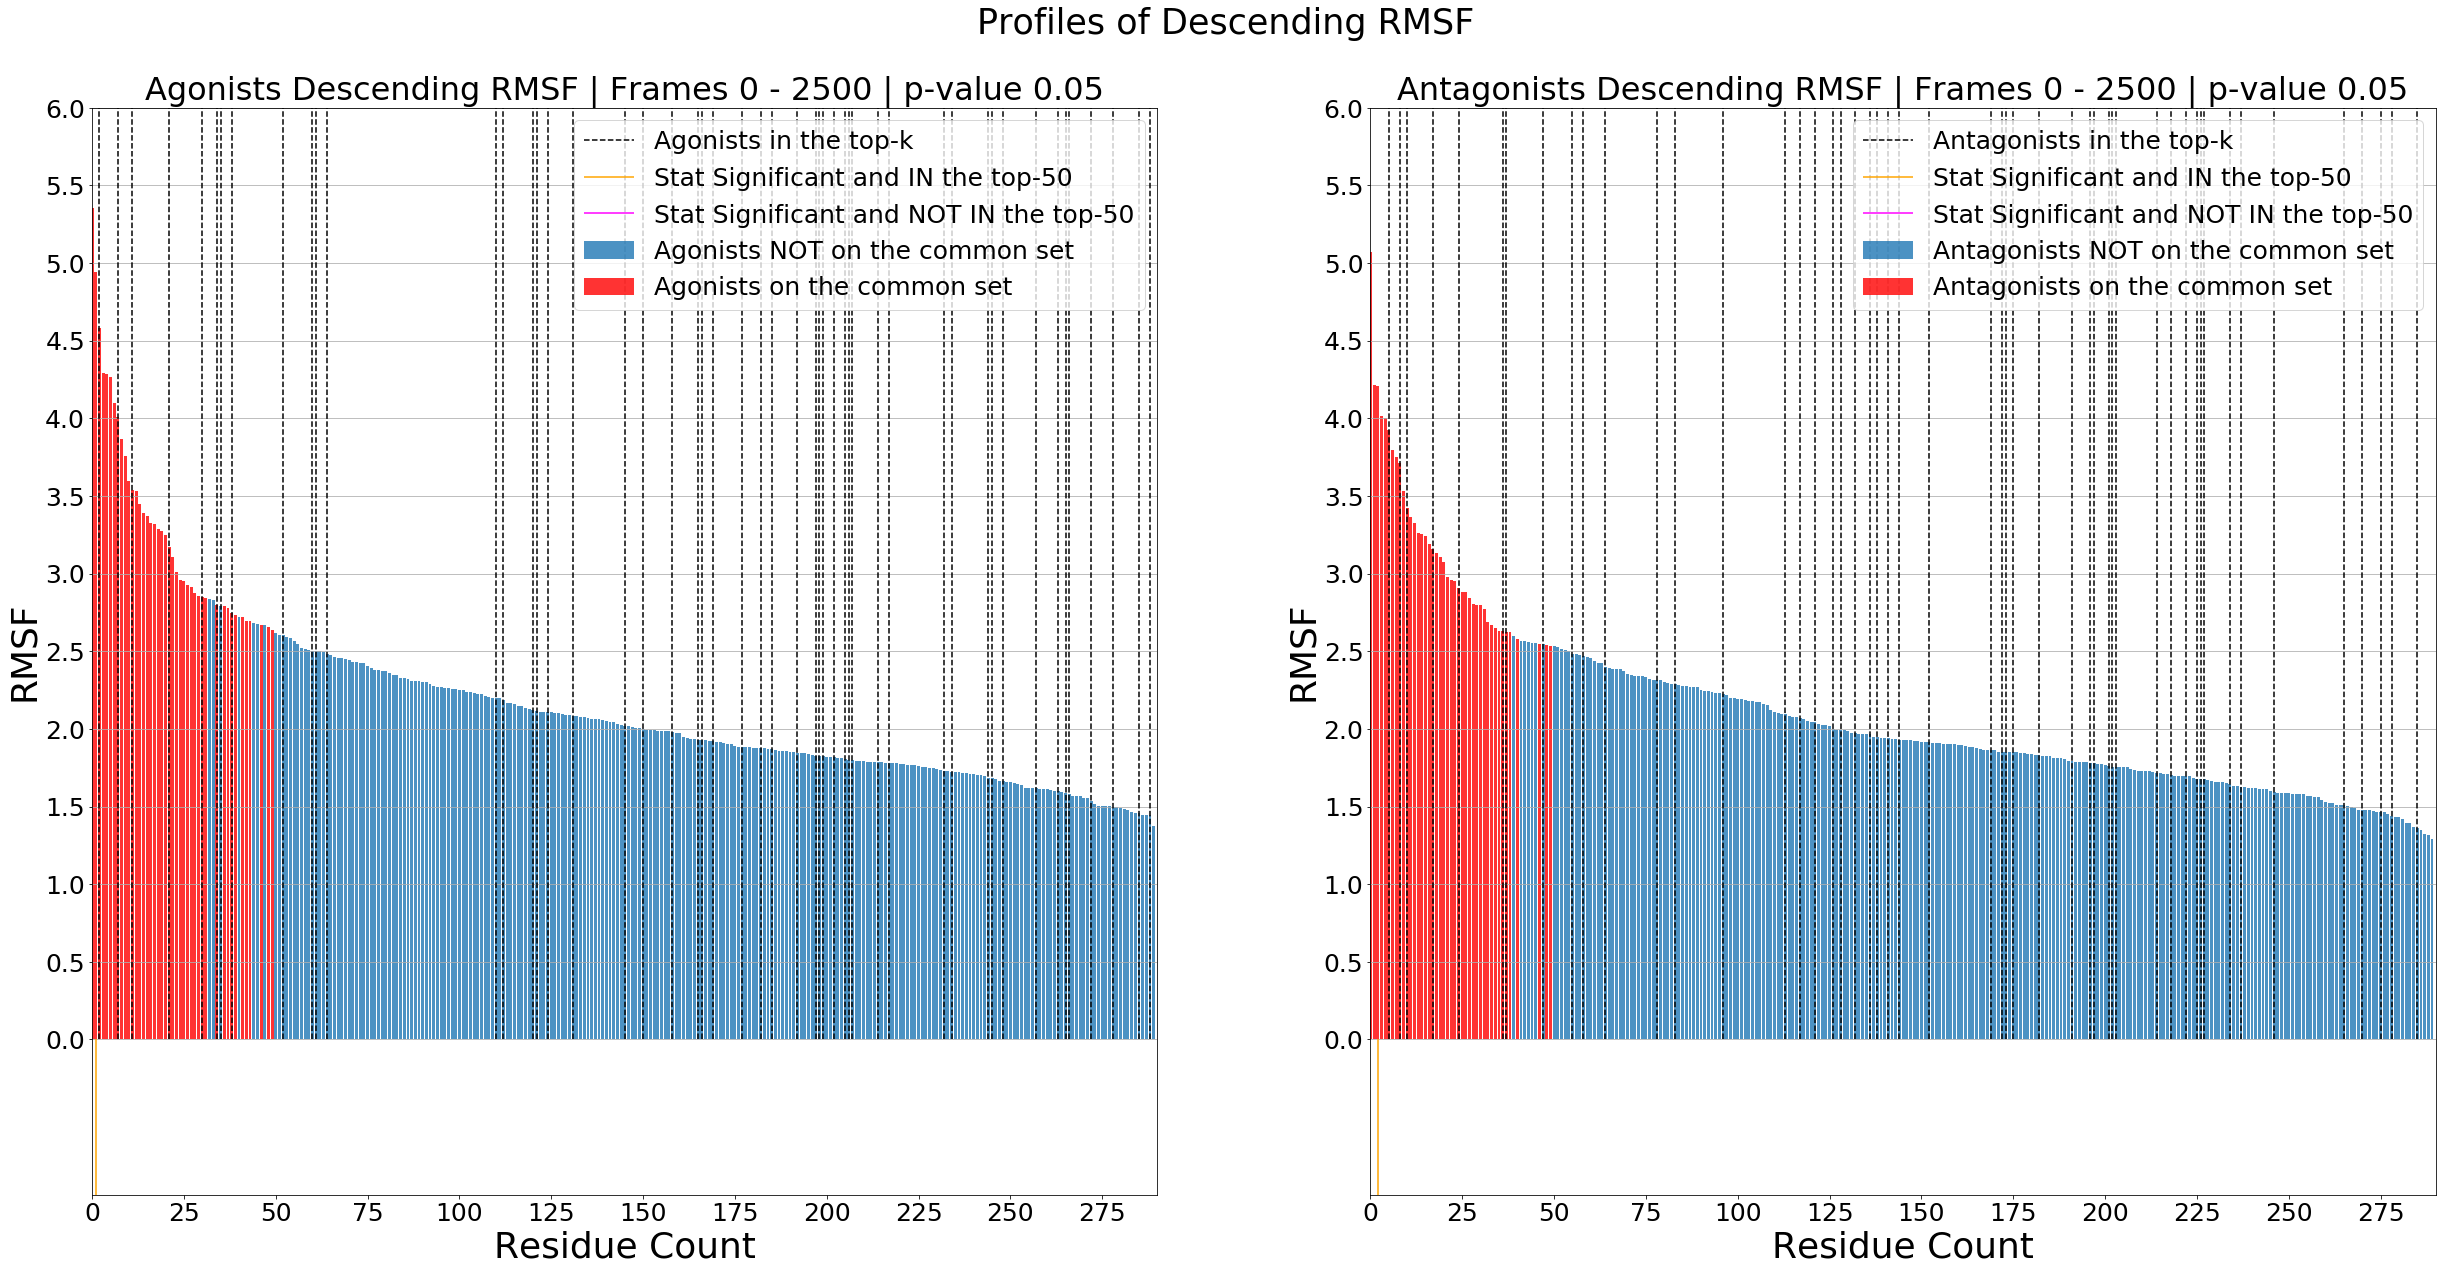

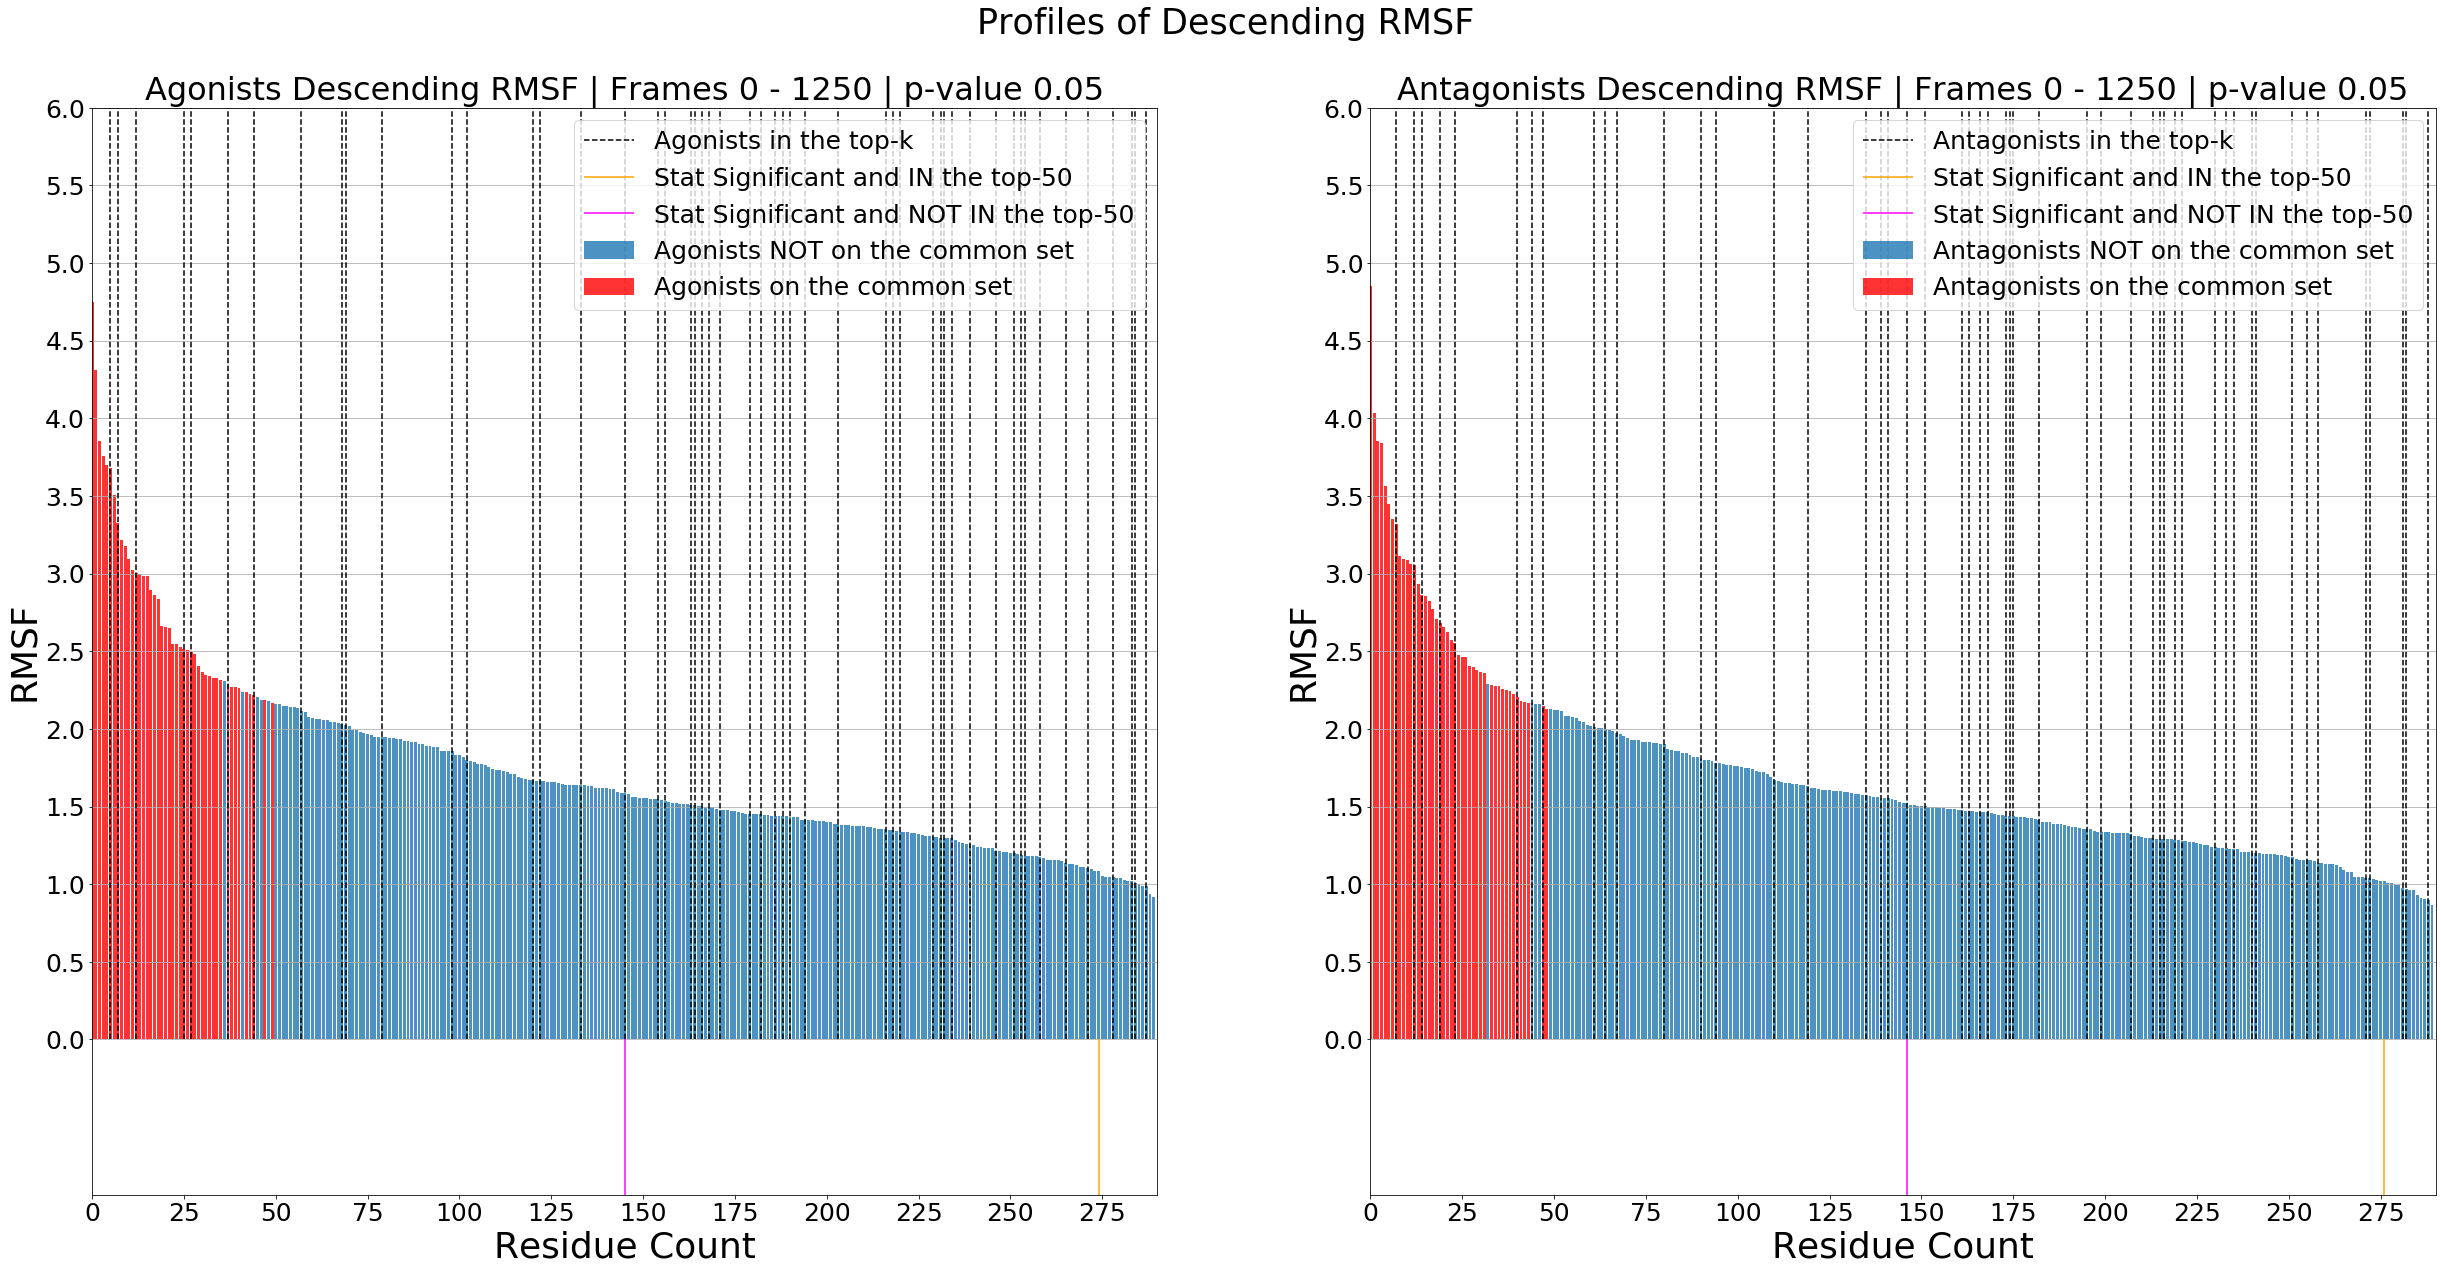

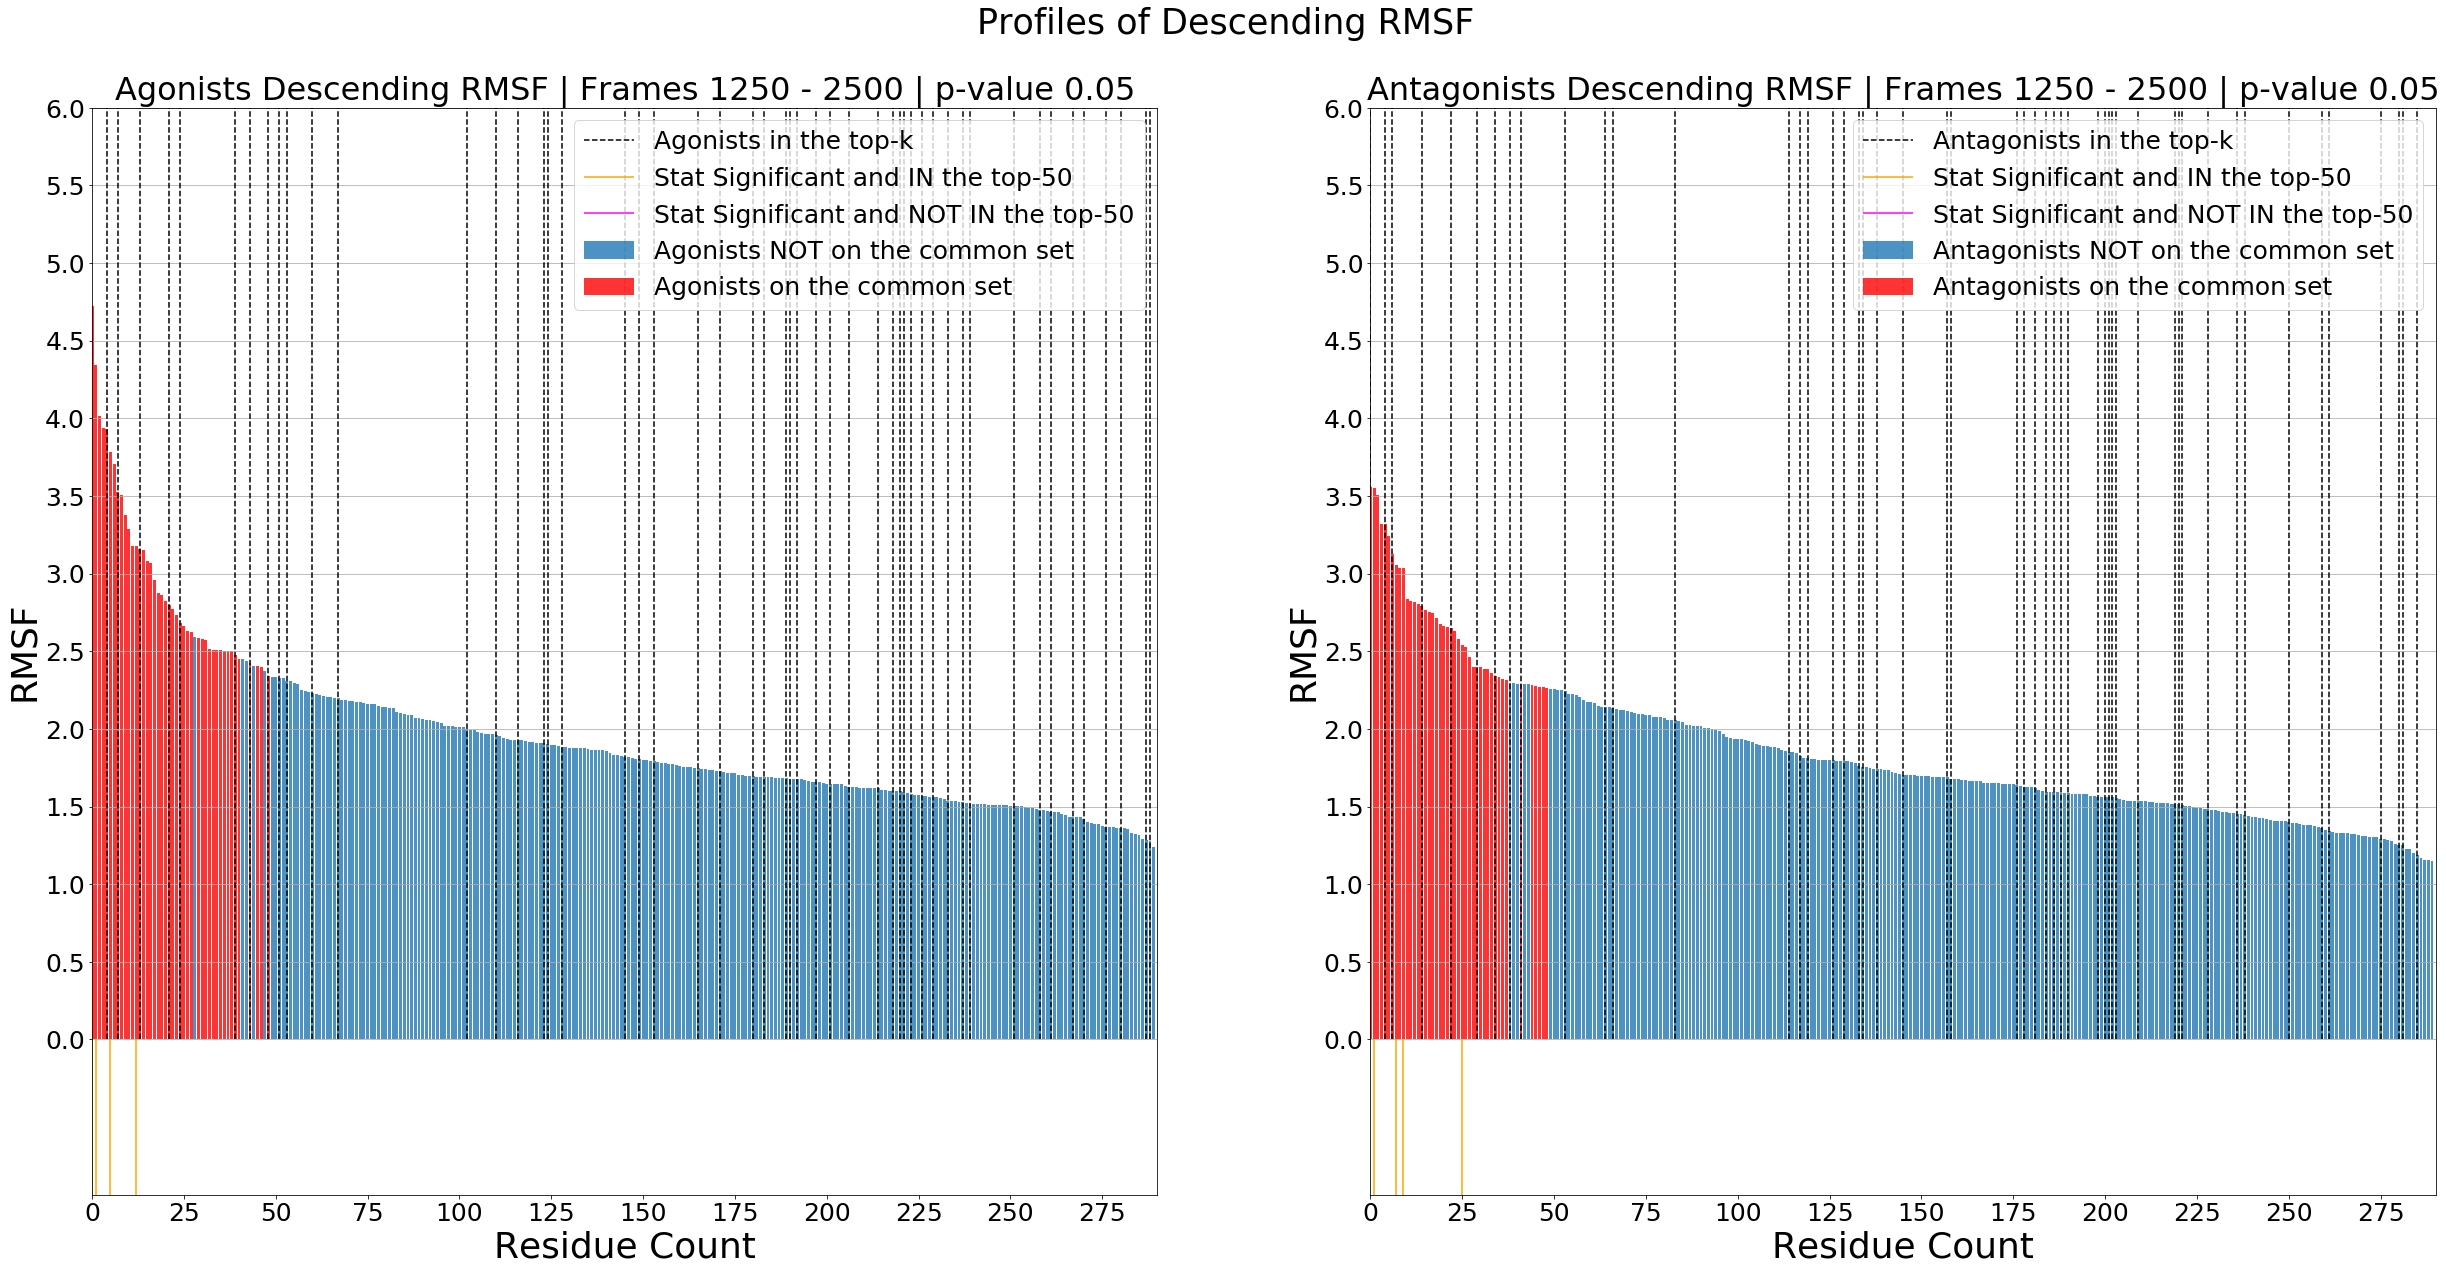

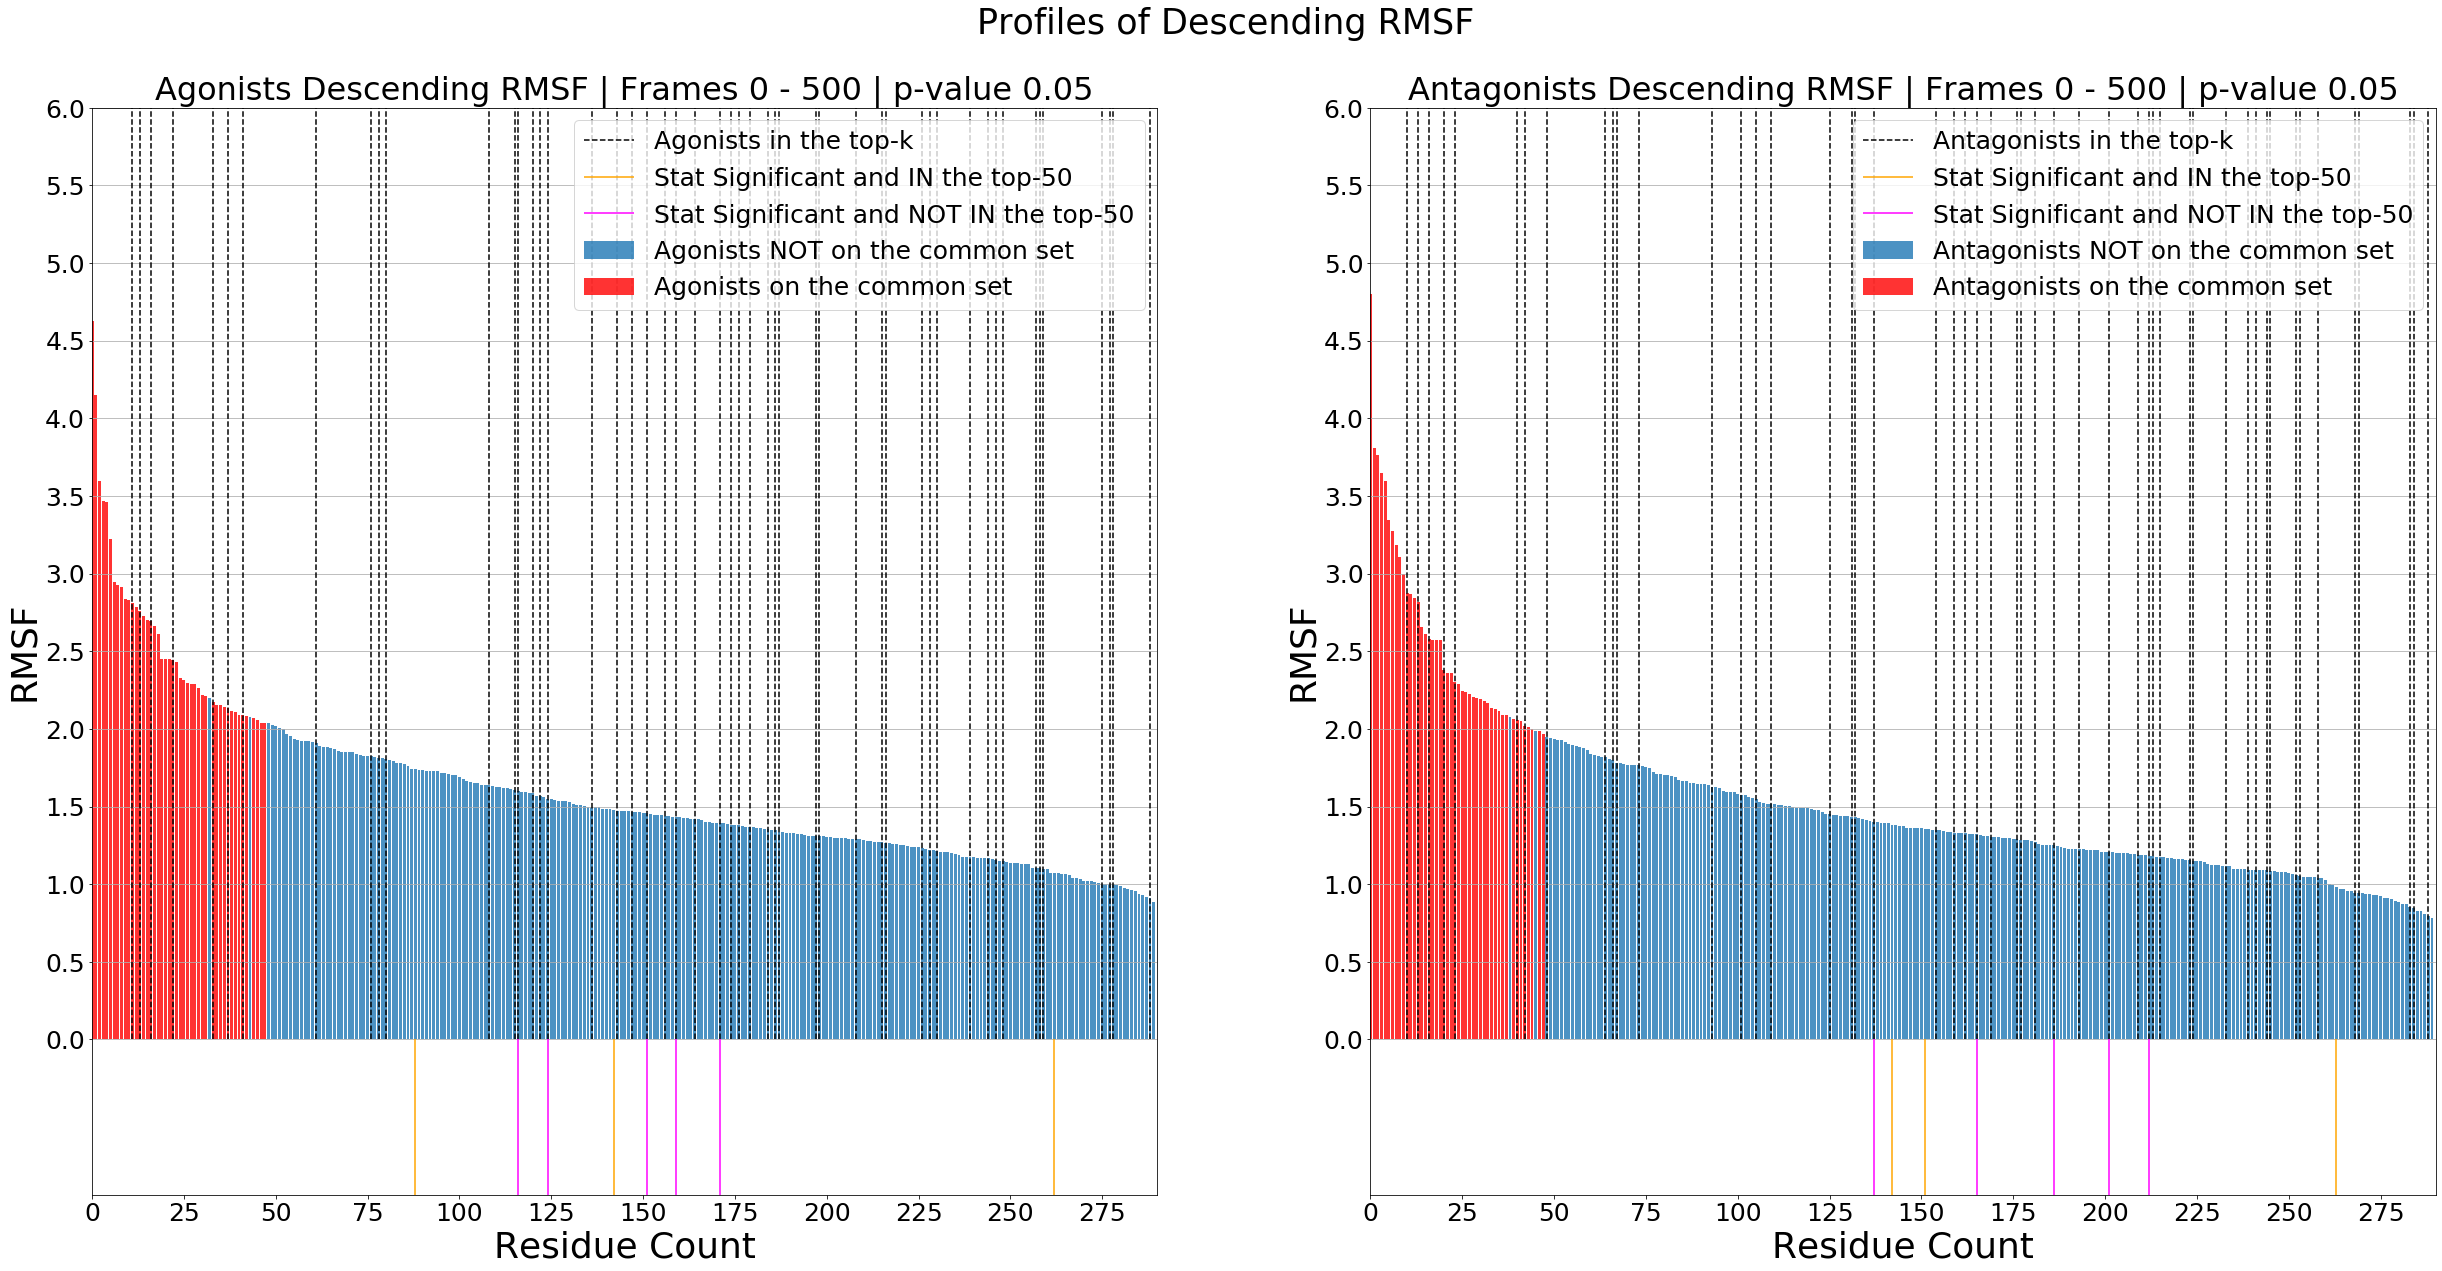

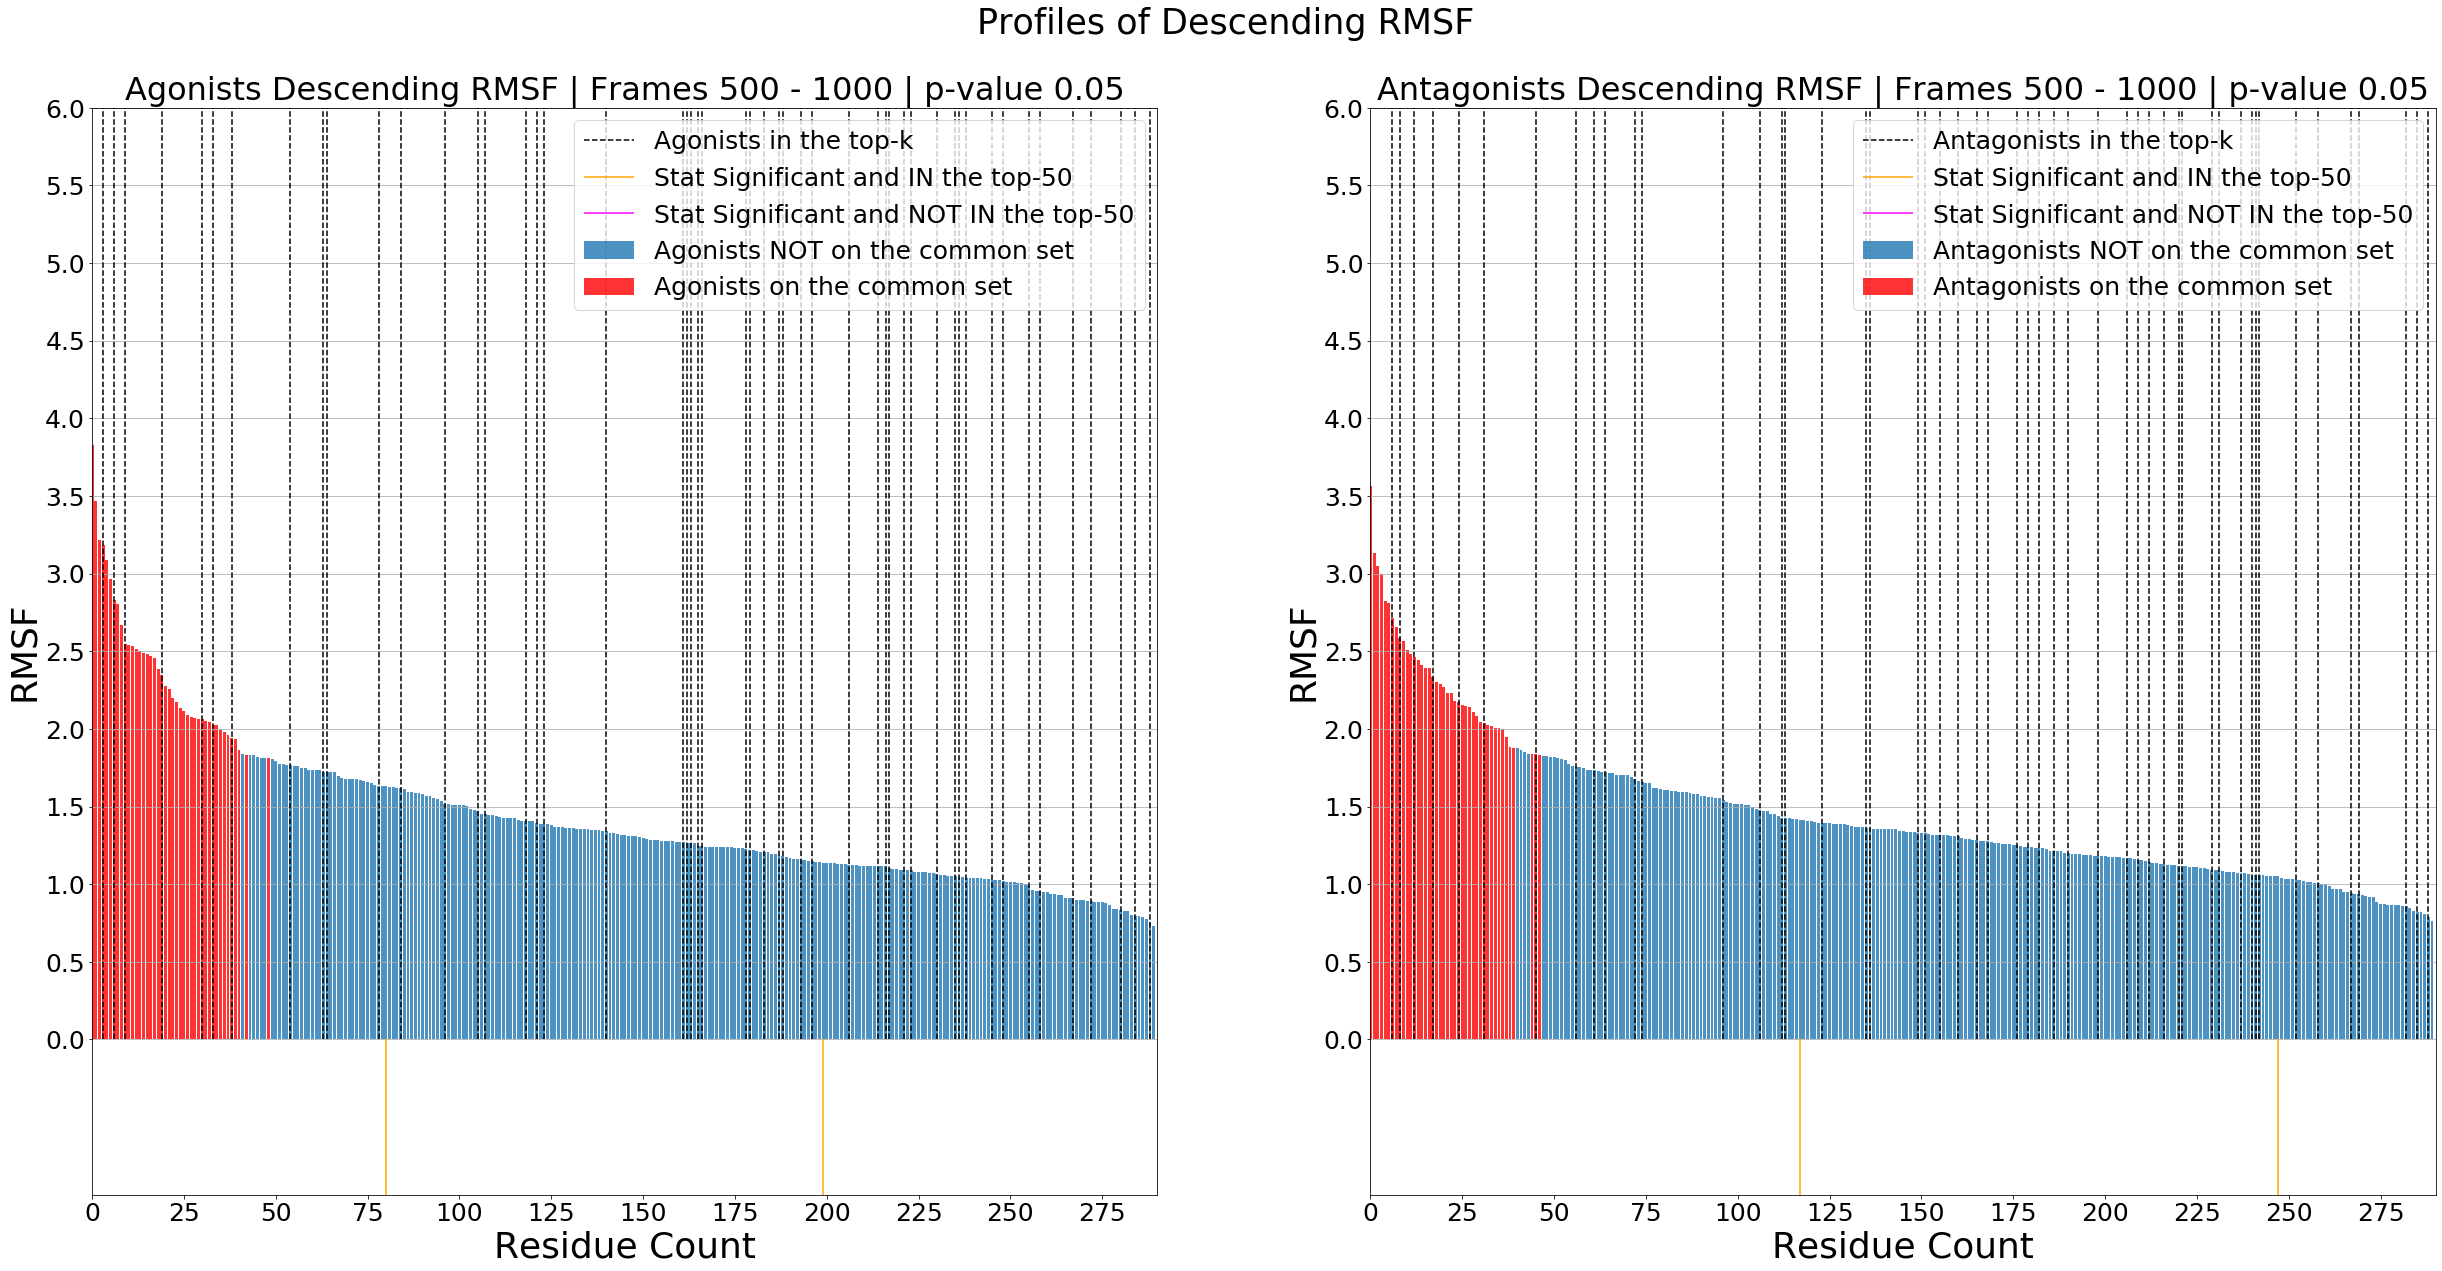

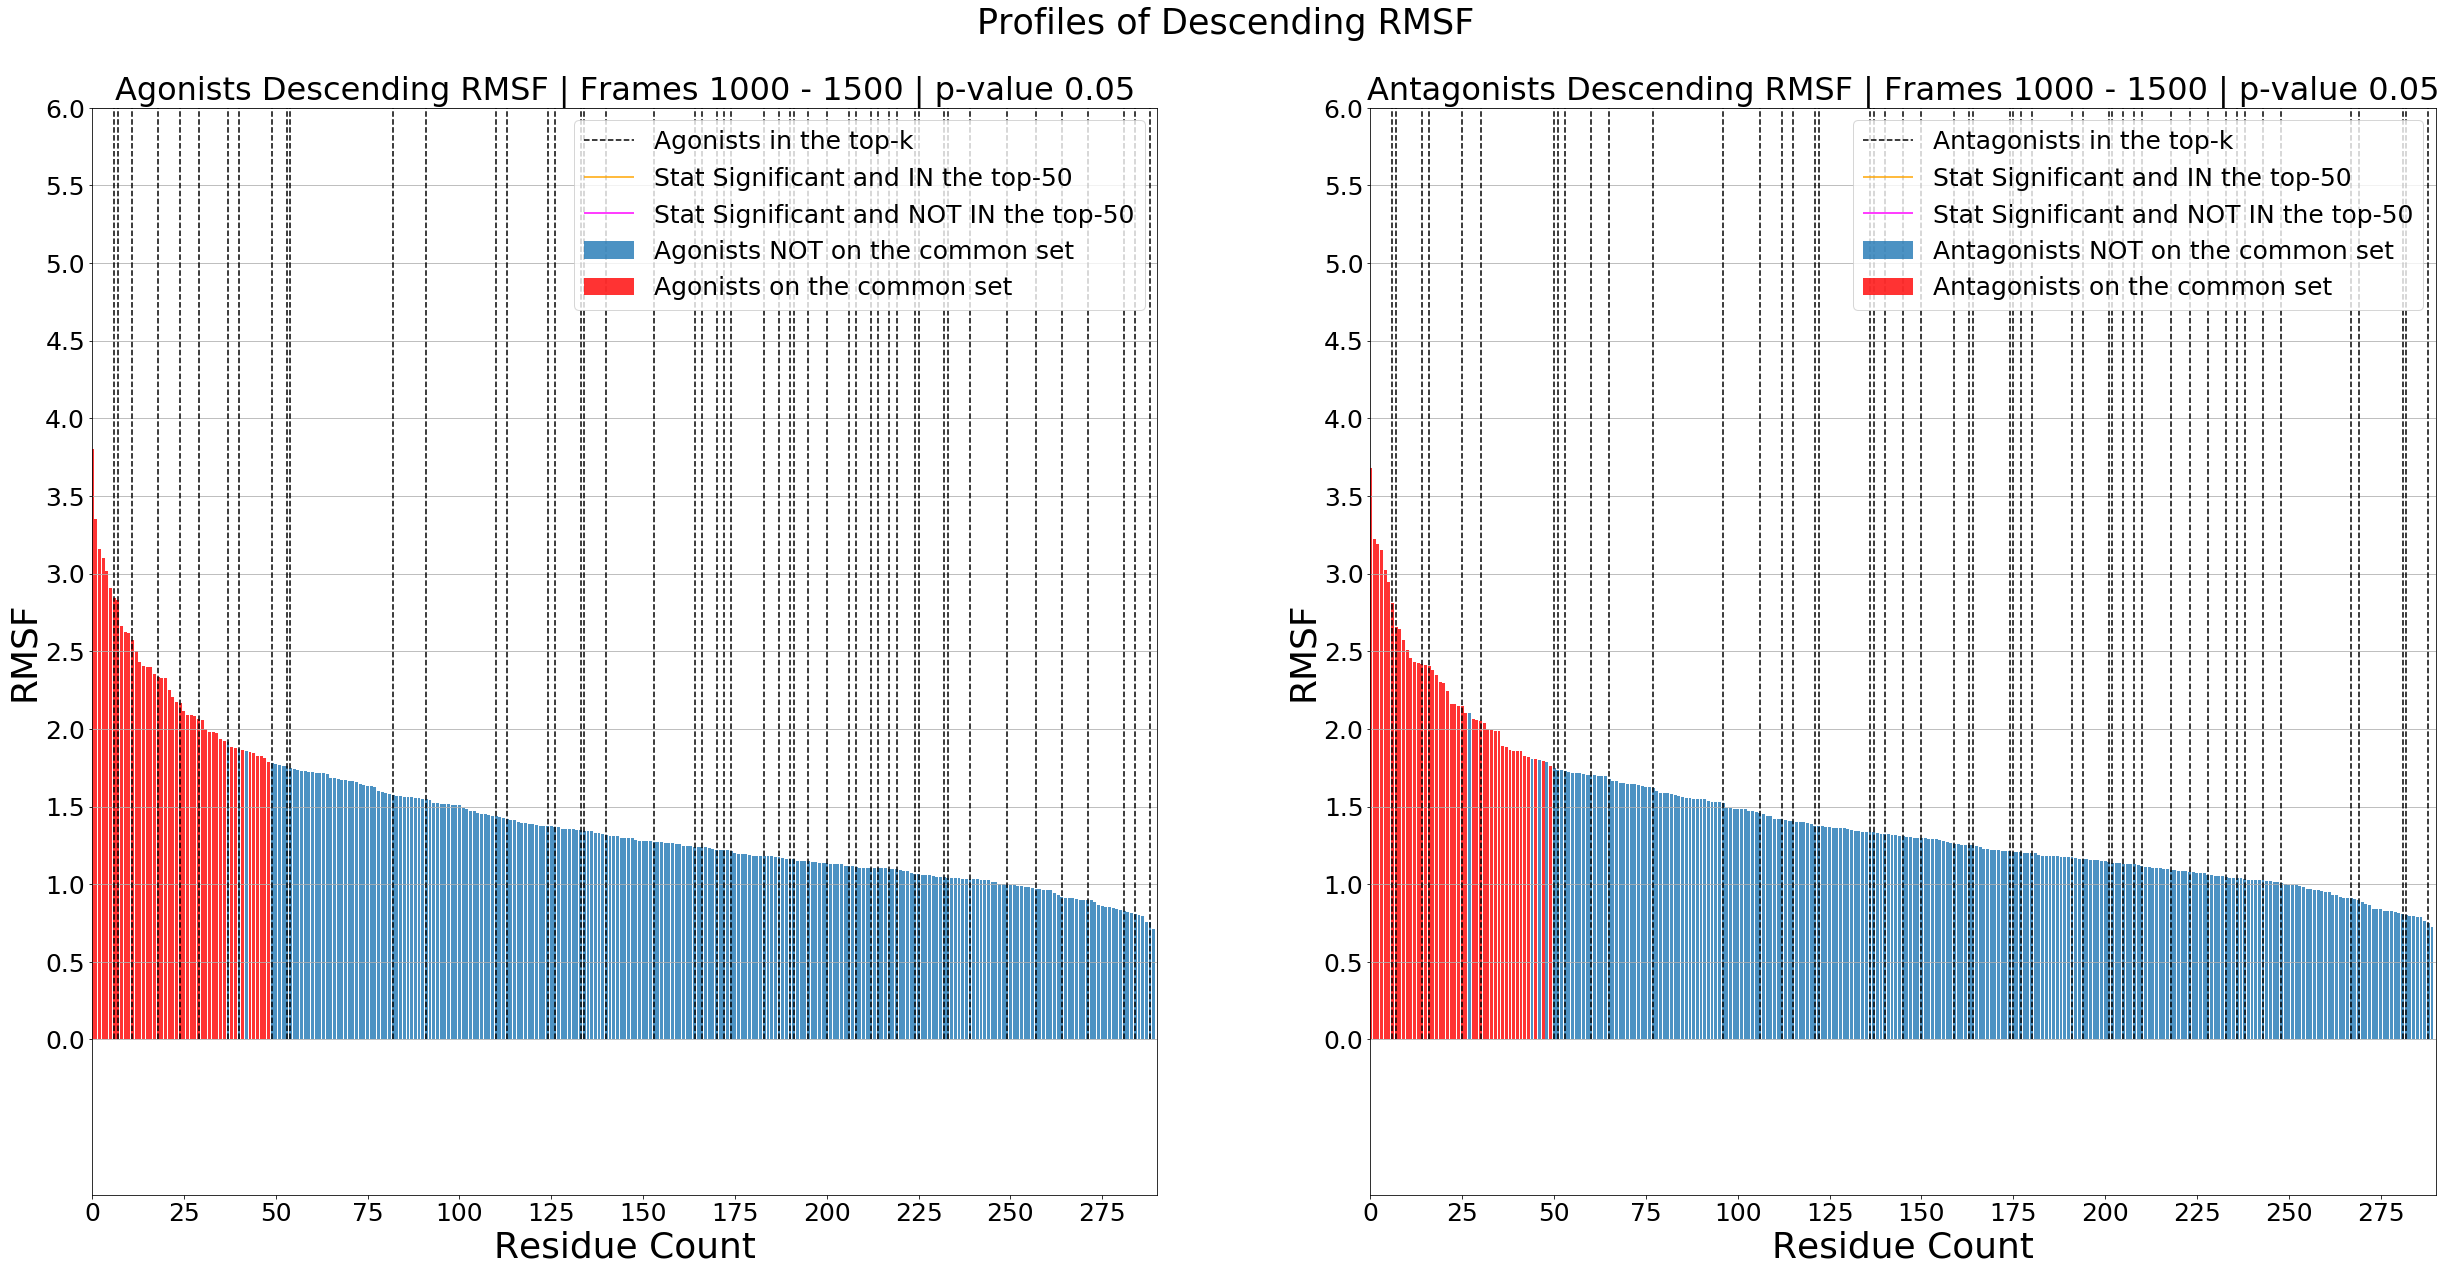

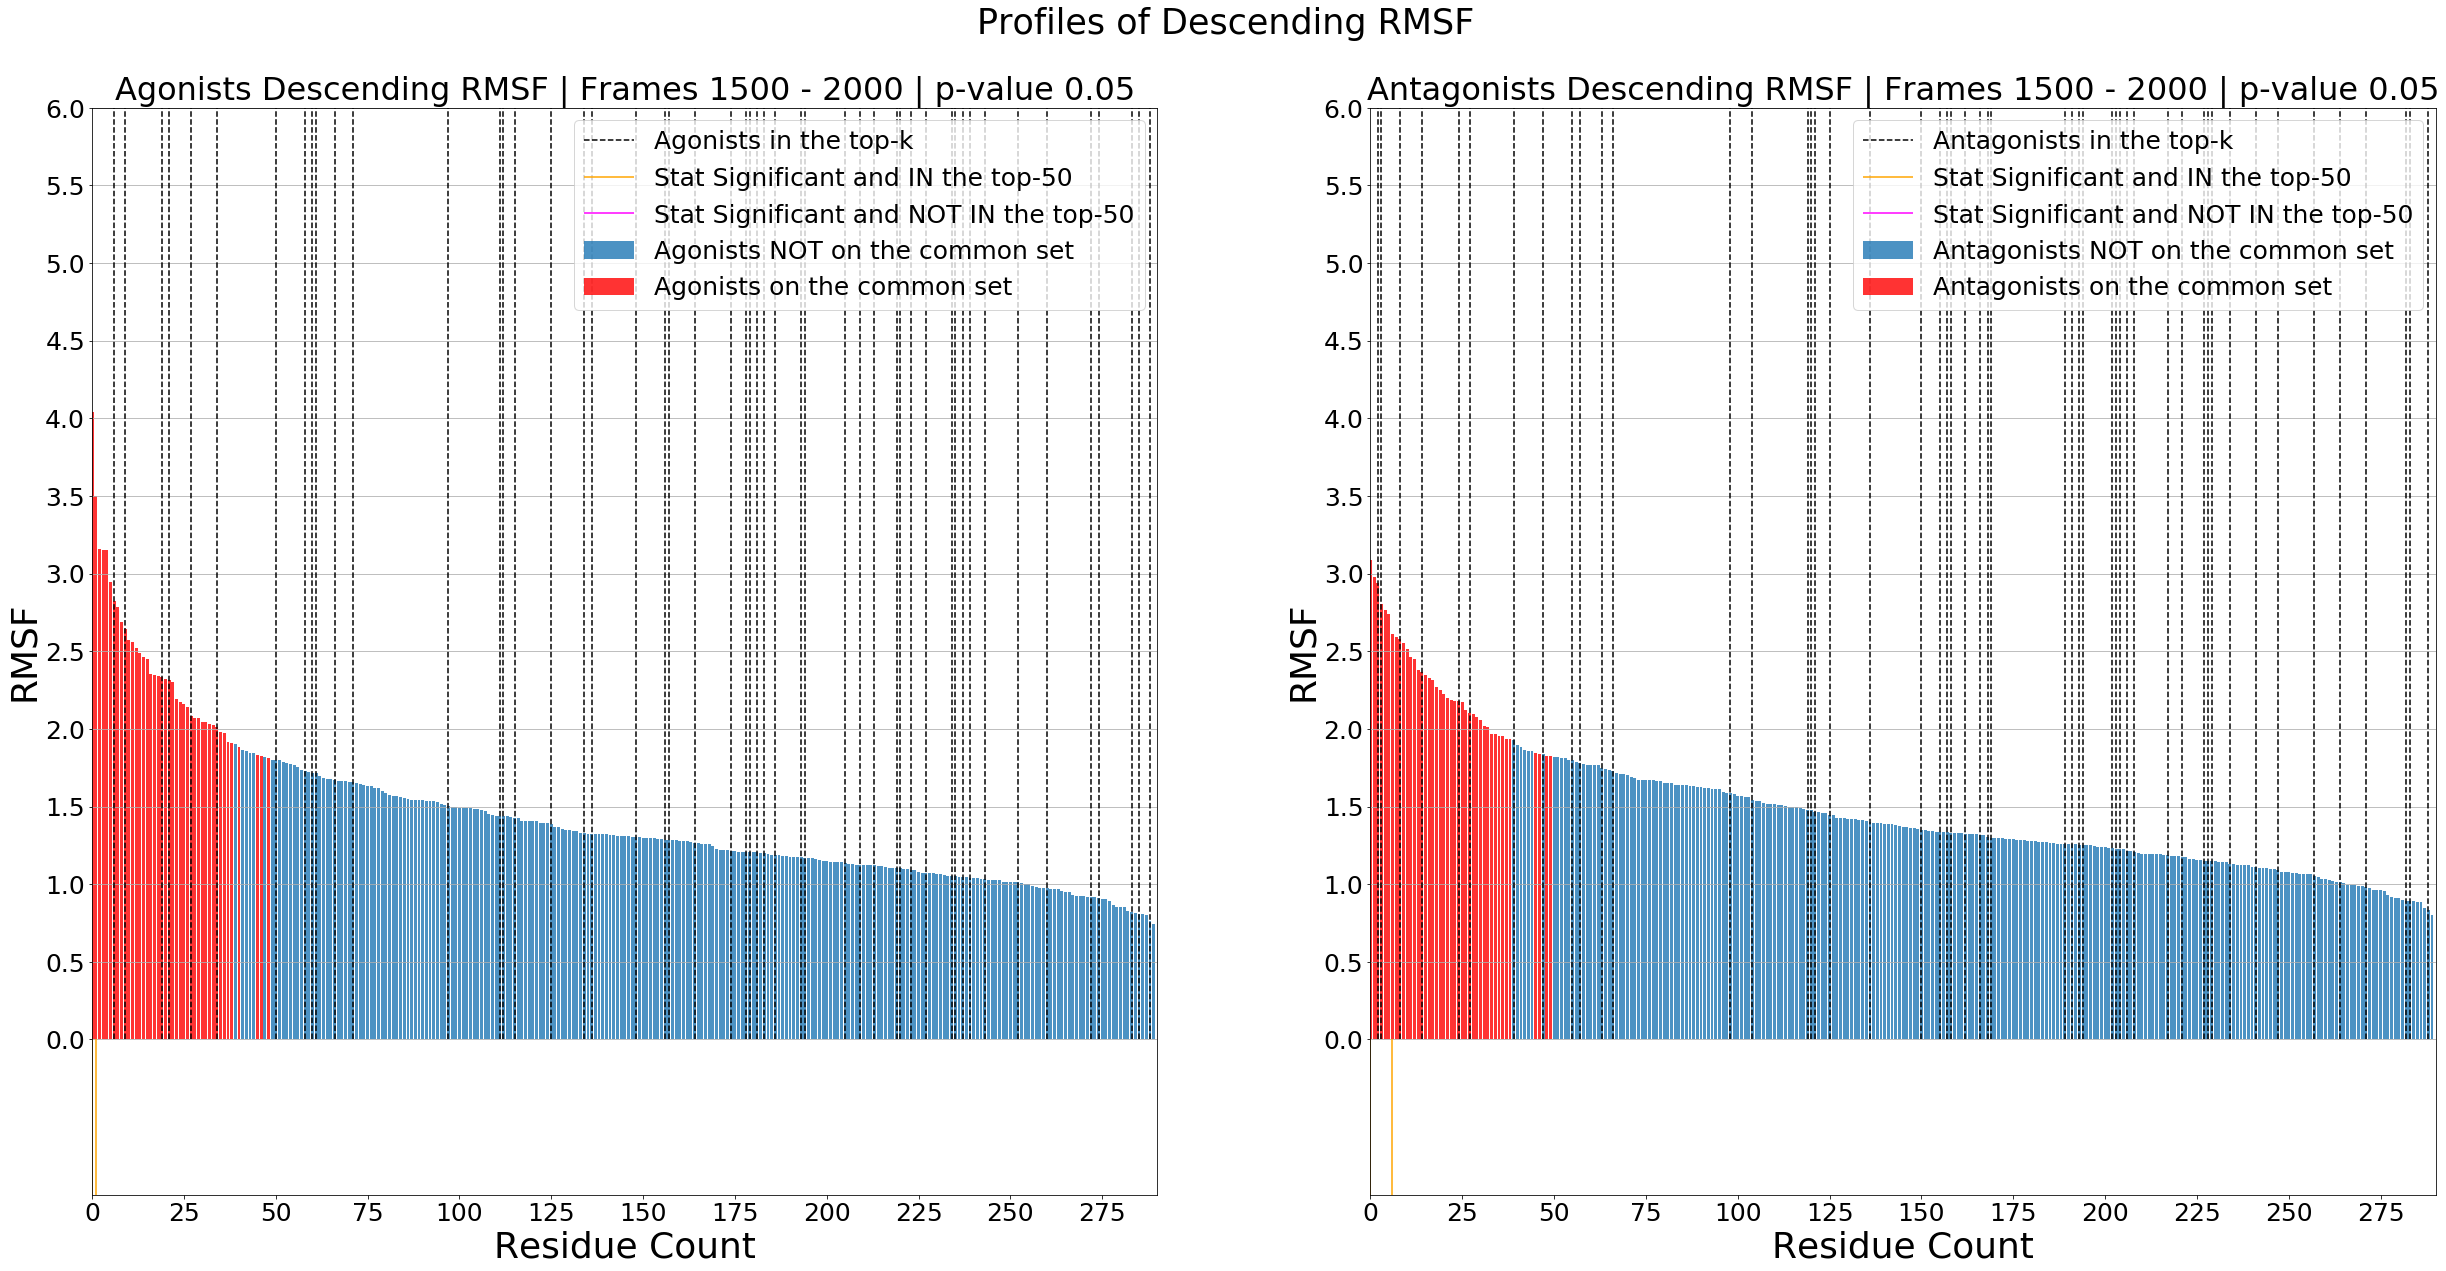

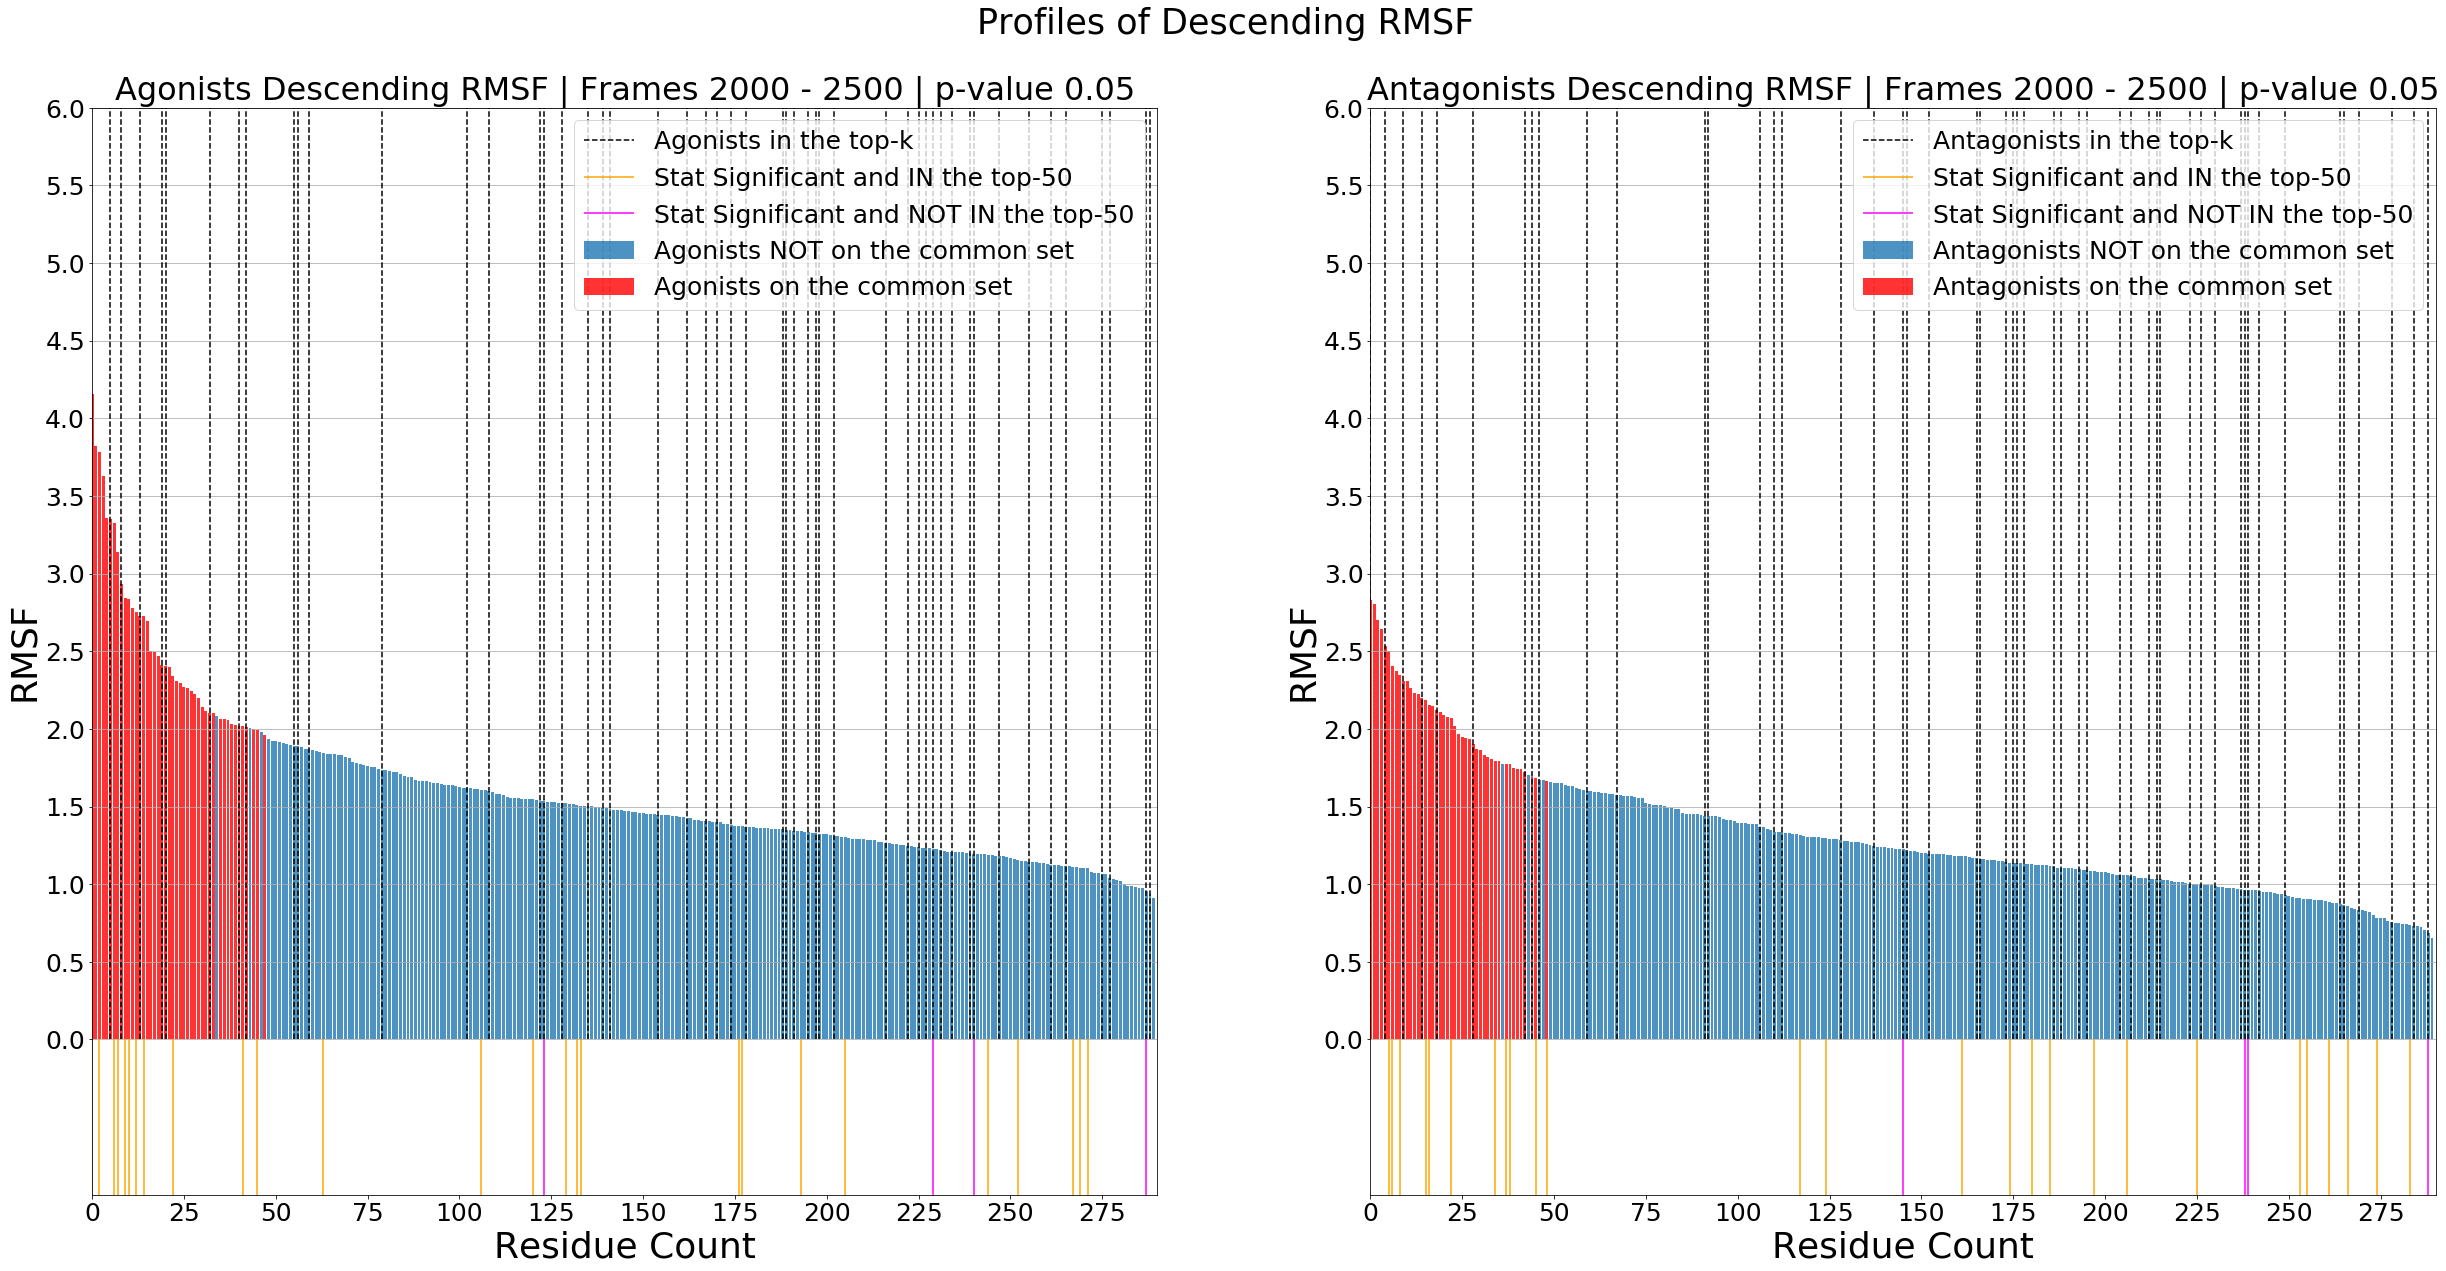

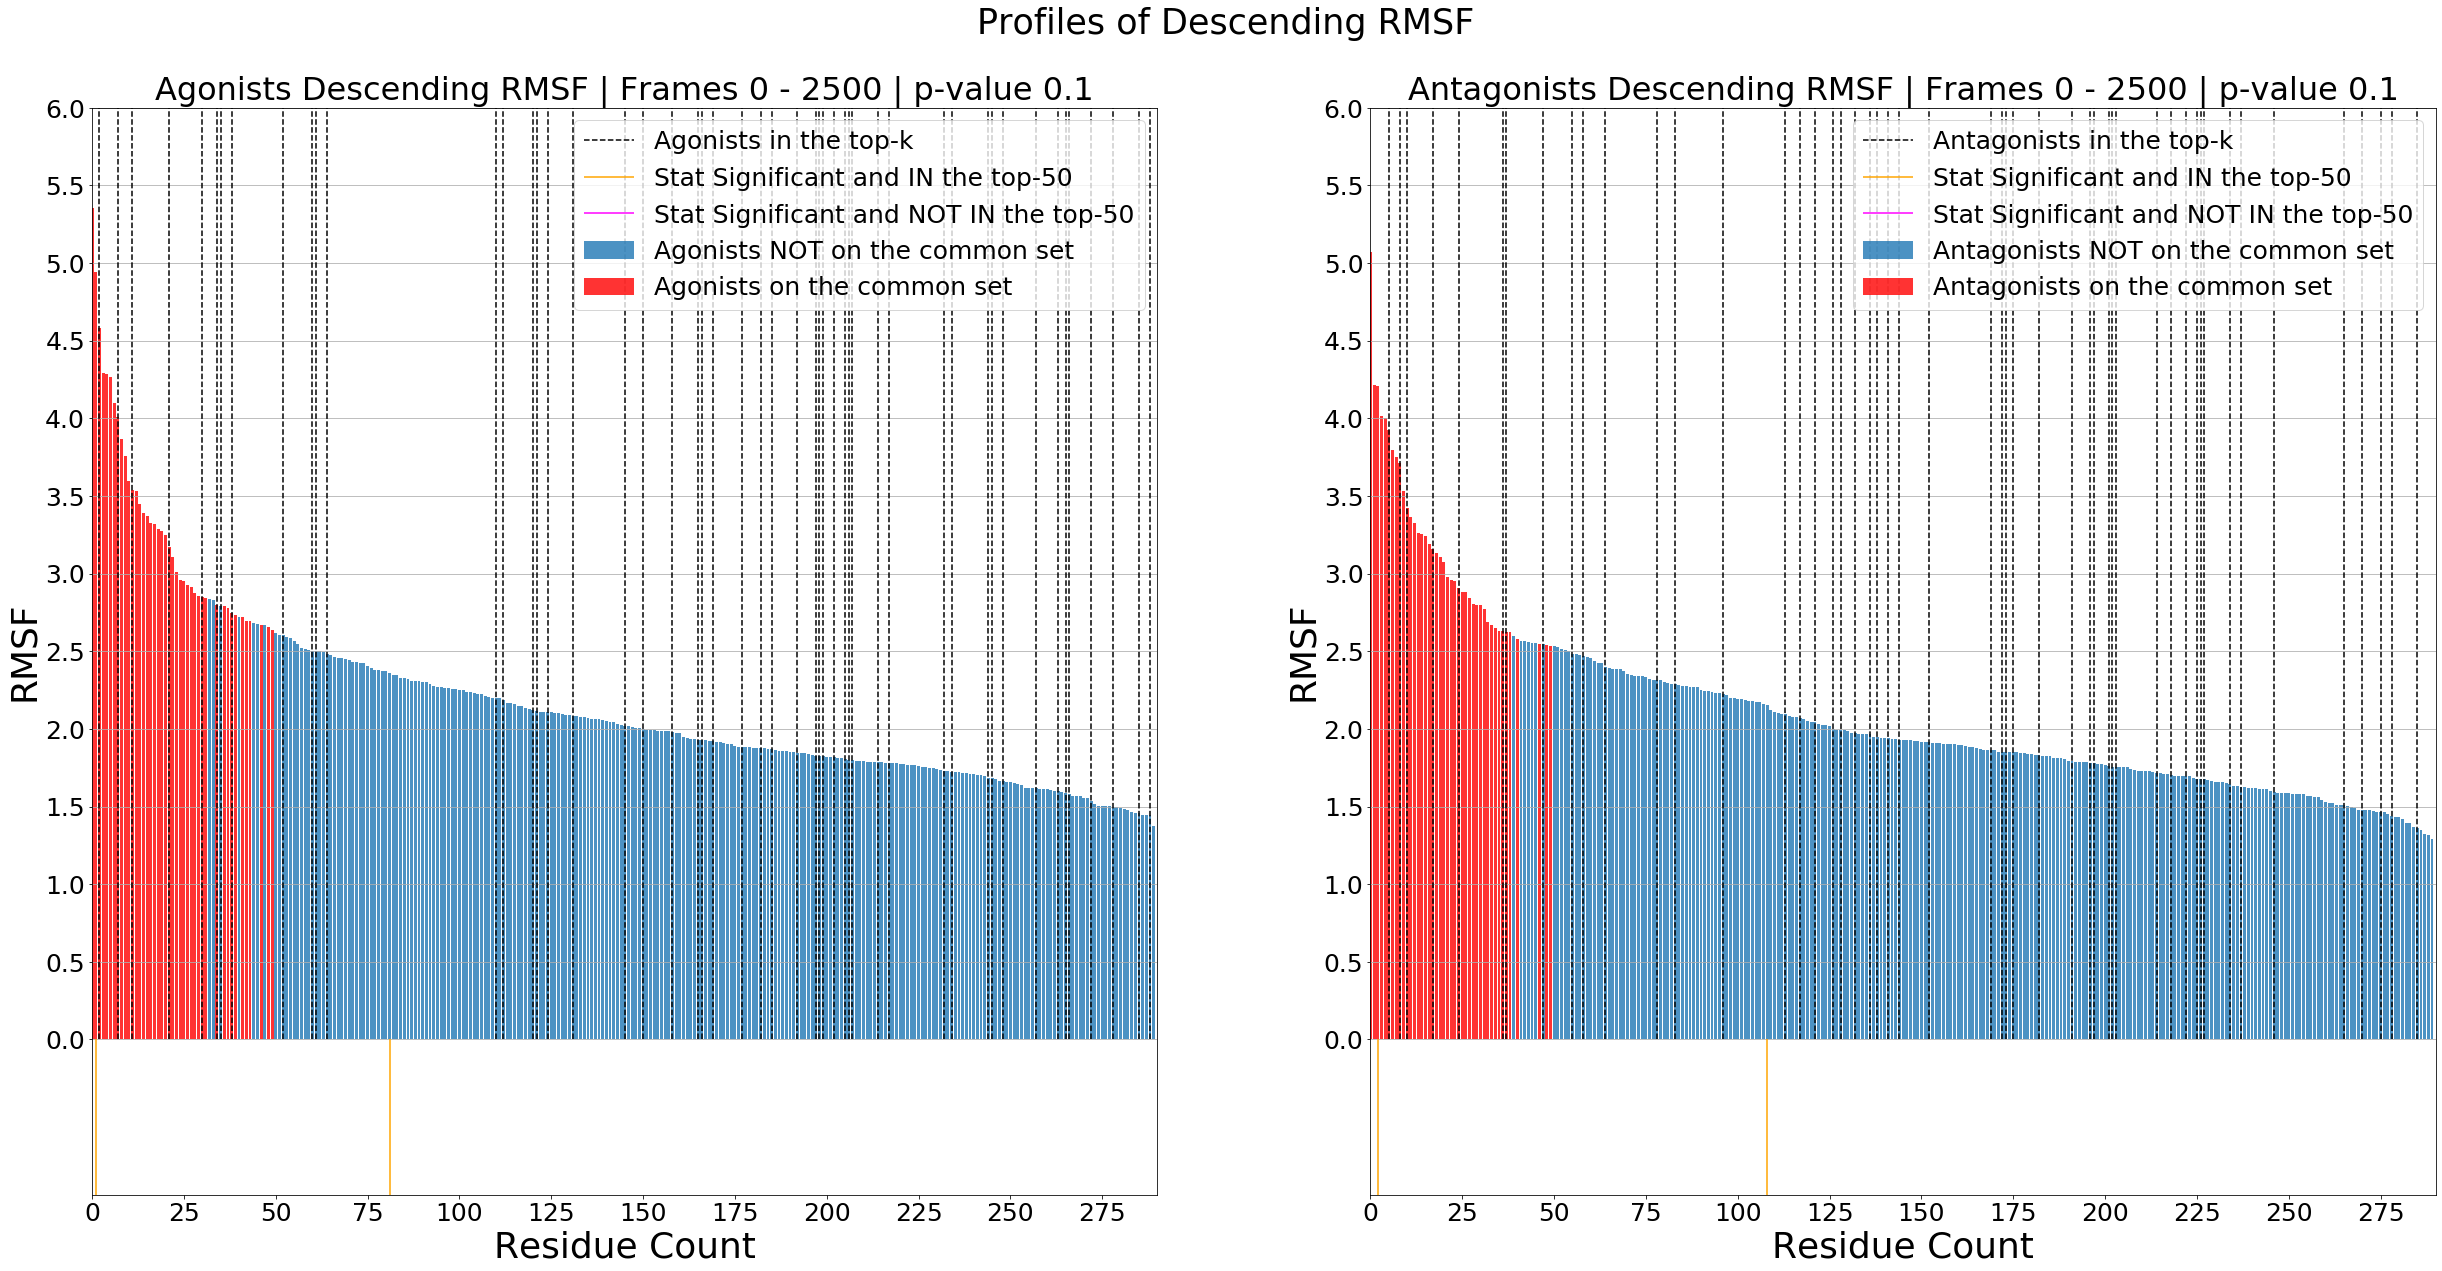

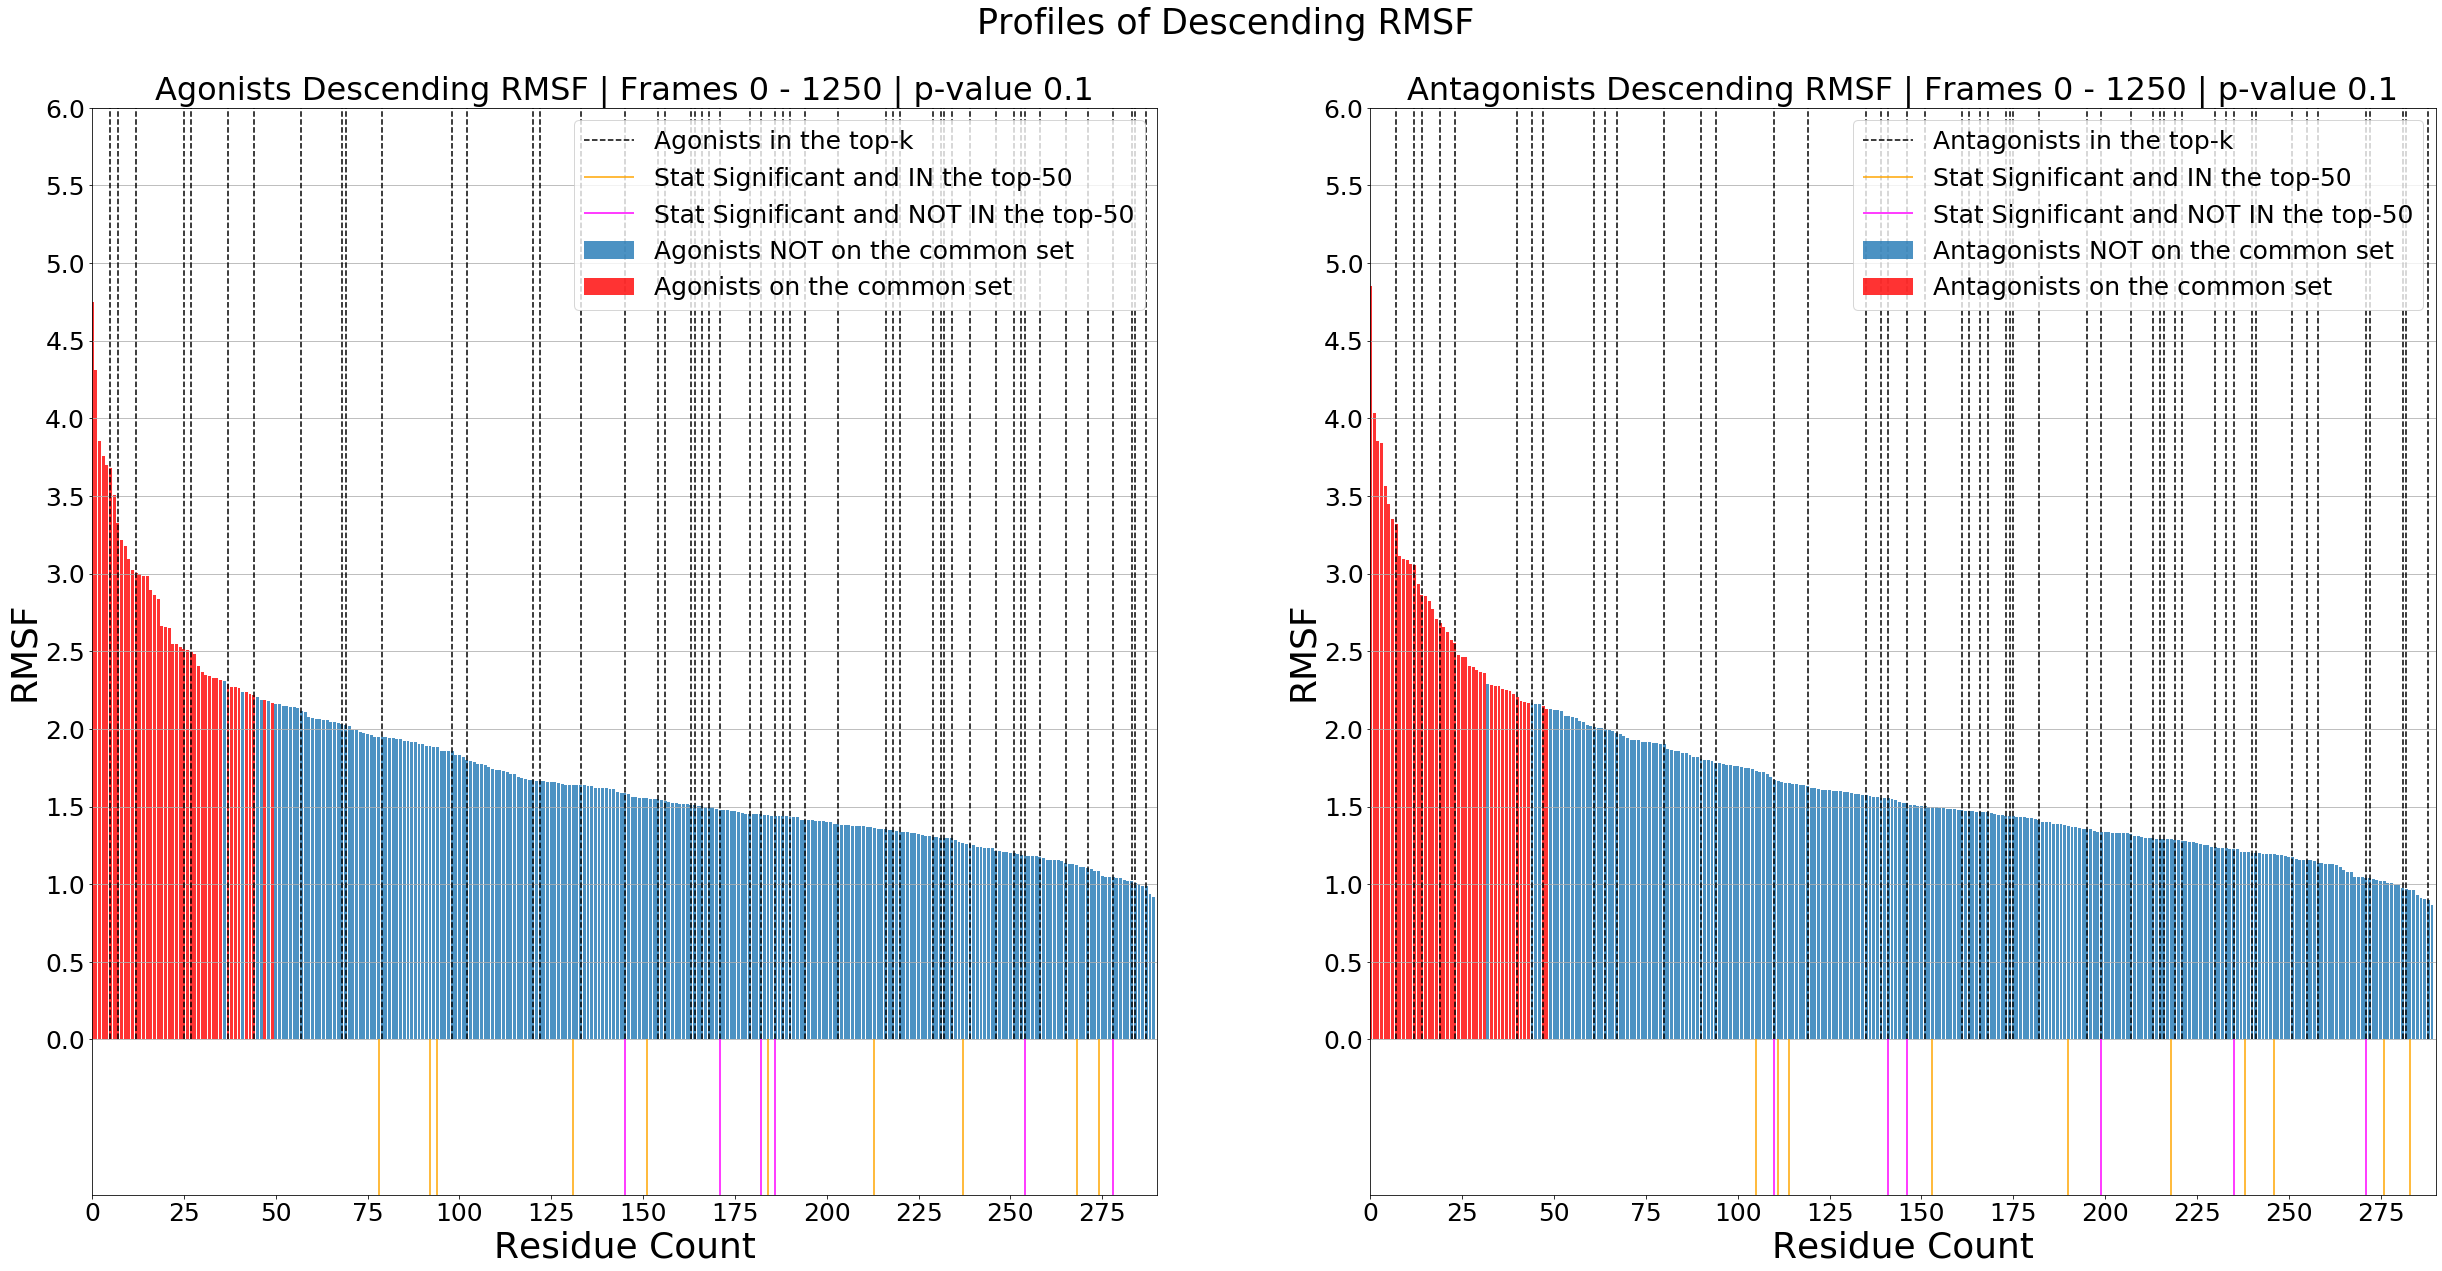

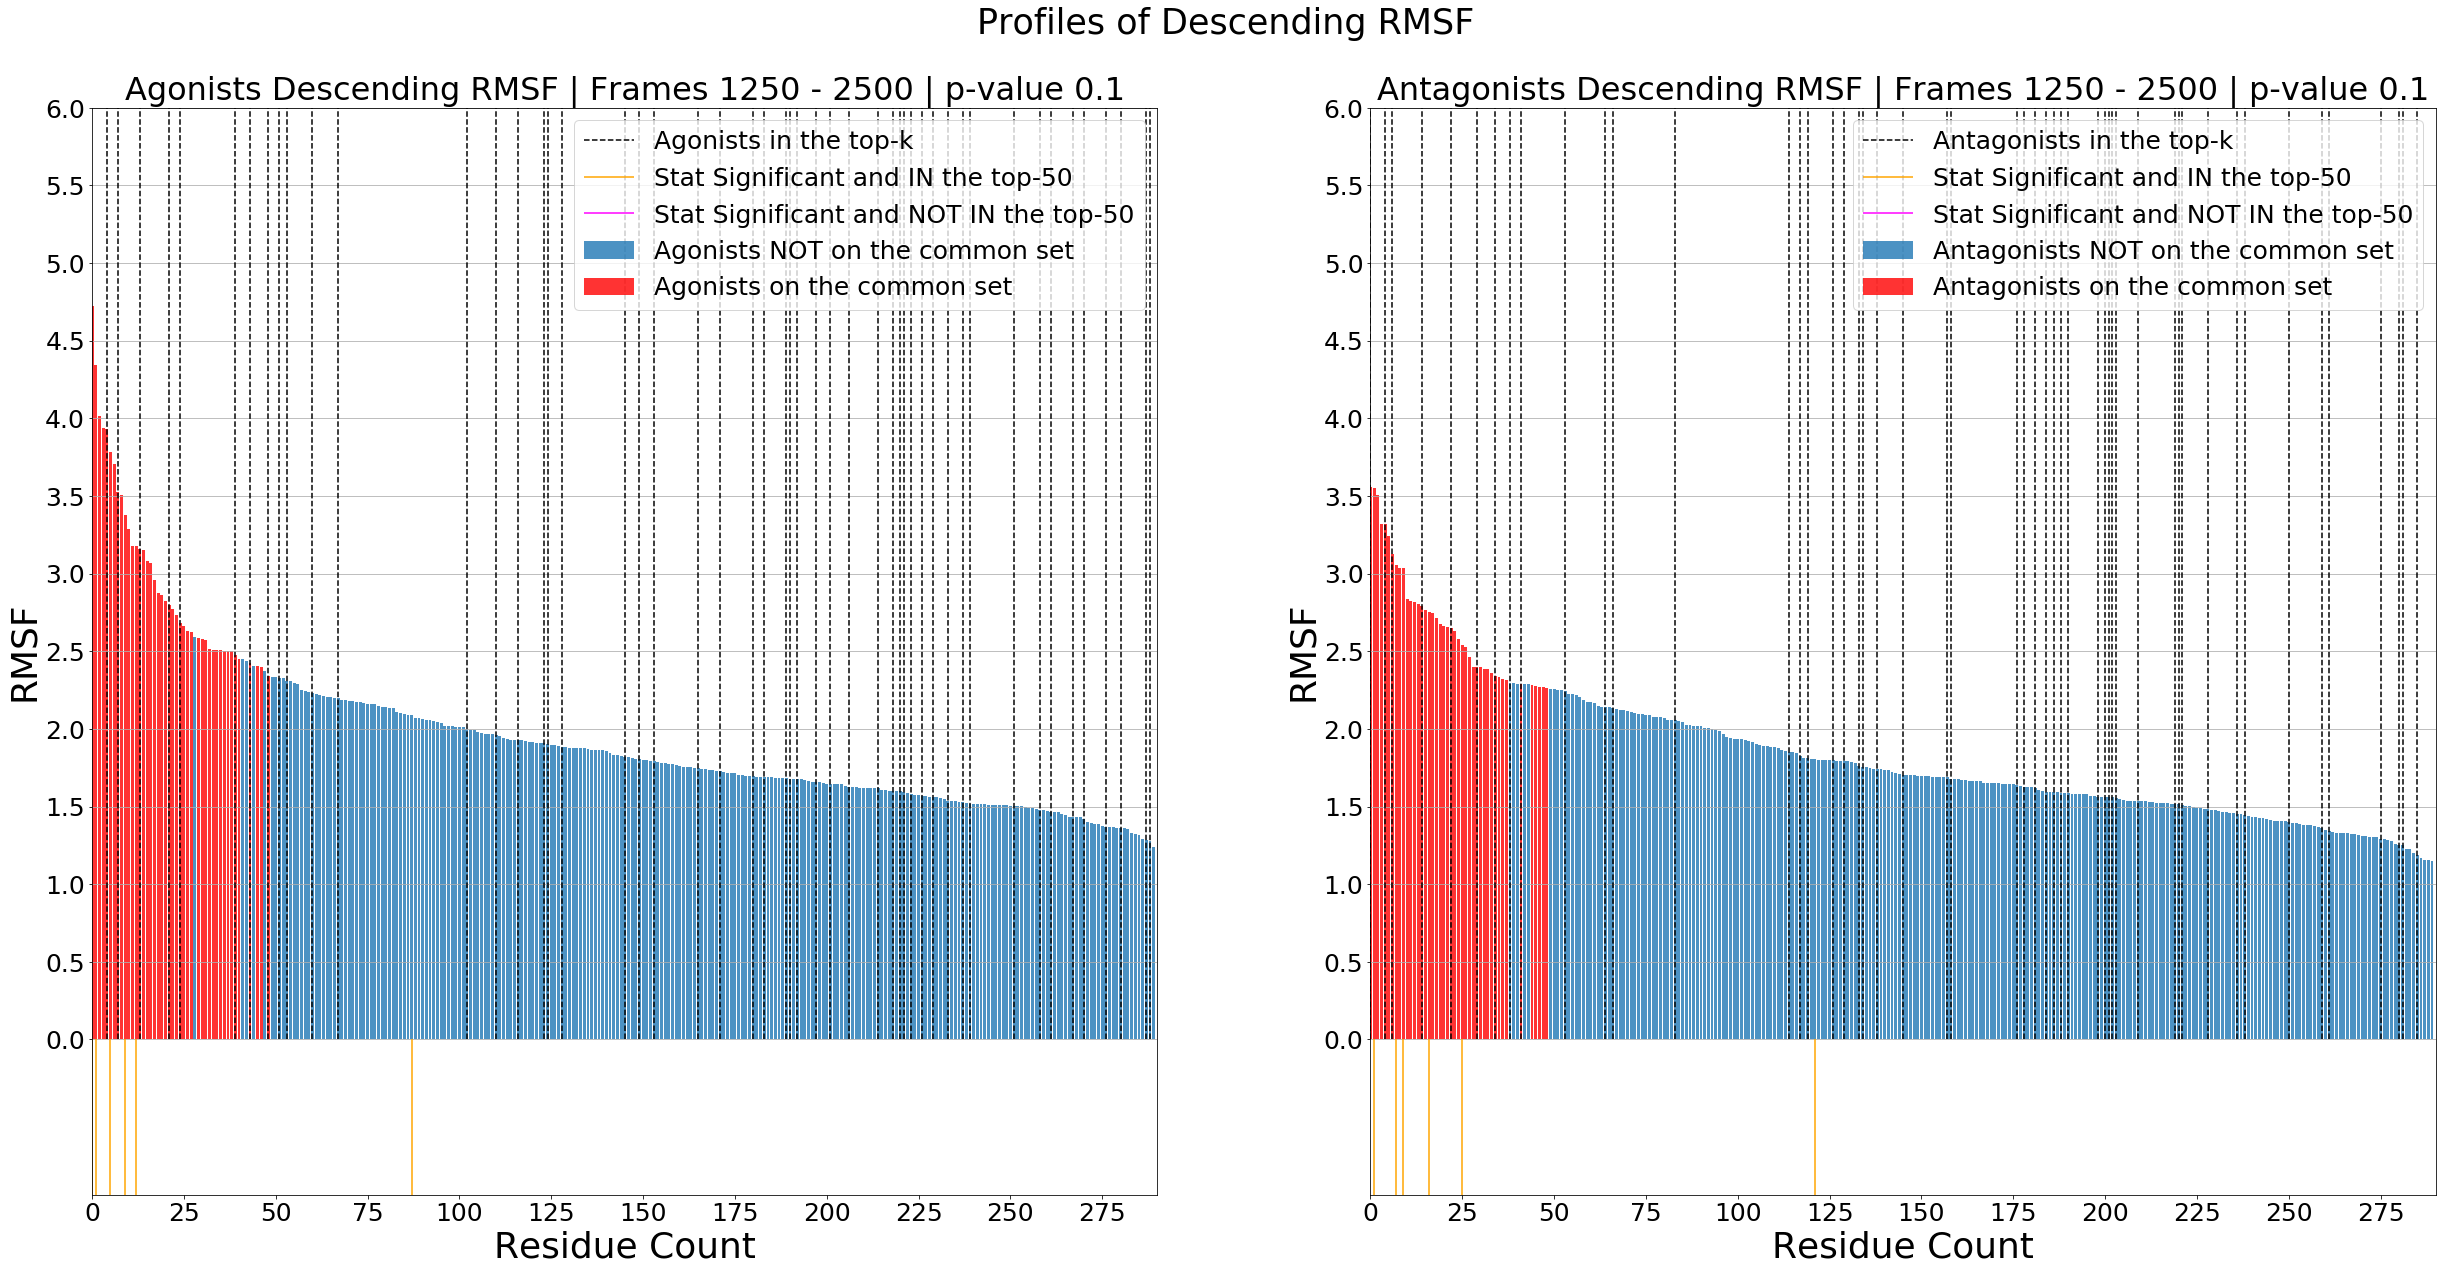

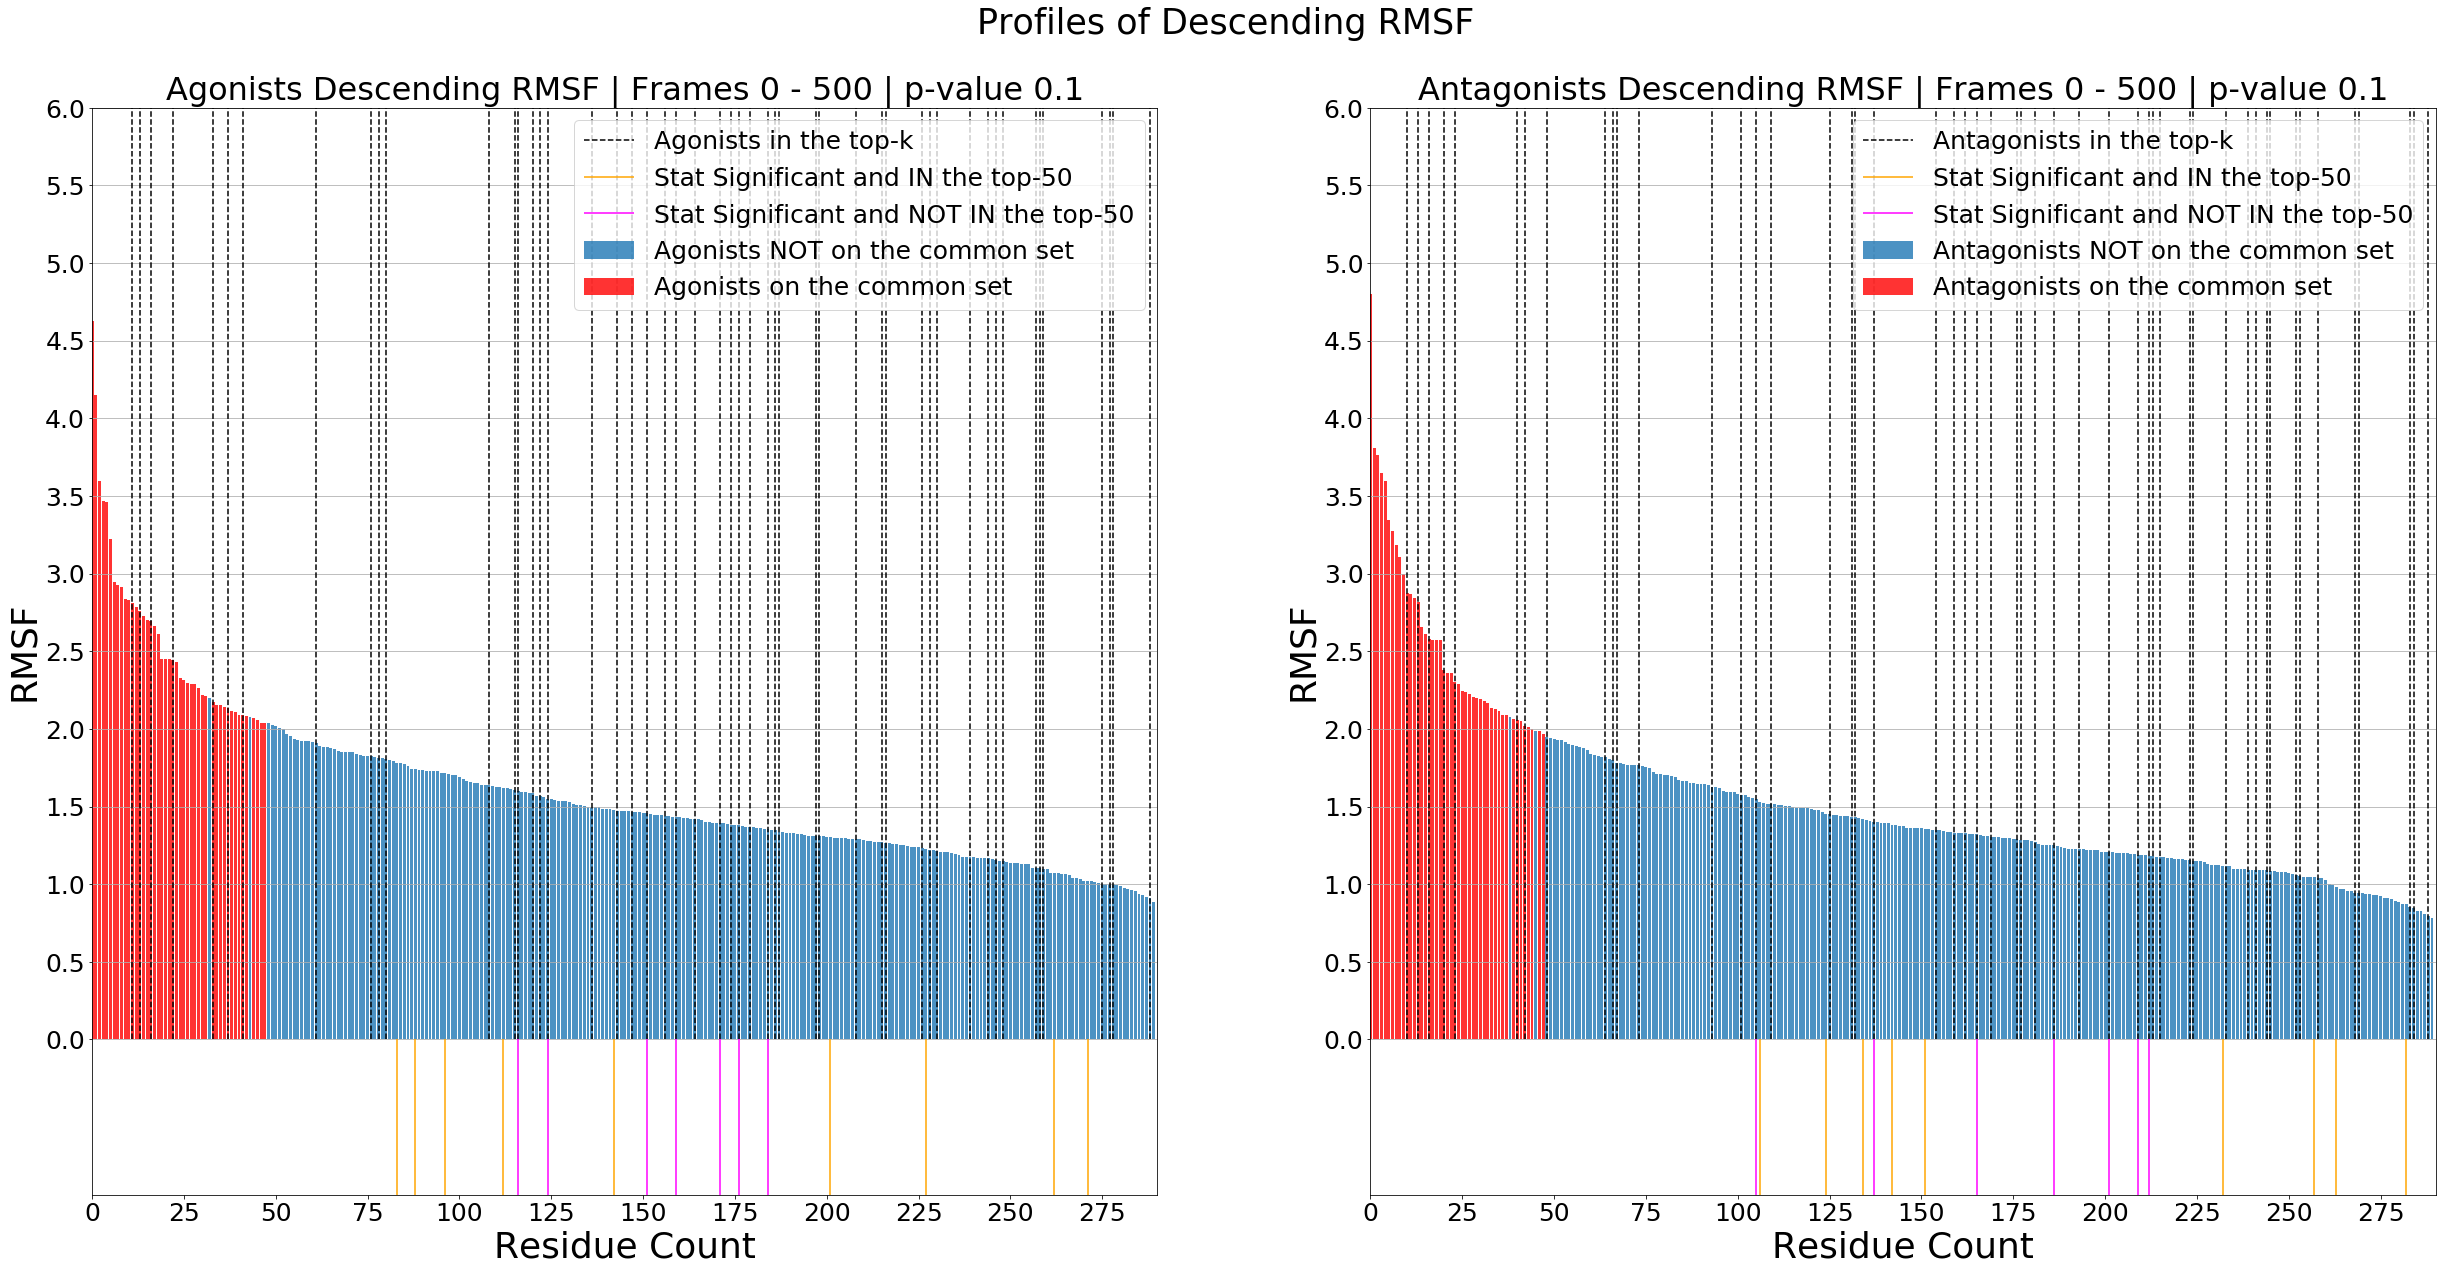

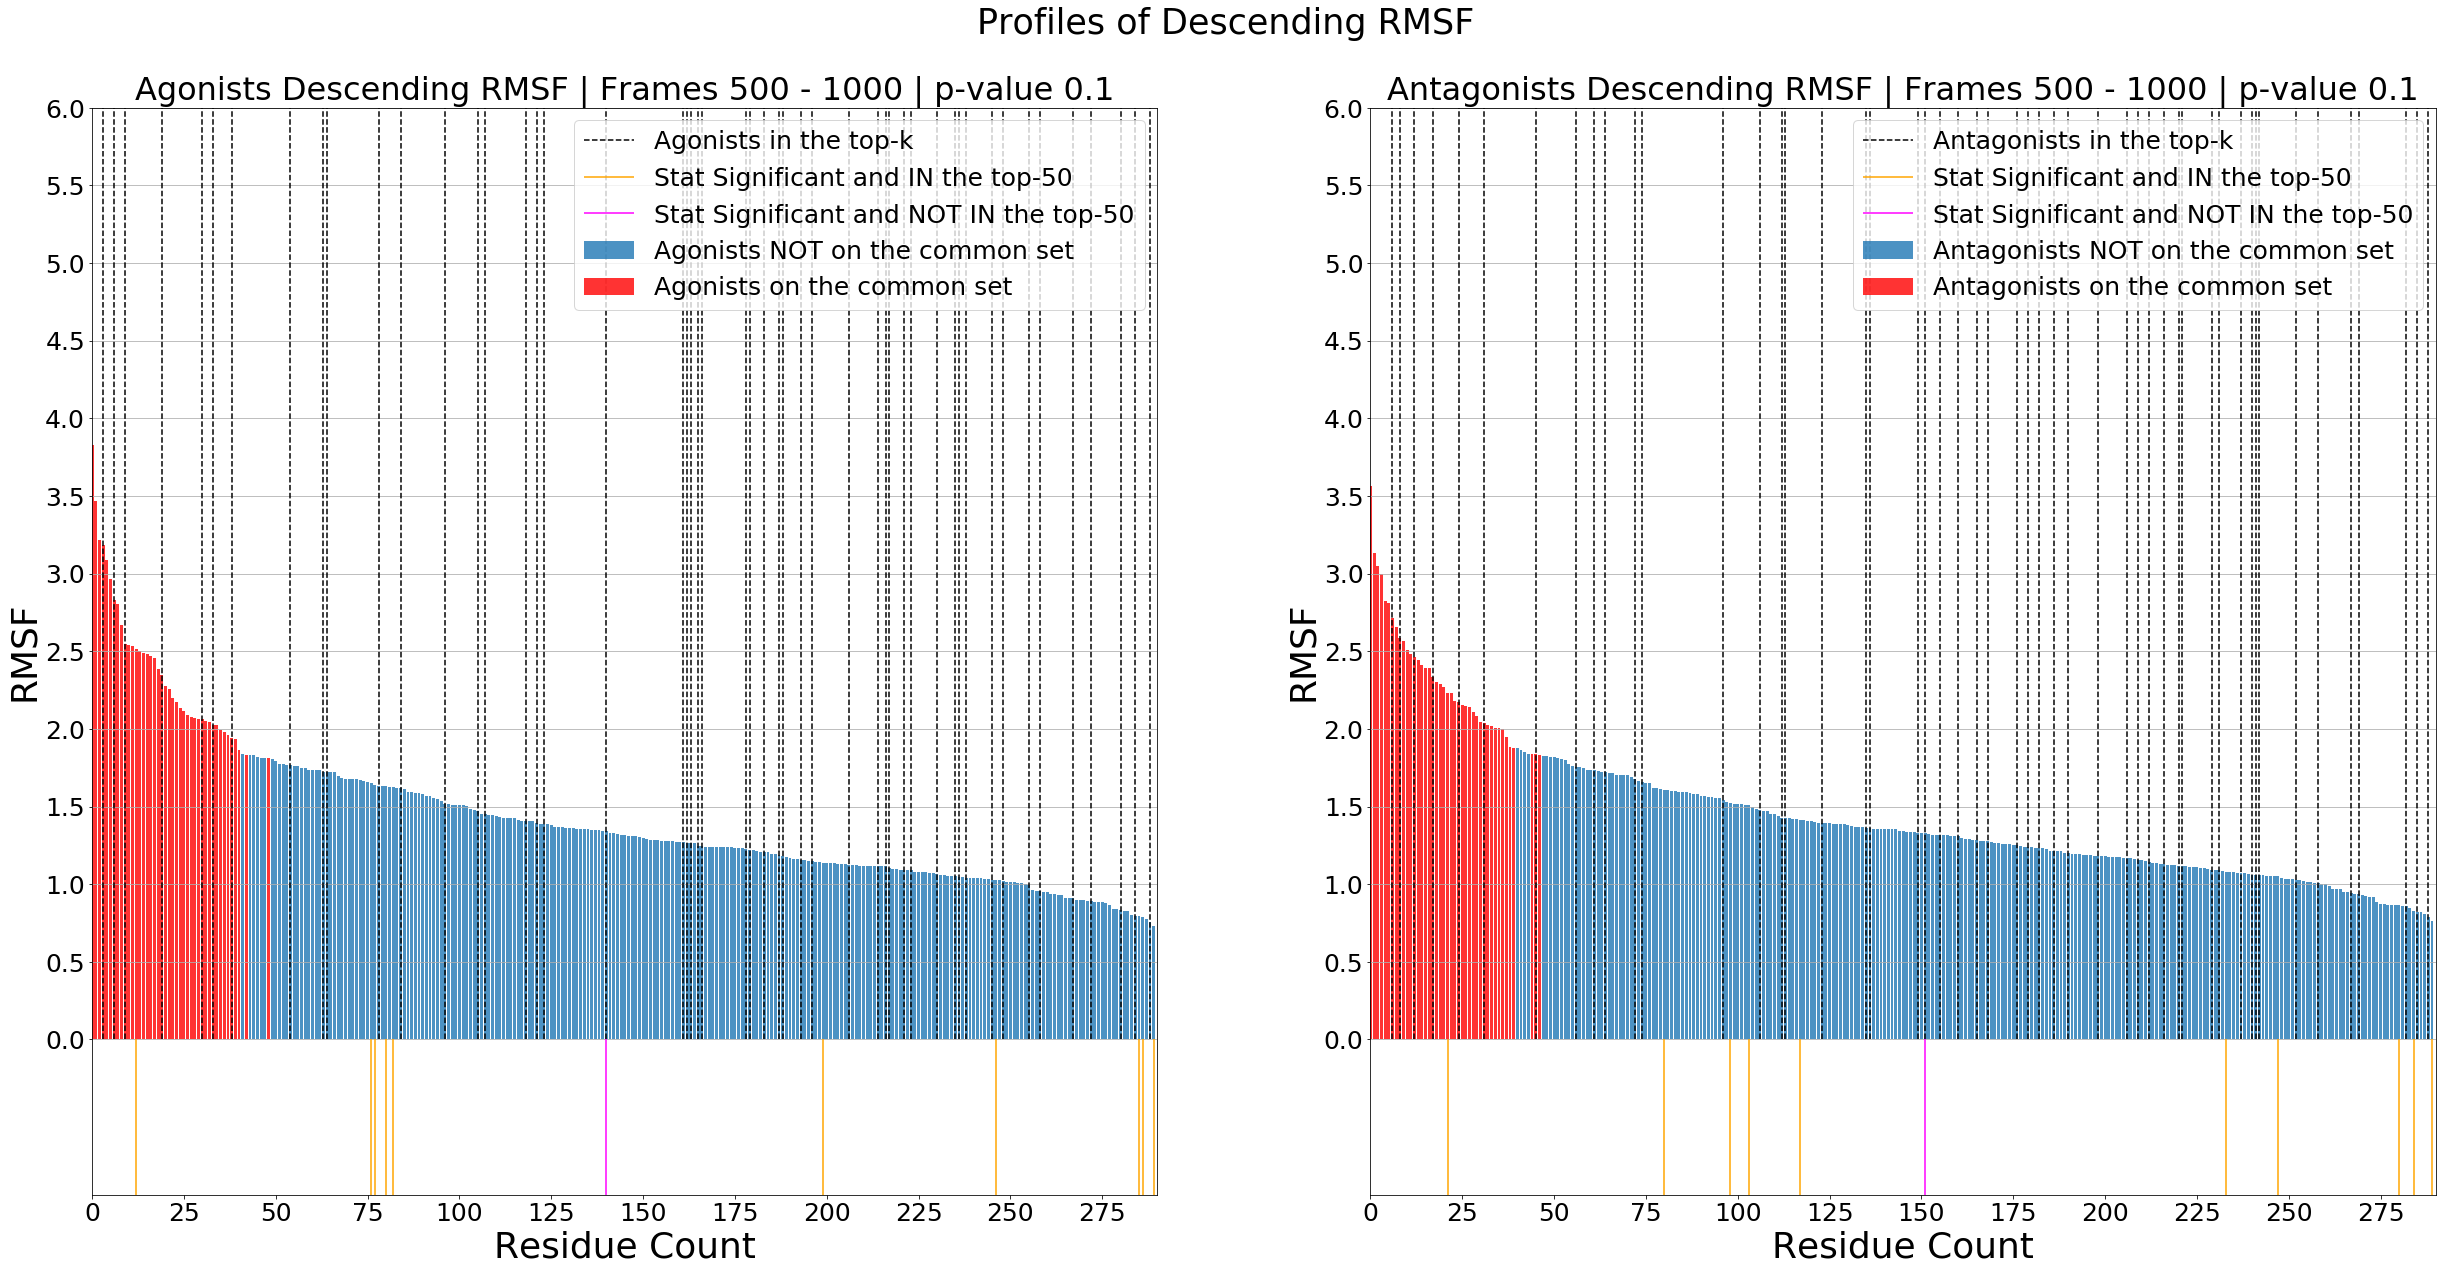

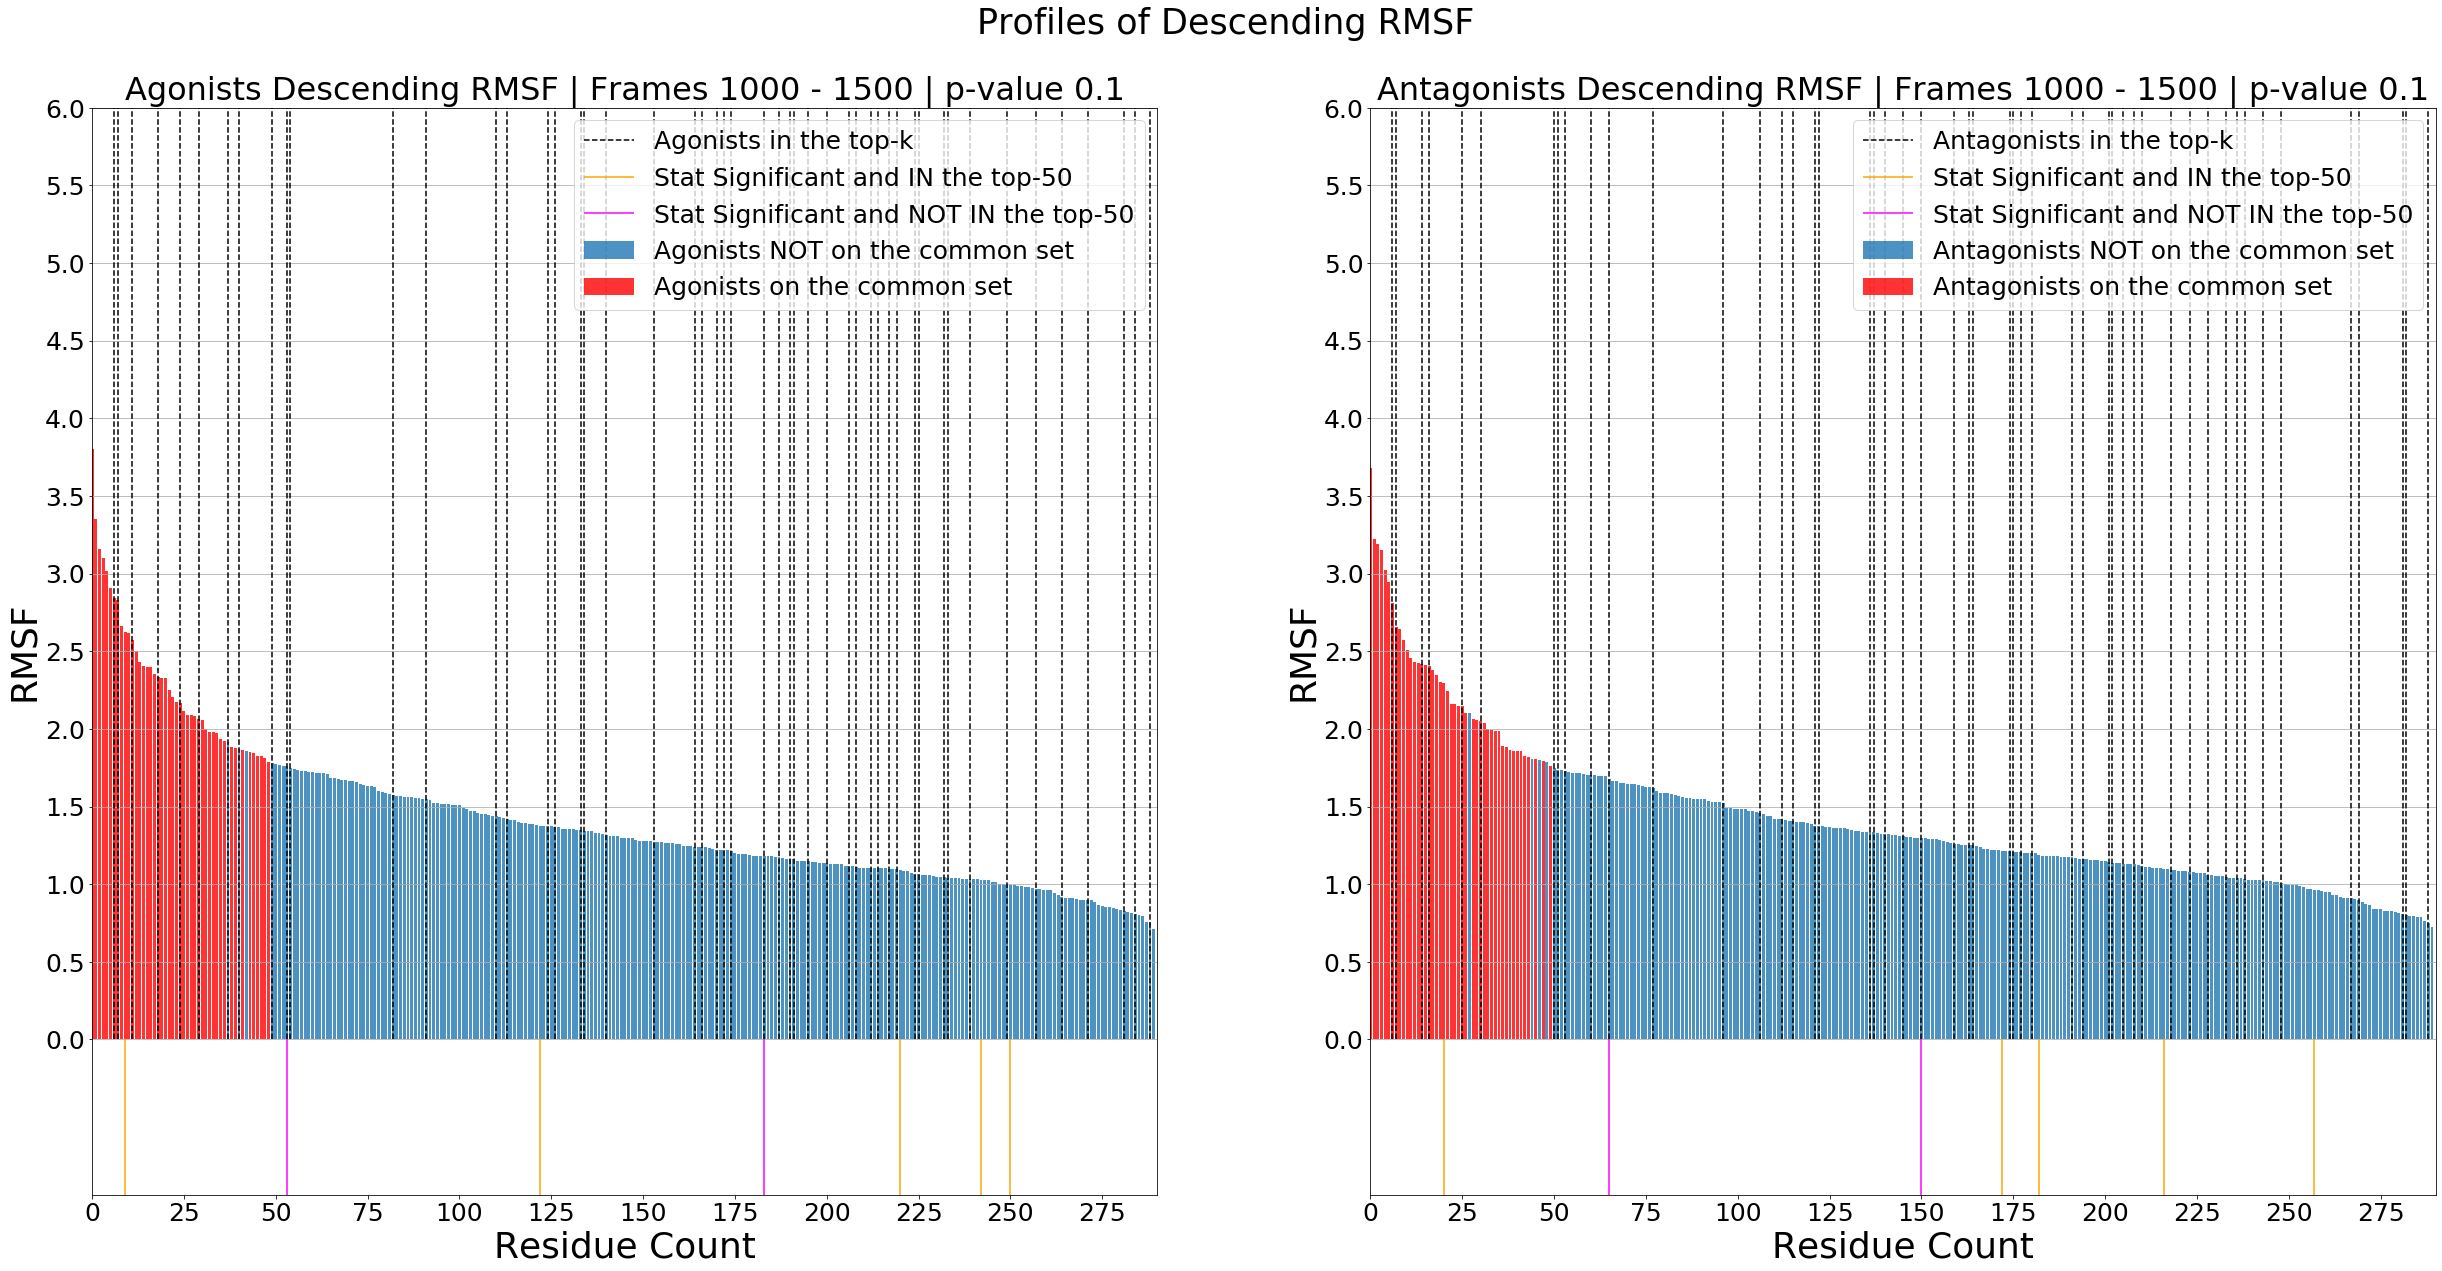

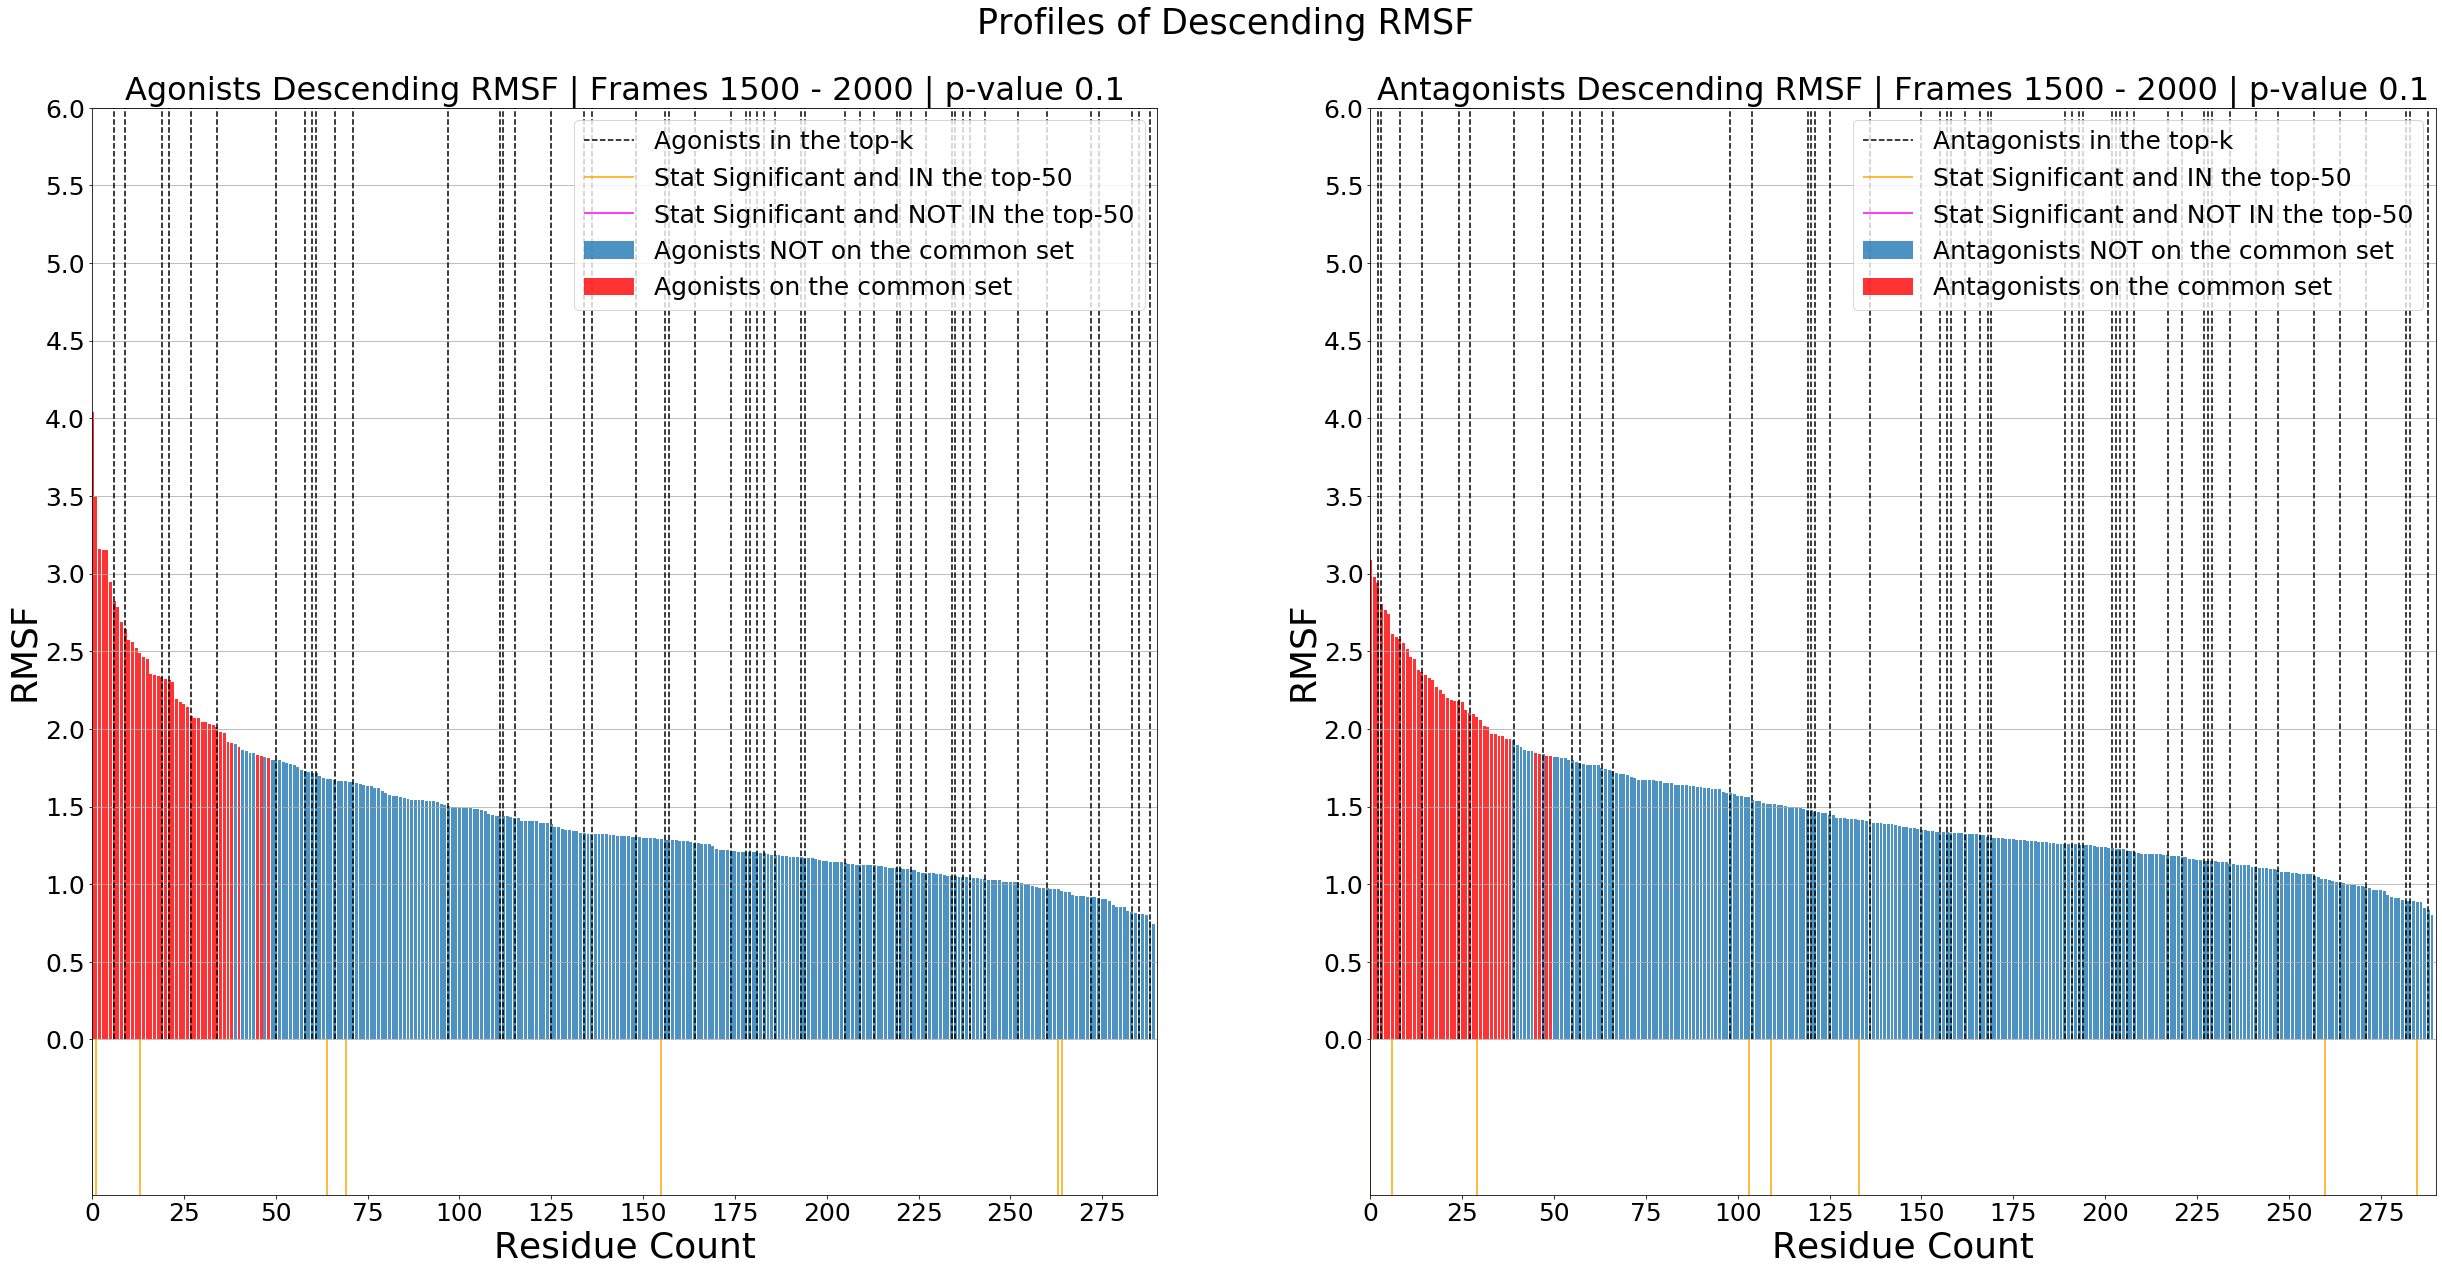

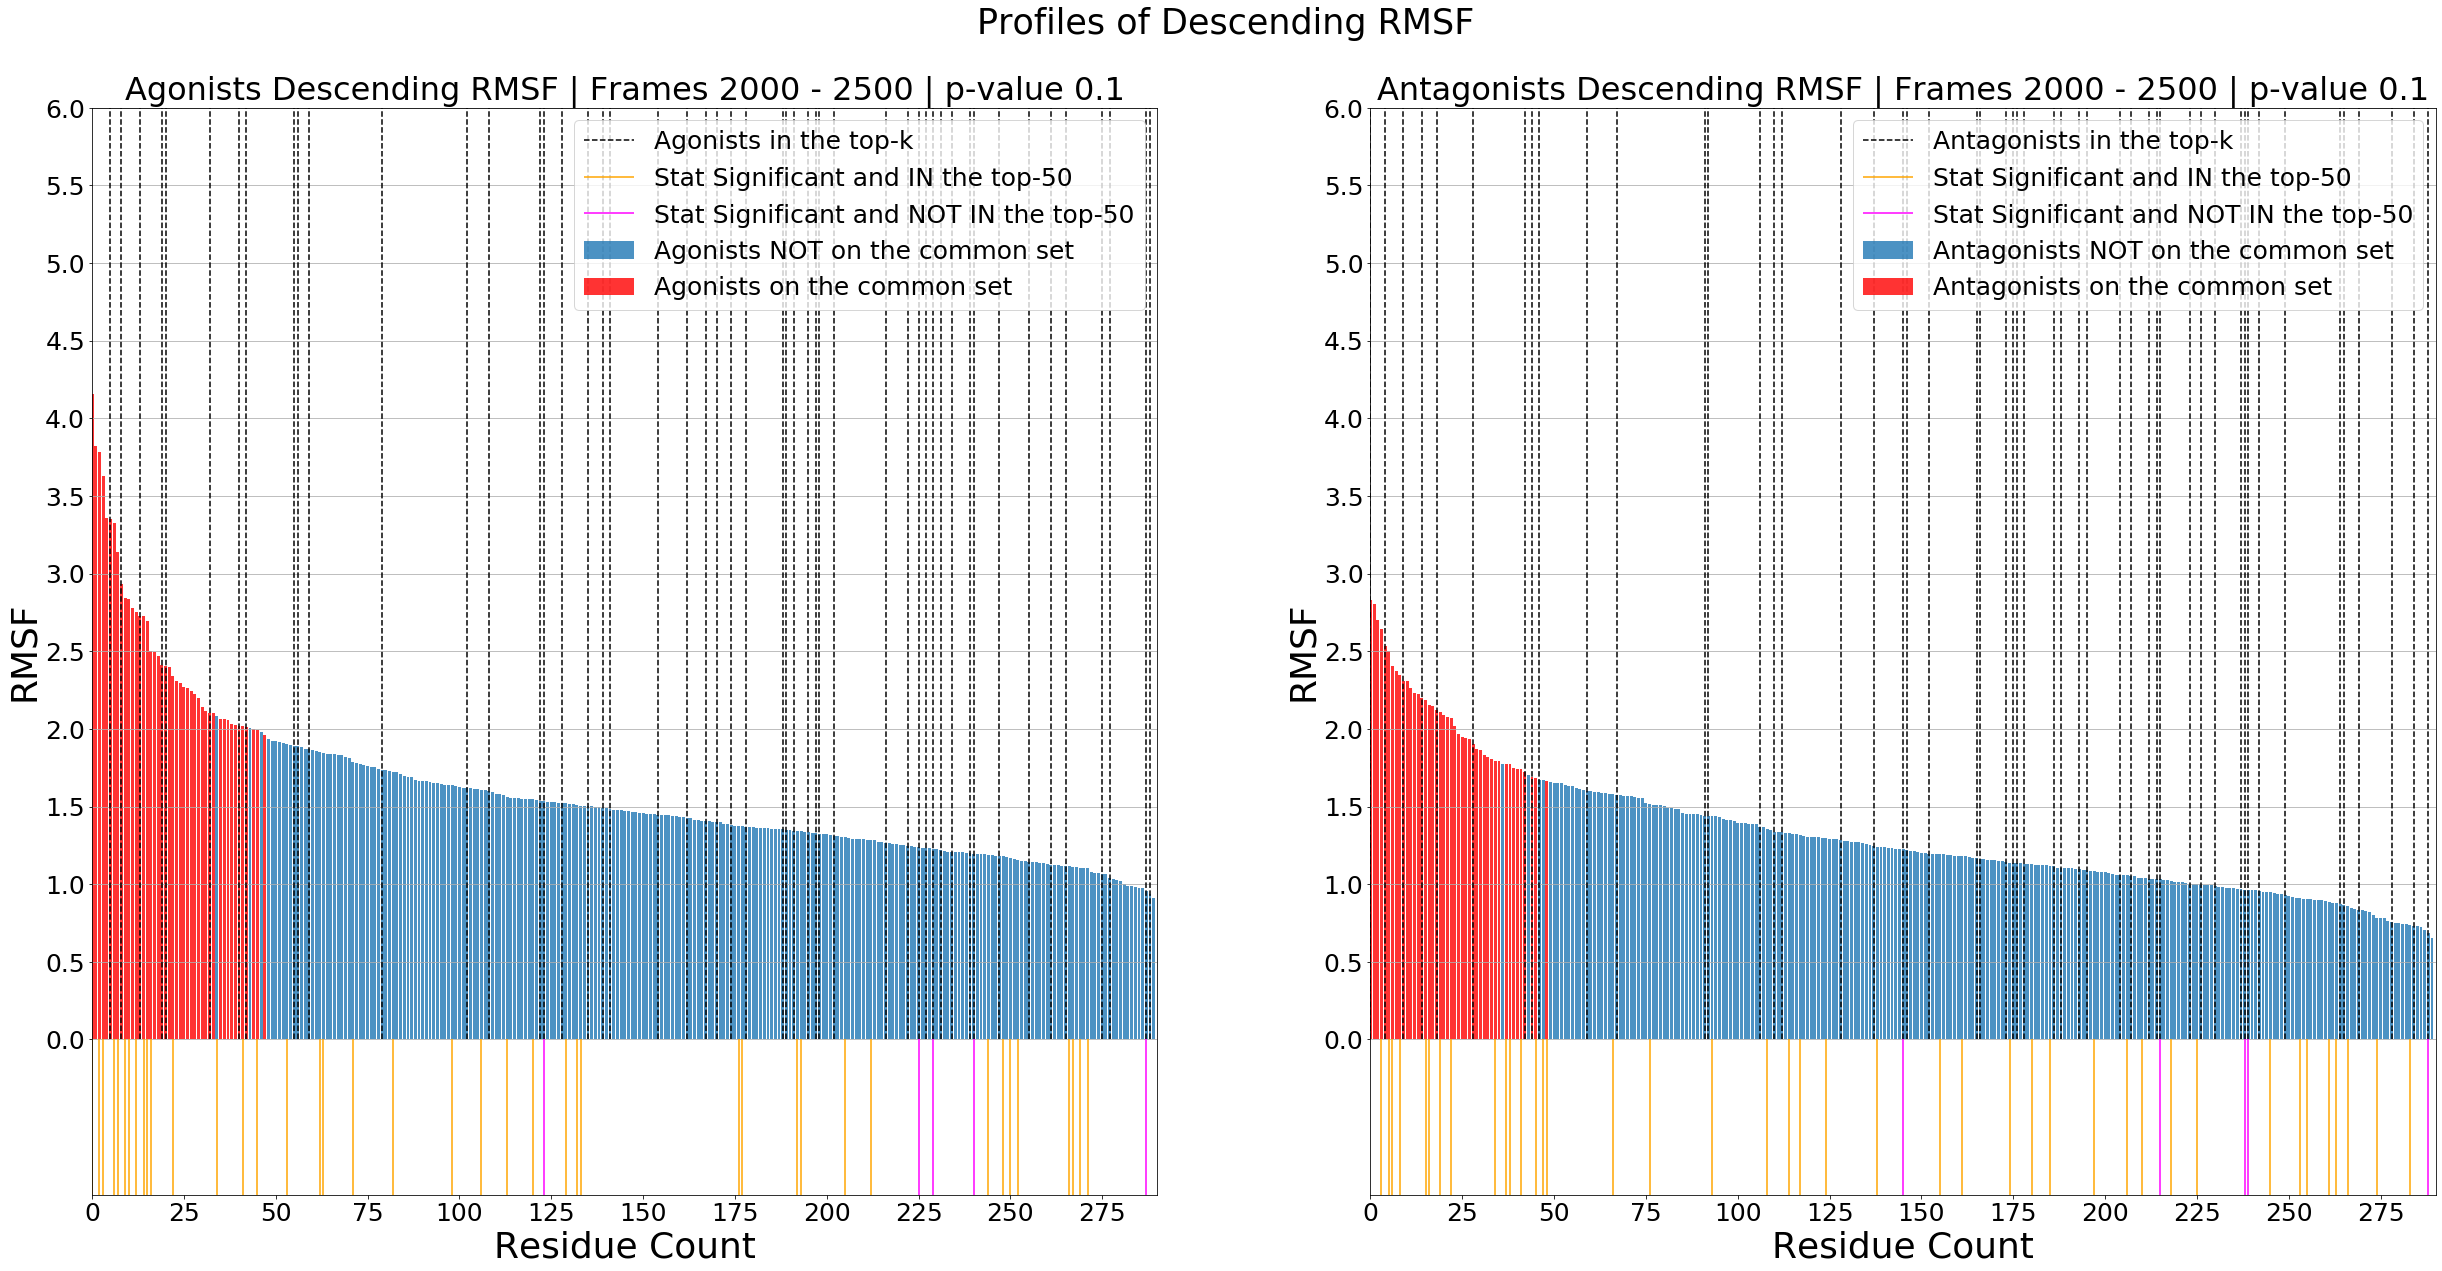

In [22]:
for threshold in [0.05, 0.1]:
    top_k_analysis(analysis_actors_dict, '../figures/RMSF/new/', top=50, start=0, stop=2500, threshold=threshold)
    top_k_analysis(analysis_actors_dict, '../figures/RMSF/new/', top=50, start=0, stop=1250, threshold=threshold)
    top_k_analysis(analysis_actors_dict, '../figures/RMSF/new/', top=50, start=1250, stop=2500, threshold=threshold)

    for start in np.arange(0, 2500, 500):
        top_k_analysis(analysis_actors_dict, '../figures/RMSF/new/', top=50, start=start, stop=start + 500, threshold=threshold)

### Bootstrap Analysis of Most Significant Residues

The above test gives us the most significant residues but we have no measure of the sensitivity of the significance. Meaning that if we change some ligands on the dataset we want our significant residues to remain the same.  
  
To do that we follow the below bootstrapping method:  
  
1. We pick 20 agonists and 20 antagonists (20 is a parameter and should change if our dataset size increases)
2. We randomly pick 12 agonists and 12 antagonists that will be our starting set. The other 8 and 8 will be our replacement pool.
3. We repeat for a given number of iterations:
    1. Find the union of the most significant residues on specific windows (currently 500 - 1000, 0 - 1500)
    2. Save the most significant residues
    3. Replace 1 agonist and 1 antagonist with a random ligand from their respective replacement pools
4. Calculate the sensitivity of the results

In [6]:
from MDSimsEval.rmsf_analysis import reset_rmsf_calculations
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue

def initialize_pools(ligands_list, total_ligands=20, set_ligands=12):
    """
    Inputs a list of ``MDSimsEval.AnalysisActor`` objects and returns initial input and replacement 
    sets of the given size.
    
    Args:
        ligands_List: List of ``MDSimsEval.AnalysisActor`` objects
        total_ligands(int): How many ligands will be used in the experiment (input + replacement sets sizes)
        set_ligands(int): How many ligands will be on the initial input set. The rest of them will be on the
        replacement set
        
    Returns:
        | Tuple of (List of ``MDSimsEval.AnalysisActor`` that will be our initial input set,
        |           List of ``MDSimsEval.AnalysisActor`` that will be our initial replacement set)

    """
    ligands_chosen = random.sample(ligands_list, total_ligands)
    
    chosen_random_ligands = random.sample(list(np.arange(len(ligands_chosen))), set_ligands)
    mask_set_ligands = np.array([which_lig in chosen_random_ligands
                      for which_lig in np.arange(total_ligands)])
    
    return list(np.array(ligands_chosen)[mask_set_ligands]), list(np.array(ligands_chosen)[~mask_set_ligands])
    
def replacement_swap(input_set, replacement_set, numb_of_replacements=1):
    """
    Performs given number of swaps between the input_set and the replacement_set.The swaps are inplace.
    
    Args:
        input_set: List of ``MDSimsEval.AnalysisActor`` that is our input set 
        replacement_set: List of ``MDSimsEval.AnalysisActor`` that is our replacement set
        
    """
    to_be_replaced_indexes = random.sample(list(np.arange(len(input_set))), numb_of_replacements)
    to_be_inputted_indexes = random.sample(list(np.arange(len(replacement_set))), numb_of_replacements)
    
    
    for replaced, inputted in zip(to_be_replaced_indexes, to_be_inputted_indexes):
        input_set[replaced], replacement_set[inputted] = replacement_set[inputted], input_set[replaced]
        
    return None

def minimal_stat_test(agons, antagons, stat_test, start, stop, threshold=0.05):
    """
    Inputs a list of agonists and a list of antagonists and finds the most significant residues. We do not return
    the p_value but only the residue ids.
    
    .. todo::

         RMSF calcualtions get repeated. I should in the near feature create a caching mechanism.
    
    Args:
        agons: List of ``MDSimsEval.AnalysisActor`` agonists
        antagons: List of ``MDSimsEval.AnalysisActor`` antagonists
        stat_test (scipy.stats): A statistical test method with the interface of scipy.stats methods
        start(int): The starting frame of the calculations
        stop(int): The stopping frame of the calculations
        threshold (float): The p-value threshold of the accepted and returned residues

        
    """
    reset_rmsf_calculations({'Agonists':agons, 'Antagonists':antagons}, start=start, stop=stop)
    
    stacked_agons_rmsf = np.array([get_avg_rmsf_per_residue(ligand) for ligand in agons])
    stacked_antagons_rmsf = np.array([get_avg_rmsf_per_residue(ligand) for ligand in antagons])
    
    # Get the p_value of each residue
    p_values = []
    for agon_res_rmsf, antagon_res_rmsf in zip(stacked_agons_rmsf.T, stacked_antagons_rmsf.T):
        p_values.append(stat_test(agon_res_rmsf,antagon_res_rmsf)[1])
        
    # Select the p_values that pass the threshold
    enumed_pvalues = np.array(list(enumerate(p_values)))
    enumed_pvalues = enumed_pvalues[enumed_pvalues[:, 1] <= threshold]
    
    return set(enumed_pvalues[:,0])

In [44]:
def bootstrapped_residue_analysis(analysis_actors_dict, windows, stat_test, threshold, input_size, replacement_size, iterations, replacements):
    """
    | This is the main method of finding the most significant RMSF residues in a general enough way in order to avoid
      overfitting.
    | To do that we follow the below bootstrapping method:  
  
    1. We pick ``input_size + replacement_size`` agonists and ``input_size + replacement_size`` antagonists
    2. We randomly pick ``input_size`` agonists and ``input_size`` antagonists that will be our input set.
    3. We repeat for a given number of iterations:
        1. Find the union of the most significant residues on specific windows
        2. Save the most significant residues
        3. Replace 1 agonist and 1 antagonist with a random ligand from their respective replacement pools
    4. Return the sensitivity of the results
    
    The returned sensitivity of each residue is calculated by calculating ``residue_appearances / iterations``.
    
    Args:
        analysis_actors_dict: ``{ "Agonists": List[AnalysisActor.class], "Antagonists": List[AnalysisActor.class] }``
        windows: List of (start, stop) tuples of each window
        stat_test (scipy.stats): A statistical test method with the interface of scipy.stats methods
        threshold (float): The p-value threshold of the accepted and returned residues
        input_size (int): The size of set for each class on which we will find the significant residues
        replacement_size (int): The size of the replacement set for each class
        iterations(int): How many times we will repeat the finding of the significant residues
    
    Returns: A dictionary of ``{ResidueId: Sensitivity}`` for all the residues that appeared at least on one iteration
        
    
    """
    # Create our initial input and replacement set for both agonist and antagonists
    inp_set_agon, rep_set_agon = initialize_pools(analysis_actors_dict['Agonists'], 
                                                  total_ligands=input_size + replacement_size, set_ligands=input_size)
    inp_set_antagon, rep_set_antagon = initialize_pools(analysis_actors_dict['Antagonists'], 
                                                        total_ligands=input_size + replacement_size, set_ligands=input_size)
    
    significant_residues_per_iter = []
    
    for i in tqdm(range(iterations), desc='Iterations'):
        iteration_residues = []
        for start, stop in windows:
            sign_residues = minimal_stat_test(inp_set_agon, inp_set_antagon, stat_test, start, stop, threshold)
            iteration_residues.append(sign_residues)
            
        
        # Extract the union of the significant residues from all the windows
        significant_residues_per_iter.append(set().union(*iteration_residues))
        
        
        # Perform the replacement of our bootstrap method
        replacement_swap(inp_set_agon, rep_set_agon, replacements)
        replacement_swap(inp_set_antagon, rep_set_antagon, replacements)
        
    # Calculate the sensitivity of each significant residue
    return significant_residues_per_iter

In [2]:
with open(r"cache/rmsf_pre_calc_samples_1.pkl", "rb") as input_file:
    res = pickle.load(input_file)

# print(res)

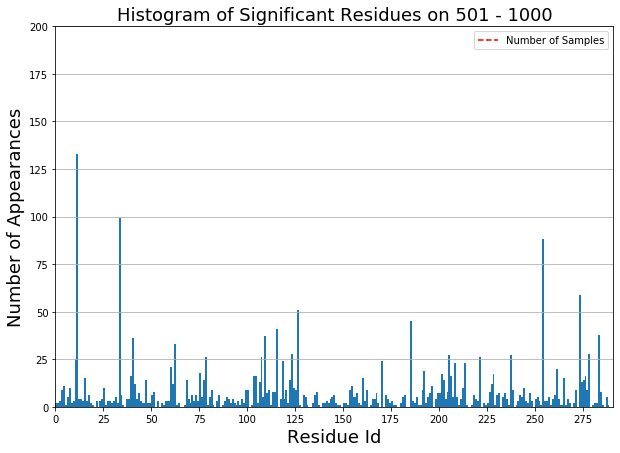

In [5]:
# res_list = [[k, v] for k,v in res.items()]

# # print(sorted(res_list, key=lambda x: x[1], reverse=True))
# print(pd.DataFrame(sorted(res_list, key=lambda x: x[1], reverse=True)).iloc[:10])
# print(res)

# Flattened_residues
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

flat_res = [residue for iteration_residues in res for residue in iteration_residues]


# print(flat_res)
plt.hist(flat_res, bins=np.arange(292))


plt.xlabel("Residue Id", fontsize=18)
plt.ylabel("Number of Appearances", fontsize=18)

plt.title("Histogram of Significant Residues on 501 - 1000", fontsize=18)
plt.xlim(0, 291)
plt.xticks(np.arange(0, 292, 25))
plt.ylim(0, 200)

ax.yaxis.grid()

plt.hlines(y=1000, xmin=0, xmax=291, color='red', linestyles='dashed', label="Number of Samples")

plt.legend()
plt.savefig('../figures/RMSF/new/rmsf_sign_hist_500_1000_samples_1000.png', format='png')

plt.show()

In [40]:
def sensitivity_calc(sign_residues_per_iter):
    sens_dict = {}
    for which_iter in sign_residues_per_iter:
        for which_res in which_iter:
            try:
                sens_dict[which_res] += 1
            except KeyError:
                sens_dict[which_res] = 1
                
    # Get the sensitivity by calculating residue_appearances / total_iterations
    sens_dict = {k: v / len(sign_residues_per_iter) for k, v in sens_dict.items()}
    
    return sens_dict

sensitivity_calc([{48.0, 105.0, 50.0, 115.0, 96.0, 51.0, 53.0, 54.0, 41.0}, {96.0, 225.0, 89.0, 41.0, 171.0, 47.0, 48.0, 50.0, 115.0, 51.0, 181.0, 118.0, 55.0, 20.0, 54.0, 93.0}])

{96.0: 1.0,
 105.0: 0.5,
 41.0: 1.0,
 48.0: 1.0,
 50.0: 1.0,
 115.0: 1.0,
 51.0: 1.0,
 53.0: 0.5,
 54.0: 1.0,
 225.0: 0.5,
 171.0: 0.5,
 47.0: 0.5,
 181.0: 0.5,
 118.0: 0.5,
 55.0: 0.5,
 20.0: 0.5,
 89.0: 0.5,
 93.0: 0.5}

### Bootstrap Analysis - Pre Calculated Bootstrap Samples

In [13]:
from MDSimsEval.rmsf_bootstrapped_analysis import minimal_stat_test

def bootstrap_rmsf_pre_calc_samples(analysis_actors_dict, start, stop, stat_test, threshold, samples_numb, sample_size):
    # Create the samples
    samples = []
    for i in range(samples_numb):
        samples.append(
            {'Agonists':random.sample(analysis_actors_dict['Agonists'], sample_size),
             'Antagonists':random.sample(analysis_actors_dict['Antagonists'], sample_size)}
        )
    
    rmsf_cache = {}
    residues_per_sample = []
    
    for sample in tqdm(samples, desc='Sample'):
        sign_residues = minimal_stat_test(sample['Agonists'], sample['Antagonists'], stat_test, start, stop, threshold, rmsf_cache)
    
        residues_per_sample.append(set(sign_residues))
    
    return residues_per_sample

res = bootstrap_rmsf_pre_calc_samples(analysis_actors_dict, 0, 500, stats.ks_2samp, 0.05, 3, 10)

In [18]:
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue
from MDSimsEval.rmsf_analysis import reset_rmsf_calculations

def create_correlation_df(analysis_actors_dict, residue_ids, method, start, stop, rmsf_cache=None):
    """
    Creates a ``numb_of_ligands x numb_of_ligands`` dataframe which has the pair correlations calculated
    on the rmsf of the given ``residue_ids``.
    
    The result is not in a readable format and should be passed in ``TODO``.
    
    Args:
        analysis_actors_dict: ``{ "Agonists": List[AnalysisActor.class], "Antagonists": List[AnalysisActor.class] }``
        residue_ids: List of residue ids that we want to use in order to calculate the calculations.
        Eg the top-k, high-k, most statistically significant.
        method (str): pearson, kendall, spearman
        start(int): The starting frame of the calculations
        stop(int): The stopping frame of the calculations
        rmsf_cache: Dictionary with key ``ligand_name_start_stop`` and value the RMSF run result. If set 
        to ``None`` no cache will be kept
        
    Returns:
        A ``pd.DataFrame`` which has the pair correlations of all the ligands
        
    """
    reset_rmsf_calculations(analysis_actors_dict, start, stop, rmsf_cache)
    
    # Calculating the RMSFs of each residue instead of each atom
    residue_rmsfs_agon = np.array([get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Agonists']])
    residue_rmsfs_antagon = np.array([get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Antagonists']])
    
    # We need the number of total residues to create the mask below
    residues_numb = len(residue_rmsfs_agon[0])
    
    # Create a True, False mask of the given residues
    top_mask = [res_id in residue_ids for res_id in np.arange(residues_numb)]
    
    # Creating a DataFrame which will have as columns the ligand names and as rows the residues
    rmsf_array = np.array([res_rmsf[top_mask] for res_rmsf in np.vstack((residue_rmsfs_agon, residue_rmsfs_antagon))])
    
    # Use only the first 5 chars of the ligand name for better visual results
    ligand_names = [ligand.drug_name[:5]
                    for ligand in analysis_actors_dict['Agonists'] + analysis_actors_dict['Antagonists']]
    rmsf_df = pd.DataFrame(rmsf_array.T, columns=ligand_names)
    
    # Create the correlation dataframe
    corr = rmsf_df.corr(method=method)
    
    return corr


def render_corr_df(corr_df, filepath):
    """
    Renders and saves a correlation heatmap which visually interpretable.
    
    .. figure:: ../_static/rmsf_corr.png
        :width: 600px
        :align: center
        :height: 250px
        :alt: rmsf corr figure missing

        Correlation heatmap, click for higher resolution.

    .. note::

         In order to save the as ``.png`` you must install ``wkhtmltopdf`` via ``sudo apt-get install wkhtmltopdf`` on
         your machine. Else the output will be in ``.html`` and can be viewed using any browser.
         
    Args:
        corr_df(pd.DataFrame): A DataFrame of pairwise correlations
        filepath(str): The full path the heatmap save location eg. ``/dir1/dir2/name_of_file``
         
    """
    html_render = corr_df.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2).render()
    
    # Saving the correlation matrix
    try:
        # If wkhtmltopdf is installed save the results as a .png
        imgkit.from_string(html_render, f"{filepath}.png")
    except IOError:
        # Save the html of the correlation map, which can be rendered by a browser
        with open(f"{filepath}.html", "w") as text_file:
            text_file.write(html_render)

def corr_of_significant_residues(analysis_actors_dict, sign_residues, start, stop, top, method='spearman',rmsf_cache=None):
    
    # Flatten the significant residues from a list of sets to a list
    flat_res = [residue for iteration_residues in sign_residues for residue in iteration_residues]
    
    # Find on how many iterations or samples each residue appears as significant
    res_frequencies={}
    for residue in flat_res:
        if residue in res_frequencies:
            res_frequencies[residue] += 1
        else:
            res_frequencies[residue] = 1
    
    res_frequencies = [[res_id, freq] for res_id, freq in res_frequencies.items()]
    
    # Keep only the top residues that have the biggest frequencies
    res_frequencies = sorted(res_frequencies, key=lambda x: x[1], reverse=True)[:top]
    
    # Create a list of the residue ids kept
    top_residues = [res_freq[0] for res_freq in res_frequencies]   
    
    corr = create_correlation_df(analysis_actors_dict, top_residues, method, start, stop, rmsf_cache)
    
    names_agon = {ligand.drug_name[:5] for ligand in analysis_actors_dict['Agonists']}
    names_antagon = {ligand.drug_name[:5] for ligand in analysis_actors_dict['Antagonists']}
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    
    ax = sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=0, annot_kws={"fontsize":8}, cbar=False)
    
    for tick_label in ax.get_yticklabels():
        tick_text = tick_label.get_text()
        
        if tick_text in names_agon:
            tick_label.set_color('blue')
        elif tick_text in names_antagon:
            tick_label.set_color('tab:orange')
        else:
            raise KeyError('Ligand tick label is unknown')
    
    for tick_label in ax.get_xticklabels():
        tick_text = tick_label.get_text()
        
        if tick_text in names_agon:
            tick_label.set_color('blue')
        elif tick_text in names_antagon:
            tick_label.set_color('tab:orange')
        else:
            raise KeyError('Ligand tick label is unknown')
            
    plt.title(f'Heatmap of LocalTop-{top}KS on {start} - {stop} of all the ligands', fontsize=18)
    
    plt.savefig(f'../figures/RMSF/final/corr_heatmap/{stop - start}/{top}/spear_corr_{start}_{stop}_{top}.png', format='png', bbox_inches='tight')
    
    plt.close()
#     render_corr_df(corr, f'../figures/RMSF/new/corr_heatmap/spear_corr_{start}_{stop}_different_window_orders.png')
    
#     return corr


for start in np.arange(0, 2500, 2500):
    with open(f"cache/same_20_20/rmsf_pre_calc_samples_{start}_{start + 2500}.pkl", "rb") as input_file:
            res = pickle.load(input_file)
    corr_of_significant_residues(analysis_actors_dict, res, start, start + 2500, 10, rmsf_cache=rmsf_cache)
    corr_of_significant_residues(analysis_actors_dict, res, start, start + 2500, 25, rmsf_cache=rmsf_cache)
    
for start in np.arange(0, 2500, 1250):
    with open(f"cache/same_20_20/rmsf_pre_calc_samples_{0}_{2500}.pkl", "rb") as input_file:
            res = pickle.load(input_file)
    
    corr_of_significant_residues(analysis_actors_dict, res, start, start + 1250, 10, rmsf_cache=rmsf_cache)
    corr_of_significant_residues(analysis_actors_dict, res, start, start + 1250, 25, rmsf_cache=rmsf_cache)

    
for start in np.arange(0, 2500, 500):
    with open(f"cache/same_20_20/rmsf_pre_calc_samples_{start}_{start+500}.pkl", "rb") as input_file:
            res = pickle.load(input_file)
    
    corr_of_significant_residues(analysis_actors_dict, res, start, start + 500, 10, rmsf_cache=rmsf_cache)
    corr_of_significant_residues(analysis_actors_dict, res, start, start + 500, 25, rmsf_cache=rmsf_cache)

/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:259: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:260: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:261: RuntimeWarning: invalid value encountered in double_scalars
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:264: RuntimeWarning: invalid value encountered in greater
  if np.all(box > 0.0) and alpha < 180.0 and beta < 180.0 and gamma < 180.0:


228


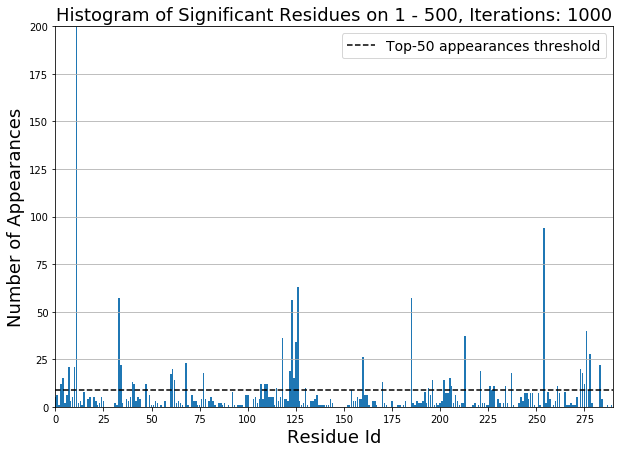

137


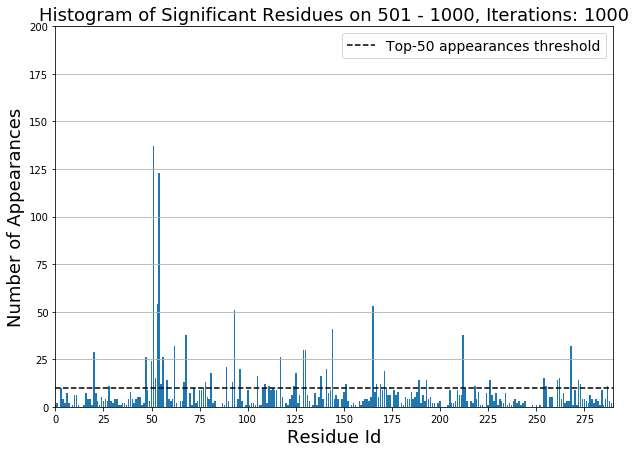

139


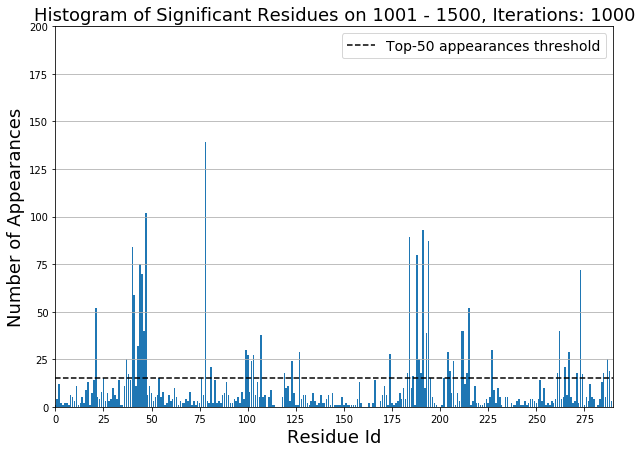

167


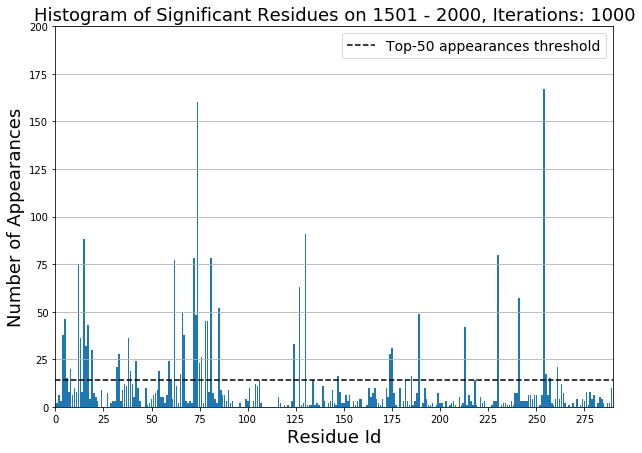

241


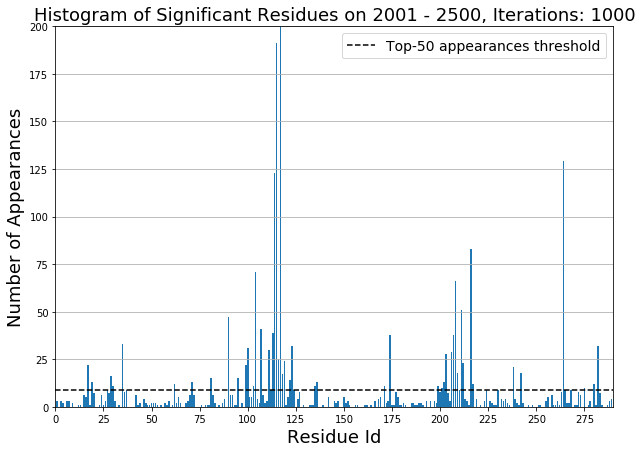

In [35]:
def hist_plot(start, stop):
    with open(f"cache/rmsf_pre_calc_samples_{start}_{stop}.pkl", "rb") as input_file:
        res = pickle.load(input_file)

    flat_res = [residue for iteration_residues in res for residue in iteration_residues]

    def find_top(flat_res):
        # Find on how many iterations or samples each residue appears as significant
        res_frequencies={}
        for residue in flat_res:
            if residue in res_frequencies:
                res_frequencies[residue] += 1
            else:
                res_frequencies[residue] = 1

        res_frequencies = [[res_id, freq] for res_id, freq in res_frequencies.items()]

        # Keep only the top residues that have the biggest frequencies
        res_frequencies = sorted(res_frequencies, key=lambda x: x[1], reverse=True)[:50]

        top_residues = map(int, [res_freq[0] for res_freq in res_frequencies])
        threshold = res_frequencies[-1][1]
        
        print(res_frequencies[0][1])

        return top_residues, threshold

    # Flattened_residues
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)

    top_res, thresh = find_top(flat_res)

#     common_res = list(set(top_res_0_500).intersection(top_res_500_1000))


    freqs = np.zeros((290))
    for i in flat_res:
        freqs[int(i)] += 1

#     freqs_500_1000 = np.zeros((290))
#     for i in flat_res_500_1000:
#         freqs_500_1000[int(i)] += 1

#     not_common_top = list(set(np.arange(290)).difference(common_res))

    plt.bar(np.arange(290), freqs)
#     plt.bar(common_res, np.array(freqs_0_500)[common_res], color='red', label='Common top residues of 1 - 500, 501 - 1000')

    plt.hlines(y=thresh, xmin=0, xmax=290, linestyles='dashed', color='black', label="Top-50 appearances threshold")

    plt.xlabel("Residue Id", fontsize=18)
    plt.ylabel("Number of Appearances", fontsize=18)

    plt.title(f"Histogram of Significant Residues on {start + 1} - {stop}, Iterations: 1000", fontsize=18)
    plt.xlim(0, 290)
    plt.xticks(np.arange(0, 290, 25))
    plt.ylim(0, 200)

    ax.yaxis.grid()


    plt.legend(prop={'size': 14}, markerscale=2, loc=1)
    plt.savefig(f'../figures/RMSF/new/rmsf_sign_hist_{start}_{stop}_samples_1000.png', format='png')

    plt.show()

for start in np.arange(0, 2500, 500):
    hist_plot(start, start + 500)


### Find Common Residues on top-k, significant-k

In [25]:
def common_residues(analysis_actors_dict, start, stop):
    with open(f"cache/rmsf_pre_calc_samples_{start}_{stop}.pkl", "rb") as input_file:
        res = pickle.load(input_file)

    flat_res = [residue for iteration_residues in res for residue in iteration_residues]

    def find_top(flat_res):
        # Find on how many iterations or samples each residue appears as significant
        res_frequencies={}
        for residue in flat_res:
            if residue in res_frequencies:
                res_frequencies[residue] += 1
            else:
                res_frequencies[residue] = 1

        res_frequencies = [[res_id, freq] for res_id, freq in res_frequencies.items()]

        # Keep only the top residues that have the biggest frequencies
        res_frequencies = sorted(res_frequencies, key=lambda x: x[1], reverse=True)[:50]

        top_residues = map(int, [res_freq[0] for res_freq in res_frequencies])
        threshold = res_frequencies[-1][1]

        return set(top_residues), threshold

    top_res, thresh = find_top(flat_res)

    from MDSimsEval.rmsf_analysis import reset_rmsf_calculations
    from MDSimsEval.rmsf_analysis import return_top_k
    from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue

    reset_rmsf_calculations(analysis_actors_dict, start, stop)
    
    # Calculate avg RMSF per residue
    residue_rmsfs_agon = np.array(
        [get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Agonists']])
    residue_rmsfs_antagon = np.array(
        [get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Antagonists']])

    # Average per residue
    residue_rmsfs_agon_avg = np.mean(residue_rmsfs_agon, axis=0)
    residue_rmsfs_antagon_avg = np.mean(residue_rmsfs_antagon, axis=0)

    # reset_rmsf_calculations(analysis_actors_dict, 0, 500)

    top_k = set(return_top_k(np.abs(residue_rmsfs_agon_avg - residue_rmsfs_antagon_avg), analysis_actors_dict, k=50).ResidueId)

    common_residues = top_res.intersection(top_k)

    print(f'Window {start} - {stop}: {len(common_residues)}')

with open(f"cache/selected_agonists.pkl", "rb") as input_file:
        agon_names = set(pickle.load(input_file))
agonists = [agon for agon in analysis_actors_dict['Agonists'] if agon.drug_name in agon_names]

with open(f"cache/selected_antagonists.pkl", "rb") as input_file:
        antagon_names = set(pickle.load(input_file))
antagonists = [antagon for antagon in analysis_actors_dict['Antagonists'] if antagon.drug_name in antagon_names]

for start in np.arange(0, 2500, 500):
    common_residues({"Agonists": agonists, "Antagonists": antagonists}, start, start + 500)

/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:259: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:260: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:261: RuntimeWarning: invalid value encountered in double_scalars
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:264: RuntimeWarning: invalid value encountered in greater
  if np.all(box > 0.0) and alpha < 180.0 and beta < 180.0 and gamma < 180.0:


KeyboardInterrupt: 

In [38]:
def find_top(flat_res, top):
    # Find on how many iterations or samples each residue appears as significant
    res_frequencies={}
    for residue in flat_res:
        if residue in res_frequencies:
            res_frequencies[residue] += 1
        else:
            res_frequencies[residue] = 1

    res_frequencies = [[res_id, freq] for res_id, freq in res_frequencies.items()]

    # Keep only the top residues that have the biggest frequencies
    res_frequencies = sorted(res_frequencies, key=lambda x: x[1], reverse=True)[:top]

    top_residues = [[int(res_freq[0]), res_freq[1]] for res_freq in res_frequencies]
    
    
    threshold = res_frequencies[-1][1]

    return top_residues, threshold

def find_common_res():
    residues = []
    for start in np.arange(0, 2500, 1250):
        with open(f"cache/rmsf_pre_calc_samples_{start}_{start+1250}.pkl", "rb") as input_file:
            res = pickle.load(input_file)
        
        flat_res = [residue for iteration_residues in res for residue in iteration_residues]
    
        top_res_freq, thresh = find_top(flat_res)
        
        residues.append({res_freq[0] for res_freq in top_res_freq})
        
#     res_1250_step = residues[0].union(residues[1])

    with open(f"cache/rmsf_pre_calc_samples_0_2500.pkl", "rb") as input_file:
        res = pickle.load(input_file)
        
    flat_res = [residue for iteration_residues in res for residue in iteration_residues]

    top_res_freq, thresh = find_top(flat_res)
        
    res_2500_step = {res_freq[0] for res_freq in top_res_freq}

    return res_1250_step.intersection(residues)


def create_sign_mask_array(top, step):
    masks = np.zeros((2500 // step, 290))
    threshes = []
    for start in np.arange(0, 2500, step):
        with open(f"cache/same_20_20/rmsf_pre_calc_samples_{start}_{start+step}.pkl", "rb") as input_file:
            res = pickle.load(input_file)
        
        flat_res = [residue for iteration_residues in res for residue in iteration_residues]
    
        top_res_freq, thresh = find_top(flat_res, top)
        
        for res, freq in top_res_freq:
            masks[start // step][res] = freq
        
        threshes.append(thresh)
        
    return masks, threshes
    
    
def plot_hists_overlapping(top, step, ylim):
    masks, threshes = create_sign_mask_array(top, step)
    masks_offsets = np.sum(masks, axis=0)

    fig = plt.figure(figsize=(40,5))
    ax = fig.add_subplot(111)

    plt.xlabel("Residue Id", fontsize=28)
    plt.ylabel("Number of Appearances", fontsize=28)
    plt.title(f"Multicolored Histogram of LocalTop-{top}KS Residues, Samples: {step * 2}", fontsize=28)
    plt.xlim(0, 290)
    plt.xticks(np.arange(0, 290, 15), fontsize=28)
    plt.ylim(0, ylim)
    plt.yticks(np.arange(0, ylim, ylim // 8), fontsize=28)

    # A list that we save the colors of the important residues on their respective windows
    if step == 500:
        window_colors_labels = [['black', f'Important on 1 - 500, Thresh: {threshes[0]}'],
                                ['darkslateblue', f'Important on 501 - 1000, Thresh: {threshes[1]}'], 
                                ['green', f'Important on 1001 - 1500, Thresh: {threshes[2]}'], 
                                ['red', f'Important on 1501 - 2000, Thresh: {threshes[3]}'], 
                                ['yellow', f'Important on 2001 - 2500, Thresh: {threshes[4]}']]
    elif step == 1250:
        window_colors_labels = [['darkslateblue', f'Important on 1 - 1250, Thresh: {threshes[0]}'],
                                ['red', f'Important on 1251 - 2500, Thresh: {threshes[1]}']]
    elif step == 2500:
        window_colors_labels = [['darkslateblue', f'Important on 1 - 2500, Thresh: {threshes[0]}']]
    

    
    for res_id in np.arange(290):
        if masks_offsets[res_id] == 0:
            continue          

        # Increase the current offset so as if an importance bar is already plotted, to plot on top of it 
        current_offset = 0

        for is_significant, color_label in zip(masks[:, res_id], window_colors_labels):

            if is_significant:
                plt.bar(res_id, is_significant, bottom=current_offset, color=color_label[0])

                current_offset += is_significant

                
#     common_res = find_common_res()
    
#     plt.vlines(x=list(common_res), ymin=0, ymax=2000, linestyles="dashed", colors='black', label='Common on 1250 and 2500 windows')
    plt.vlines(x=[81], ymin=0, ymax=2000, linestyles="dashed", colors='black', label='Common on 1250 and 2500 windows')
    for color, label in window_colors_labels:
        plt.bar(-1, 0, color=color, label=label)


    plt.legend(prop={'size': 20}, markerscale=2, ncol=2)
    ax.yaxis.grid()


    plt.savefig(f'../figures/RMSF/final/multi_color/multi_color_hists_top{top}_step{step}.png', format='png', bbox_inches='tight')
    plt.close()

    
for step, ylim in zip([500, 1250, 2500], [800, 1000, 1600]):
    for top in [10, 25, 50]:
        plot_hists_overlapping(top, step, ylim)

In [20]:
def find_common_res():
    residues = []
    for start in np.arange(0, 2500, 1250):
        with open(f"cache/rmsf_pre_calc_samples_{start}_{start+1250}.pkl", "rb") as input_file:
            res = pickle.load(input_file)
        
        flat_res = [residue for iteration_residues in res for residue in iteration_residues]
    
        top_res_freq, thresh = find_top(flat_res)
        
        residues.append({res_freq[0] for res_freq in top_res_freq})
        
    res_1250_step = residues[0].union(residues[1])

    with open(f"cache/rmsf_pre_calc_samples_0_2500.pkl", "rb") as input_file:
        res = pickle.load(input_file)
        
    flat_res = [residue for iteration_residues in res for residue in iteration_residues]

    top_res_freq, thresh = find_top(flat_res)
        
    res_2500_step = {res_freq[0] for res_freq in top_res_freq}

    return res_1250_step.intersection(res_2500_step)
        
find_common_res()

{39, 40, 47, 72, 146, 189}

### Kendall's Distance

In [4]:
rmsf_cache = {}

In [7]:
from MDSimsEval.rmsf_analysis import reset_rmsf_calculations
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue

def create_rankings(inp):
    indices = list(range(len(inp)))
    indices.sort(key=lambda x: inp[x])
    output = [0] * len(indices)
    for i, x in enumerate(indices):
        output[x] = i
        
    return output

def kendall_tau_distance(a, b):
    order_a = create_rankings(a)
    order_b = create_rankings(b)
    
    pairs = itertools.combinations(range(len(order_a)), 2)
    
    distance = 0
    for x, y in pairs:
        a = order_a.index(x) - order_a.index(y)
        b = order_b.index(x) - order_b.index(y)
        if a * b < 0:
            distance += 1
    return distance

def find_top(flat_res, top):
    # Find on how many iterations or samples each residue appears as significant
    res_frequencies={}
    for residue in flat_res:
        if residue in res_frequencies:
            res_frequencies[residue] += 1
        else:
            res_frequencies[residue] = 1

    res_frequencies = [[res_id, freq] for res_id, freq in res_frequencies.items()]

    # Keep only the top residues that have the biggest frequencies
    res_frequencies = sorted(res_frequencies, key=lambda x: x[1], reverse=True)[:top]

    top_residues = [[int(res_freq[0]), res_freq[1]] for res_freq in res_frequencies]
    
    
    threshold = res_frequencies[-1][1]

    return top_residues, threshold


def find_rmsf_of_residues(analysis_actors_dict, which_residues, start, stop, rmsf_cache):
    reset_rmsf_calculations(analysis_actors_dict, start, stop, rmsf_cache)
    
    # Calculating the RMSFs of each residue instead of each atom
    residue_rmsfs_agon = np.array([get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Agonists']])
    residue_rmsfs_antagon = np.array([get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Antagonists']])
    
    # We need the number of total residues to create the mask below
    residues_numb = len(residue_rmsfs_agon[0])
    
    # Create a True, False mask of the given residues
    top_mask = [res_id in which_residues for res_id in np.arange(residues_numb)]
    
    # Creating a DataFrame which will have as columns the ligand names and as rows the residues
    rmsf_array = np.array([res_rmsf[top_mask] for res_rmsf in np.vstack((residue_rmsfs_agon, residue_rmsfs_antagon))])
    
#     # Use only the first 5 chars of the ligand name for better visual results
#     ligand_names = [ligand.drug_name[:5]
#                     for ligand in analysis_actors_dict['Agonists'] + analysis_actors_dict['Antagonists']]
#     rmsf_df = pd.DataFrame(rmsf_array.T, columns=ligand_names)

    return rmsf_array
    

def calculate_kendalls_of_ligand(given_ligand_rmsfs, rmsf_array):
#     given_ligand_rmsfs = rmsf_array[which_lig]
    kendall_dists = [kendall_tau_distance(given_ligand_rmsfs, ligand_rmsfs) 
                     for ligand_rmsfs in rmsf_array]
    
    return kendall_dists
    
    

def create_kendalls_dist_df(start, stop, top, rmsf_cache):
    with open(f"cache/rmsf_pre_calc_samples_{start}_{stop}.pkl", "rb") as input_file:
        res = pickle.load(input_file)
    flat_res = [residue for iteration_residues in res for residue in iteration_residues]
    
    res_freqs, __ = find_top(flat_res, top)
    
    residues = [res_freq[0] for res_freq in res_freqs]
    
    rmsf_array = find_rmsf_of_residues(analysis_actors_dict, residues, start, stop, rmsf_cache)
    
    final_kendalls = np.array([calculate_kendalls_of_ligand(ligand_rmsf, rmsf_array)
                               for ligand_rmsf in rmsf_array])
    
    ligand_names = [ligand.drug_name[:5]
                for ligand in analysis_actors_dict['Agonists'] + analysis_actors_dict['Antagonists']]
    
    kendalls_df = pd.DataFrame(final_kendalls, columns=ligand_names, index=ligand_names)
    
    from MDSimsEval.utils import render_corr_df
    
#     fig = plt.figure(figsize=(25,12))
#     ax = fig.add_subplot(111)
#     sns.heatmap(kendalls_df, annot=True)
    
#     plt.title(f"Kendall's Distance Heatmap, {start + 1} - {stop}, Top-{top}KS", fontsize=28)

#     plt.savefig(f'../figures/RMSF/new/kendalls_dist_{start}_{stop}_top{top}KS.png', format='png')
    render_corr_df(kendalls_df, '../figures/RMSF/new/kendalls_dist_0_2500_top10KS.png', reversed=True)
#     display(kendalls_df.style.background_gradient(cmap='coolwarm_r'))
            

create_kendalls_dist_df(0, 2500, 10, rmsf_cache)

Qt: Session management error: Could not open network socket
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


### Bar Plots Comparing RMSF values of KS Significant Residues

In [5]:
rmsf_cache = {}

In [52]:
from MDSimsEval.rmsf_bootstrapped_analysis import find_top
from MDSimsEval.rmsf_analysis import find_high_k
from MDSimsEval.rmsf_analysis import find_top_k
from MDSimsEval.rmsf_bootstrapped_analysis import find_rmsf_of_residues


def compare_rmsf_of_significant_residues(analysis_actors_dict, residues, start, stop, top, rmsf_cache=None):
    flat_res = [residue for iteration_residues in res for residue in iteration_residues]
    
    res_freqs, __ = find_top(flat_res, top)
    residues = [res_freq[0] for res_freq in res_freqs]

    rmsf_array = find_rmsf_of_residues(analysis_actors_dict, residues, start, stop, rmsf_cache)
    
    agon_means = np.mean(rmsf_array[:len(analysis_actors_dict['Agonists']), :], axis=0)
    antagon_means = np.mean(rmsf_array[len(analysis_actors_dict['Agonists']):, :], axis=0)
    
    agon_errors = stats.sem(rmsf_array[:len(analysis_actors_dict['Agonists']), :], axis=0)
    antagon_errors = stats.sem(rmsf_array[len(analysis_actors_dict['Agonists']):, :], axis=0)
        
    # Find the common high-topKS residues
    high_res = find_high_k(analysis_actors_dict, start, stop, top, rmsf_cache)
    common_high_residues = set(residues).intersection(set(high_res[0].ResidueId).union(set(high_res[1].ResidueId)))
#     common_high_residues = set(residues).intersection(set(high_res[0].ResidueId))
    
    common_high_residues_x = [i for i in np.arange(top) if sorted(residues)[i] in common_high_residues]
    common_high_residues_x = (np.array(common_high_residues_x) * 2) + 0
    
    # Find the common top-topKS residues
    top_res = find_top_k(analysis_actors_dict, start, stop, top, rmsf_cache)
    common_top_residues = set(residues).intersection(set(top_res.ResidueId))
    
    common_top_residues_x = [i for i in np.arange(top) if sorted(residues)[i] in common_top_residues]
    common_top_residues_x = (np.array(common_top_residues_x) * 2) + 0.5
    
    fig = plt.figure(figsize=(16,3))
    ax = fig.add_subplot(111)
    
    plt.vlines(x=common_top_residues_x, ymin=0, ymax=4, linestyles="dashed", color='lightcoral', label=f'Common residue with Top-{top}', zorder=1)
    plt.vlines(x=common_high_residues_x, ymin=0, ymax=4, linestyles="dashed", color='gray', label=f'Common residue with High-{top}', zorder=2)
    plt.bar(np.arange(0, top*2, 2), agon_means, yerr=agon_errors, width=0.5, label='Agonists Average RMSF', capsize=5, zorder=3)
    plt.bar(np.arange(0.5, top*2, 2), antagon_means, yerr=antagon_errors, width=0.5, label='Antagonists Average RMSF', capsize=5, zorder=4)
    
    
    plt.xticks(np.arange(0.25, top*2, 2), labels=sorted(residues), rotation=60)
    plt.xlim(-1, 2 * top)
    plt.ylim(0, 4)
    
    plt.xlabel("Residue Ids", fontsize=16)
    plt.ylabel("RMSF Across Ligand Class", fontsize=16)
    
    plt.title(f"Average RMSF of Agonists vs Antagonists of the LocalTop-{top}KS on {start+1}-{stop}", fontsize=18)
    
    plt.legend()
    
    plt.savefig(f'../figures/RMSF/final/barplots_avg/{stop - start}/{top}/rmsf_top_{top}KS_averages_{start}_{stop}.png', format='png', bbox_inches='tight')
    
    plt.close()

# with open(f"cache/rmsf_pre_calc_samples_{1500}_{2000}.pkl", "rb") as input_file:
#         res = pickle.load(input_file)
# compare_rmsf_of_significant_residues(analysis_actors_dict, res, 1500 , 2000, 50, rmsf_cache)

for start in np.arange(0, 2500, 500):  
    with open(f"cache/same_20_20/rmsf_pre_calc_samples_{start}_{start + 500}.pkl", "rb") as input_file:
        res = pickle.load(input_file)
    compare_rmsf_of_significant_residues(analysis_actors_dict, res, start, start + 500, 10, rmsf_cache)
    compare_rmsf_of_significant_residues(analysis_actors_dict, res, start, start + 500, 25, rmsf_cache)
    compare_rmsf_of_significant_residues(analysis_actors_dict, res, start, start + 500, 50, rmsf_cache)
    
for start in np.arange(0, 2500, 1250):  
    with open(f"cache/same_20_20/rmsf_pre_calc_samples_{start}_{start + 1250}.pkl", "rb") as input_file:
        res = pickle.load(input_file)
    compare_rmsf_of_significant_residues(analysis_actors_dict, res, start, start + 1250, 10, rmsf_cache)
    compare_rmsf_of_significant_residues(analysis_actors_dict, res, start, start + 1250, 25, rmsf_cache)
    compare_rmsf_of_significant_residues(analysis_actors_dict, res, start, start + 1250, 50, rmsf_cache)
    
with open(f"cache/same_20_20/rmsf_pre_calc_samples_{0}_{2500}.pkl", "rb") as input_file:
    res = pickle.load(input_file)
compare_rmsf_of_significant_residues(analysis_actors_dict, res, 0, 2500, 10, rmsf_cache)
compare_rmsf_of_significant_residues(analysis_actors_dict, res, 0, 2500, 25, rmsf_cache)
compare_rmsf_of_significant_residues(analysis_actors_dict, res, 0, 2500, 50, rmsf_cache)

### PCA 2D Projection

In [29]:
from sklearn.decomposition import PCA

from MDSimsEval.rmsf_bootstrapped_analysis import find_rmsf_of_residues
from MDSimsEval.rmsf_bootstrapped_analysis import find_top

def pca_2d_projection(analysis_actors_dict, residues, start, stop, top, rmsf_cache=None):
    flat_res = [residue for iteration_residues in res for residue in iteration_residues]
    
    res_freqs, __ = find_top(flat_res, top)
    residues = [res_freq[0] for res_freq in res_freqs]

    rmsf_array = find_rmsf_of_residues(analysis_actors_dict, residues, start, stop, rmsf_cache)
    
    pca = PCA(n_components=3)
    
    tranformed_residues = pca.fit_transform(rmsf_array)
    
    
    fig = plt.figure(figsize=(20,5))
    fig.suptitle(f'PCA 2D projections of RMSF of LocalTop-{top}KS on {start + 1}-{stop}', fontsize=30, y=1.03)
    
    pairs = [(0, 1), (0, 2), (1, 2)]
    for i, j in pairs:
        ax = fig.add_subplot(1, 3, i + j)

        plt.scatter(x=tranformed_residues[:len(analysis_actors_dict['Agonists']), i],
                y=tranformed_residues[:len(analysis_actors_dict['Agonists']), j],
                label='Agonists', s=80)

        plt.scatter(x=tranformed_residues[len(analysis_actors_dict['Agonists']):, i],
                    y=tranformed_residues[len(analysis_actors_dict['Agonists']):, j],
                    label='Antagonists', s=80)

        plt.xlabel(f"PC{i + 1} - Variance: {np.round(pca.explained_variance_ratio_[i], decimals=3)}", fontsize=16)
        plt.ylabel(f"PC{j + 1} - Variance: {np.round(pca.explained_variance_ratio_[j], decimals=3)}", fontsize=16)

        plt.grid()

        plt.legend(prop={'size': 14}, markerscale=2, ncol=1)

        plt.title(f'PC{i + 1} - PC{j + 1}', fontsize=22)
#                       f'| Variance: {np.round(pca.explained_variance_ratio_[which_row] + pca.explained_variance_ratio_[which_col], decimals=3)}')
    
        

    plt.savefig(f'../figures/RMSF/final/pca_ks/{stop - start}/{top}/pca_2d_top-{top}KS_{start}_{stop}.png', format='png', bbox_inches='tight')
    plt.close()
    
    
for start in np.arange(0, 2500, 500):  
    with open(f"cache/same_20_20/rmsf_pre_calc_samples_{start}_{start + 500}.pkl", "rb") as input_file:
        res = pickle.load(input_file)
    pca_2d_projection(analysis_actors_dict, res, start, start + 500, 10, rmsf_cache)
    pca_2d_projection(analysis_actors_dict, res, start, start + 500, 25, rmsf_cache)
    pca_2d_projection(analysis_actors_dict, res, start, start + 500, 50, rmsf_cache)
    
for start in np.arange(0, 2500, 1250):  
    with open(f"cache/same_20_20/rmsf_pre_calc_samples_{start}_{start + 1250}.pkl", "rb") as input_file:
        res = pickle.load(input_file)
    pca_2d_projection(analysis_actors_dict, res, start, start + 1250, 10, rmsf_cache)
    pca_2d_projection(analysis_actors_dict, res, start, start + 1250, 25, rmsf_cache)
    pca_2d_projection(analysis_actors_dict, res, start, start + 1250, 50, rmsf_cache)
    
with open(f"cache/same_20_20/rmsf_pre_calc_samples_{0}_{2500}.pkl", "rb") as input_file:
    res = pickle.load(input_file)
pca_2d_projection(analysis_actors_dict, res, 0, 2500, 10, rmsf_cache)
pca_2d_projection(analysis_actors_dict, res, 0, 2500, 25, rmsf_cache)
pca_2d_projection(analysis_actors_dict, res, 0, 2500, 50, rmsf_cache)

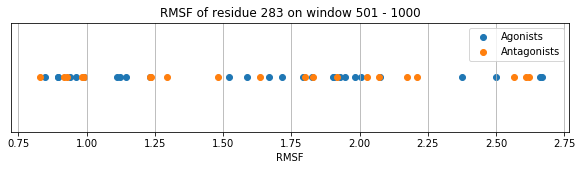

In [87]:
from MDSimsEval.rmsf_analysis import reset_rmsf_calculations
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue

which_res = 283
window_start = 501
window_stop = 1000

reset_rmsf_calculations(analysis_actors_dict, window_start, window_stop, rmsf_cache)

# Calculate avg RMSF per residue
residue_rmsfs_agon = np.array(
    [get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Agonists']])
residue_rmsfs_antagon = np.array(
    [get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Antagonists']])

fig = plt.figure(figsize=(10,2))
ax = fig.add_subplot(111)

plt.scatter(residue_rmsfs_agon[:, which_res], np.full((len(residue_rmsfs_agon)), 2), label="Agonists")
plt.scatter(residue_rmsfs_antagon[:, which_res], np.full((len(residue_rmsfs_antagon)), 2), label="Antagonists")

plt.title(f"RMSF of residue {which_res} on window {window_start} - {window_stop}")
plt.yticks([])

plt.xlabel('RMSF')
plt.grid()

plt.legend()

plt.savefig(f'../figures/RMSF/new/special_res/residue_{which_res}_{window_start}_{window_stop}.png', format='png')

plt.show()

## Cherry Picking of Residues

### Residues 115, 117 

(54, 3)


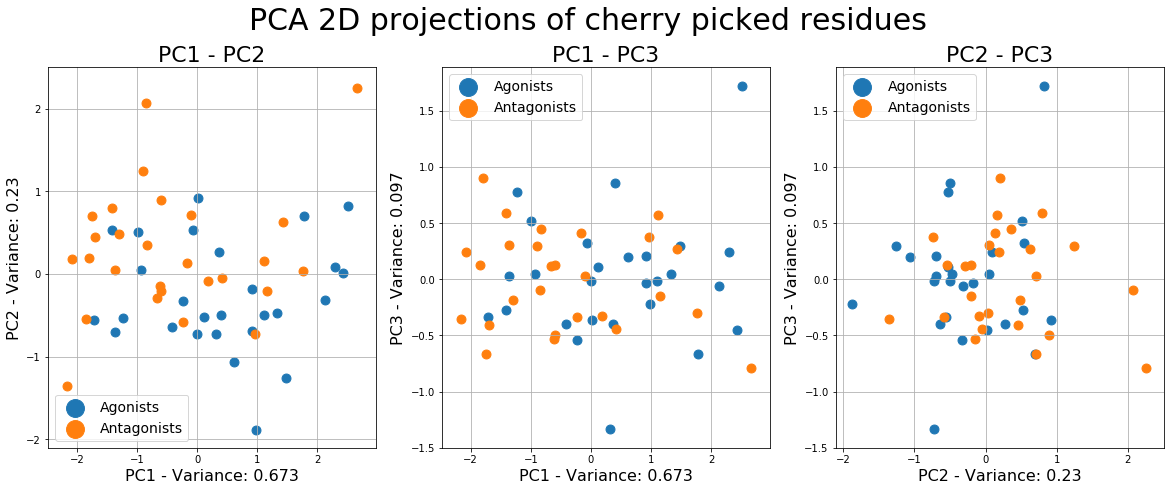

In [5]:
from sklearn.decomposition import PCA

from MDSimsEval.rmsf_bootstrapped_analysis import find_rmsf_of_residues

def cherry_pca_2d_projection(analysis_actors_dict, residues, rmsf_cache=None):
    
    rmsf_array = []
    for res, windows in residues.items():
        for window in windows:
            rmsf_array.append(find_rmsf_of_residues(analysis_actors_dict, [res], window[0], window[1], rmsf_cache))
    rmsf_array = np.array(rmsf_array).reshape(len(rmsf_array), len(rmsf_array[0])).T
    
    print(rmsf_array.shape)
        
#     rmsf_array = find_rmsf_of_residues(analysis_actors_dict, residues, start, stop, rmsf_cache)
    
    pca = PCA(n_components=3)
    
    tranformed_residues = pca.fit_transform(rmsf_array)
    
    
    fig = plt.figure(figsize=(20,7))
    fig.suptitle(f'PCA 2D projections of cherry picked residues', fontsize=30, y=1)
    
    pairs = [(0, 1), (0, 2), (1, 2)]
    for i, j in pairs:
        ax = fig.add_subplot(1, 3, i + j)

        plt.scatter(x=tranformed_residues[:len(analysis_actors_dict['Agonists']), i],
                y=tranformed_residues[:len(analysis_actors_dict['Agonists']), j],
                label='Agonists', s=80)

        plt.scatter(x=tranformed_residues[len(analysis_actors_dict['Agonists']):, i],
                    y=tranformed_residues[len(analysis_actors_dict['Agonists']):, j],
                    label='Antagonists', s=80)

        plt.xlabel(f"PC{i + 1} - Variance: {np.round(pca.explained_variance_ratio_[i], decimals=3)}", fontsize=16)
        plt.ylabel(f"PC{j + 1} - Variance: {np.round(pca.explained_variance_ratio_[j], decimals=3)}", fontsize=16)

        plt.grid()

        plt.legend(prop={'size': 14}, markerscale=2, ncol=1)

        plt.title(f'PC{i + 1} - PC{j + 1}', fontsize=22)
#                       f'| Variance: {np.round(pca.explained_variance_ratio_[which_row] + pca.explained_variance_ratio_[which_col], decimals=3)}')
    
        

    plt.savefig(f'../figures/RMSF/final/cherry_picked/cherry_picked_new_data.png', format='png')
    plt.show()
    
    
cherry_pca_2d_projection(analysis_actors_dict, 
                         {
                             115: [[0, 500], [2000, 2500]],
                             117: [[2000, 2500]]
                         }, 
                         rmsf_cache)

# cherry_pca_2d_projection(analysis_actors_dict, 
#                          {
#                              115: [[0, 500], [2000, 2500]],
#                              117: [[2000, 2500]],
#                              81: [[2000, 2500]],
#                              78: [[1000, 1500], [1500, 2000]],
#                              254: [[0, 500], [1500, 2000]],
#                          }, 
#                          rmsf_cache)

In [13]:
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue
from MDSimsEval.rmsf_analysis import reset_rmsf_calculations
from MDSimsEval.rmsf_bootstrapped_analysis import find_rmsf_of_residues



def cherry_corr_of_significant_residues(analysis_actors_dict, residues, method='spearman',rmsf_cache=None):    
    rmsf_array = []
    for res, windows in residues.items():
        for window in windows:
            rmsf_array.append(find_rmsf_of_residues(analysis_actors_dict, [res], window[0], window[1], rmsf_cache))
    rmsf_array = np.array(rmsf_array).reshape(len(rmsf_array), len(rmsf_array[0])).T
    
    # Use only the first 5 chars of the ligand name for better visual results
    ligand_names = [ligand.drug_name[:5]
                    for ligand in analysis_actors_dict['Agonists'] + analysis_actors_dict['Antagonists']]
    rmsf_df = pd.DataFrame(rmsf_array.T, columns=ligand_names)
    
    # Create the correlation dataframe
    corr = rmsf_df.corr(method=method)
    print(corr.shape)
    names_agon = {ligand.drug_name[:5] for ligand in analysis_actors_dict['Agonists']}
    names_antagon = {ligand.drug_name[:5] for ligand in analysis_actors_dict['Antagonists']}
    
    fig = plt.figure(figsize=(40,20))
    ax = fig.add_subplot(111)
    
    ax = sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=0, annot_kws={"fontsize":14}, cbar=False)
    
    for tick_label in ax.get_yticklabels():
        tick_text = tick_label.get_text()
        
        tick_label.set_fontsize(14)
        tick_label.set_rotation('horizontal')
        
        if tick_text in names_agon:
            tick_label.set_color('tab:blue')
        elif tick_text in names_antagon:
            tick_label.set_color('tab:orange')
    
        else:
            raise KeyError('Ligand tick label is unknown')
    
    for tick_label in ax.get_xticklabels():
        tick_text = tick_label.get_text()
        
        tick_label.set_fontsize(14)
        tick_label.set_rotation('vertical')
        
        if tick_text in names_agon:
            tick_label.set_color('tab:blue')
        elif tick_text in names_antagon:
            tick_label.set_color('tab:orange')
        else:
            raise KeyError('Ligand tick label is unknown')
            
    plt.title(f'Heatmap of Cherry Picked Residues on all the ligands', fontsize=18)
    
    plt.savefig(f'../figures/RMSF/final/cherry_picked/spear_corr_new_data.png', format='png', bbox_inches='tight')
    
    plt.close()
    

cherry_corr_of_significant_residues(analysis_actors_dict, 
                         {
                             115: [[0, 500], [2000, 2500]],
                             117: [[2000, 2500]],
                             81: [[2000, 2500]],
                             78: [[1000, 1500], [1500, 2000]],
                             254: [[0, 500], [1500, 2000]],
                         }, 
                         rmsf_cache=rmsf_cache)


(54, 54)
